In [1]:
import gc

In [2]:
gc.collect()

20

In [1]:
from py2neo.data import Node, Relationship
import py2neo

In [2]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "graphsagE@4"))

In [3]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4jGraphSAGENodeGenerator, Neo4jStellarGraph
from stellargraph.layer import GraphSAGE, AttentionalAggregator

import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
%matplotlib inline

In [4]:
# Authors
authors_df = graph.run(
    """
    MATCH (n:Author) RETURN n.name as name
    """).to_data_frame()

In [5]:
(authors_df.drop_duplicates() == authors_df).drop_duplicates()

name
0  True

In [6]:
len(authors_df)

527402

In [7]:
authors_df.head()

name
0   Sanjiban Sekhar Roy
1  V. Madhu Viswanatham
2              N. Saraf
3           Anant Gupta
4          Daniel Wolff

In [8]:
# To give all the authors a identifier
dic_authors = {}
for i in range(len(authors_df)):
    dic_authors[authors_df['name'][i]] = i

In [9]:
len(dic_authors)

527402

In [10]:
authors_ = list(dic_authors.keys())
dic_authors[authors_[50]]

50

In [11]:
co = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source,b.name as target 
    """).to_data_frame()

In [12]:
print(co.shape)
co.head()

(1430992, 2)


source                target
0  Sanjiban Sekhar Roy  V. Madhu Viswanatham
1  Sanjiban Sekhar Roy            Dev Gaurav
2  Sanjiban Sekhar Roy    P. Venkata Krishna
3  Sanjiban Sekhar Roy              N. Saraf
4  Sanjiban Sekhar Roy        Dishant Mittal

In [13]:
co[co['source'] == 'Roel Peeters']

source               target
996920  Roel Peeters  Christian Wachsmann
996921  Roel Peeters         Bart Mennink

In [14]:
cal_colab_direct_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [15]:
print(cal_colab_direct_df.shape)
cal_colab_direct_df.head()

(1430992, 3)


source                target  r.collaborations
0  Sanjiban Sekhar Roy  V. Madhu Viswanatham                 1
1  Sanjiban Sekhar Roy            Dev Gaurav                 1
2  Sanjiban Sekhar Roy    P. Venkata Krishna                 1
3  Sanjiban Sekhar Roy              N. Saraf                 1
4  Sanjiban Sekhar Roy        Dishant Mittal                 1

In [16]:
ss = set()
for i in range(len(cal_colab_direct_df)):
    ss.add(cal_colab_direct_df['source'][i])
    ss.add(cal_colab_direct_df['target'][i])

In [17]:
len(ss)

501223

In [18]:
cal_colab_direct_df[cal_colab_direct_df['r.collaborations'] == 0]

Empty DataFrame
Columns: [source, target, r.collaborations]
Index: []

In [19]:
# Calculate total collaborations per author (direct)
colab_dic_direct = {}
for i in range(len(cal_colab_direct_df)):
    if dic_authors[cal_colab_direct_df['source'][i]] not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] += cal_colab_direct_df['r.collaborations'][i]

    if dic_authors[cal_colab_direct_df['target'][i]]  not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] += cal_colab_direct_df['r.collaborations'][i]

In [20]:
print(len(colab_dic_direct))
# colab_dic_direct

501223


In [21]:
cal_colab_cited_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_CITED_FINAL]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [22]:
print(cal_colab_cited_df.shape)
cal_colab_cited_df.head()

(3236443, 3)


source            target  r.collaborations
0       Jie Sun       Huanbin Liu                 1
1       Jie Sun         Yue Zheng                 1
2       Jie Sun          June Liu                 1
3       Jie Sun       Jiapu Zhang                 1
4  Nicolas Biri  Benjamin Renwart                 1

In [23]:
cal_colab_cited_df[cal_colab_cited_df['source'] == 'Steven Weber']

source              target  r.collaborations
1059079  Steven Weber      Martin Haenggi                 1
1059080  Steven Weber         Wenyi Zhang                 1
1059081  Steven Weber    Virgil D. Gligor                 1
1059082  Steven Weber         Osman Yagan                 1
1059083  Steven Weber            Yi Zhong                 1
1059084  Steven Weber         Congduan Li                 1
1059085  Steven Weber            Jun Zhao                 1
1059086  Steven Weber    Angeliki Alexiou                 1
1059087  Steven Weber  Stelios Stefanatos                 1
1059088  Steven Weber   Antonis G. Gotsis                 1

In [24]:
# Calculate total collaborations per author (cited)
colab_dic_cited = {}
for i in range(len(cal_colab_cited_df)):
    if dic_authors[cal_colab_cited_df['source'][i]] not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] += cal_colab_cited_df['r.collaborations'][i]

    if dic_authors[cal_colab_cited_df['target'][i]]  not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] += cal_colab_cited_df['r.collaborations'][i]

In [25]:
print(len(colab_dic_cited))
# colab_dic_direct

298691


In [26]:
colab_dic_direct == colab_dic_cited

False

In [27]:
co['source'] = co['source'].apply(lambda x: dic_authors[x])
co['target'] = co['target'].apply(lambda x: dic_authors[x])

In [28]:
co.head()
dff = co
del co

In [29]:
print(dff.shape)
dff.head()

(1430992, 2)


source  target
0       0       1
1       0  420686
2       0  219960
3       0       2
4       0  420685

In [30]:
dff['target'].max()

527401

In [31]:
cora_feature_names = [f"f{i}" for i in range(2)]
print(cora_feature_names)

['f0', 'f1']


In [32]:
cols = ['dir_colabs', 'cited_colabs']
idx = [i for i in range(len(dic_authors))]

In [33]:
feat = pd.DataFrame(index=idx, columns=cols)

In [34]:
feat.fillna(0, inplace=True)
feat.head()

dir_colabs  cited_colabs
0           0             0
1           0             0
2           0             0
3           0             0
4           0             0

In [35]:
for i in range(len(dic_authors)):
    if i in colab_dic_direct.keys():
        feat['dir_colabs'][i] = colab_dic_direct[i]
    else:
        feat['dir_colabs'][i] = 0
        
    if i in colab_dic_cited.keys():
        feat['cited_colabs'][i] = colab_dic_cited[i]
    else:
        feat['cited_colabs'][i] = 0

feat.head()

dir_colabs  cited_colabs
0           7             0
1           5             0
2           5             0
3           9             0
4           8            17

In [36]:
len(feat['cited_colabs'].drop_duplicates())

1206

In [37]:
# Normalise thee feaatures to feed into the moddel
dir_mean = feat['dir_colabs'].mean()
dir_max = feat['dir_colabs'].max()
dir_min = feat['dir_colabs'].min()

cit_mean = feat['cited_colabs'].mean()
cit_max = feat['cited_colabs'].max()
cit_min = feat['cited_colabs'].min()

In [38]:
feat['dir_colabs'] = feat['dir_colabs'].apply(lambda x: ((x - dir_min) / (dir_max - dir_min)))
feat['cited_colabs'] = feat['cited_colabs'].apply(lambda x: ((x - cit_min) / (cit_max - cit_min)))

In [39]:
feat.head(10)

dir_colabs  cited_colabs
0    0.008206      0.000000
1    0.005862      0.000000
2    0.005862      0.000000
3    0.010551      0.000000
4    0.009379      0.002008
5    0.002345      0.000472
6    0.002345      0.000118
7    0.002345      0.000118
8    0.010551      0.000945
9    0.002345      0.000000

In [40]:
from tqdm import tqdm
tqdm.pandas()

In [41]:
fos_dff = graph.run("""

MATCH((n:Author)<-[:AUTHOR]-(a:Article))
RETURN n.name as name,apoc.text.join(collect(a.fos),":") as fos,apoc.text.join(collect(a.title)," ") as title
ORDER BY n.name

""").to_data_frame()

In [42]:
fos_dff.head(5)

name                                                fos  \
0       A A Sayyid  Digital control:0.506499:Ripple:0.490208536:Co...   
1  A Aart Blokhuis  Affine plane (incidence geometry):0.5433483:Di...   
2  A Adang Suwandi  Ciphertext stealing:0.672032237:Discrete mathe...   
3        A Agarwal  Distributed computing:0.46395582:Real-time com...   
4    A Al-Habaibeh  Machining:0.499851584:Time domain:0.432159424:...   

                                               title  
0  High-power fault-tolerant and multiple indepen...  
1  On Sets without Tangents in Galois Planes of E...  
2                          The New Block Cipher: BC2  
3  Cloud Scheduler: a resource manager for distri...  
4  A comparative study of using spindle motor pow...

In [43]:
def get_d(x):
    t = x.split(':')
    dict_val={}
    for i in range(len(t)):
        try:
            if(float(t[i])):
                if(t[i-1] in dict_val):
                    dict_val[t[i-1]].append(t[i])
                else:
                    dict_val[t[i-1]]=[t[i]]
        except:
            pass
    for i in dict_val:
        dict_val[i] = sorted(dict_val[i],reverse=True)
    return dict_val

In [44]:
fos_dff['key'] = fos_dff['fos'].apply(lambda x: get_d(x))

In [45]:
fos_dff.head(10)

name  \
0                 A A Sayyid   
1            A Aart Blokhuis   
2            A Adang Suwandi   
3                  A Agarwal   
4              A Al-Habaibeh   
5              A Alaka Hafiz   
6  A Alejandro Montes Garcia   
7   A Aleksandra Kuzmanovska   
8       A Alessandro Catania   
9         A Alexey Mashtakov   

                                                 fos  \
0  Digital control:0.506499:Ripple:0.490208536:Co...   
1  Affine plane (incidence geometry):0.5433483:Di...   
2  Ciphertext stealing:0.672032237:Discrete mathe...   
3  Distributed computing:0.46395582:Real-time com...   
4  Machining:0.499851584:Time domain:0.432159424:...   
5  Support vector machine:0.428326339:Data mining...   
6  Data mining:0.460538715:Support vector machine...   
7  Distributed computing:0.445926726:Programming ...   
8  Management science:0.446030885:Cluster analysi...   
9  Maximum principle:0.4976504:Wavefront:0.451686...   

                                               title  \
0  High-power fault-tolerant and multiple indepen...   
1  On Sets without Tangents in Galois Planes of E...   
2                          The New Block Cipher: BC2   
3  Cloud Scheduler: a resource manager for distri...   
4  A comparative study of using spindle motor pow...   
5  Bankruptcy Prediction of Construction Business...   
6  Classification of historical notary acts with ...   
7  Dynamically Scheduling a Component-Based Frame...   
8  An Innovative Contribution to Health Technolog...   
9  A PDE Approach to Data-Driven Sub-Riemannian G...   

                                                 key  
0  {'Digital control': ['0.506499'], 'Ripple': ['...  
1  {'Affine plane (incidence geometry)': ['0.5433...  
2  {'Ciphertext stealing': ['0.672032237'], 'Disc...  
3  {'Distributed computing': ['0.46395582', '0.42...  
4  {'Machining': ['0.499851584'], 'Time domain': ...  
5  {'Support vector machine': ['0.428326339'], 'D...  
6  {'Data mining': ['0.460538715'], 'Support vect...  
7  {'Distributed computing': ['0.445926726'], 'Pr...  
8  {'Management science': ['0.446030885'], 'Clust...  
9  {'Maximum principle': ['0.4976504'], 'Wavefron...

In [46]:
fos_dff['key'] = fos_dff['key'].apply(lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)} )

In [47]:
def get_ten(x):
    y={}
    k=list(x.keys())[:10]
    for i in k:
        y[i]=x[i]    
    return y

fos_dff['sortedkey'] = fos_dff['key'].apply(lambda x:get_ten(x))

In [48]:
fos_dff.head(10)

name  \
0                 A A Sayyid   
1            A Aart Blokhuis   
2            A Adang Suwandi   
3                  A Agarwal   
4              A Al-Habaibeh   
5              A Alaka Hafiz   
6  A Alejandro Montes Garcia   
7   A Aleksandra Kuzmanovska   
8       A Alessandro Catania   
9         A Alexey Mashtakov   

                                                 fos  \
0  Digital control:0.506499:Ripple:0.490208536:Co...   
1  Affine plane (incidence geometry):0.5433483:Di...   
2  Ciphertext stealing:0.672032237:Discrete mathe...   
3  Distributed computing:0.46395582:Real-time com...   
4  Machining:0.499851584:Time domain:0.432159424:...   
5  Support vector machine:0.428326339:Data mining...   
6  Data mining:0.460538715:Support vector machine...   
7  Distributed computing:0.445926726:Programming ...   
8  Management science:0.446030885:Cluster analysi...   
9  Maximum principle:0.4976504:Wavefront:0.451686...   

                                               title  \
0  High-power fault-tolerant and multiple indepen...   
1  On Sets without Tangents in Galois Planes of E...   
2                          The New Block Cipher: BC2   
3  Cloud Scheduler: a resource manager for distri...   
4  A comparative study of using spindle motor pow...   
5  Bankruptcy Prediction of Construction Business...   
6  Classification of historical notary acts with ...   
7  Dynamically Scheduling a Component-Based Frame...   
8  An Innovative Contribution to Health Technolog...   
9  A PDE Approach to Data-Driven Sub-Riemannian G...   

                                                 key  \
0  {'LED lamp': ['0.555345237'], 'Ćuk converter':...   
1  {'0.5605073': ['Infinity'], 'Non-Desarguesian ...   
2  {'Affine cipher': ['0.7047154'], 'Transpositio...   
3  {'Cloud computing': ['0.666620851'], 'Grid com...   
4  {'Tool wear': ['0.5538641', '0.5226331'], 'Ima...   
5  {'Analytics': ['0.6326959'], 'Big data': ['0.6...   
6  {'tf–idf': ['0.512849331'], 'Support vector ma...   
7  {'Resource allocation': ['0.695579469'], 'Reso...   
8  {'Technology assessment': ['0.601890266'], 'He...   
9  {'Geodesic': ['0.5030189'], 'Metric tensor': [...   

                                           sortedkey  
0  {'LED lamp': ['0.555345237'], 'Ćuk converter':...  
1  {'0.5605073': ['Infinity'], 'Non-Desarguesian ...  
2  {'Affine cipher': ['0.7047154'], 'Transpositio...  
3  {'Cloud computing': ['0.666620851'], 'Grid com...  
4  {'Tool wear': ['0.5538641', '0.5226331'], 'Ima...  
5  {'Analytics': ['0.6326959'], 'Big data': ['0.6...  
6  {'tf–idf': ['0.512849331'], 'Support vector ma...  
7  {'Resource allocation': ['0.695579469'], 'Reso...  
8  {'Technology assessment': ['0.601890266'], 'He...  
9  {'Geodesic': ['0.5030189'], 'Metric tensor': [...

In [49]:
fos_dff['sortedkey'][0].keys()

dict_keys(['LED lamp', 'Ćuk converter', 'Digital control', 'Filter capacitor', 'Fault tolerance', 'Downtime', 'Inductor', 'Ripple', 'Control engineering', 'Engineering'])

In [50]:
kk = set()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kk.add(k)

In [51]:
len(kk)

47630

In [52]:
kkk = list()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kkk.append(k)

In [53]:
print(len(kkk))
print(len(set(kkk)))

4633703
47630


In [54]:
fos_dff['FOS_BEST'] = fos_dff['sortedkey'].apply(lambda x: list(x.keys()))

In [55]:
print(fos_dff['FOS_BEST'][0])
print(fos_dff['FOS_BEST'][63798])

['LED lamp', 'Ćuk converter', 'Digital control', 'Filter capacitor', 'Fault tolerance', 'Downtime', 'Inductor', 'Ripple', 'Control engineering', 'Engineering']
['Software development', 'Front and back ends', 'Engineering drawing', 'Line management', 'Data structure', 'Computer science', 'Information and Communications Technology', 'Computer vision', 'Scientific method', 'Present day']


In [56]:
# Practice
fos_dff['FOS_BEST']

0         [LED lamp, Ćuk converter, Digital control, Fil...
1         [0.5605073, Non-Desarguesian plane, Line coord...
2         [Affine cipher, Transposition cipher, CBC-MAC,...
3         [Cloud computing, Grid computing, Virtual mach...
4         [Tool wear, Image processing, Cutting tool, Co...
                                ...                        
527397    [Book embedding, Indifference graph, 1-planar ...
527398    [Indifference graph, Chordal graph, Pathwidth,...
527399    [K-optimal pattern discovery, Data stream mini...
527400    [Logical topology, Model checking, Interval te...
527401    [Public-key cryptography, Cryptographic protoc...
Name: FOS_BEST, Length: 527402, dtype: object

In [57]:
fos_multi_list = []
for i in range(len(fos_dff)):
  fos_multi_list.append(fos_dff['FOS_BEST'][i])

print(len(fos_multi_list))

527402


In [58]:
print(fos_multi_list[10])

['Bundle adjustment', 'Digitization', 'Photogrammetry', 'Cluster analysis', 'Visitor pattern', 'Computer vision', 'Computer science']


In [59]:
print(kk)

{'Group conflict', 'Boltzmann distribution', 'Selective auditory attention', 'Morning', 'Motor protein', 'Semantic unification', 'Endomorphism', 'Linux Unified Key Setup', 'Count–min sketch', 'Environmental impact assessment', 'Structured content', 'Cybernetics', 'Bs space', 'Contemporary art', 'Fluorescence', 'Recognition heuristic', 'Power Balance', 'Path-based strong component algorithm', 'Haptic memory', 'Protocol (object-oriented programming)', 'Lab color space', 'Random access', 'Internal audit', 'Projection pursuit', 'Variational method', 'Pulse shaping', 'Engineering analysis', 'Affine arithmetic', 'Contact microphone', 'Importance sampling', 'Management control system', 'Antenna noise temperature', 'Superposition calculus', 'kqueue', 'Civil Emergency Message', 'Natural heritage', 'Relevance logic', 'Human resource management', 'Digital Enhanced Cordless Telecommunications', 'Erlang (unit)', 'Magnetic cartridge', 'Soil survey', 'Negativity bias', 'Aircraft maintenance', 'Closed

In [60]:
fos_list = list(kk)
print(fos_list)

['Group conflict', 'Boltzmann distribution', 'Selective auditory attention', 'Morning', 'Motor protein', 'Semantic unification', 'Endomorphism', 'Linux Unified Key Setup', 'Count–min sketch', 'Environmental impact assessment', 'Structured content', 'Cybernetics', 'Bs space', 'Contemporary art', 'Fluorescence', 'Recognition heuristic', 'Power Balance', 'Path-based strong component algorithm', 'Haptic memory', 'Protocol (object-oriented programming)', 'Lab color space', 'Random access', 'Internal audit', 'Projection pursuit', 'Variational method', 'Pulse shaping', 'Engineering analysis', 'Affine arithmetic', 'Contact microphone', 'Importance sampling', 'Management control system', 'Antenna noise temperature', 'Superposition calculus', 'kqueue', 'Civil Emergency Message', 'Natural heritage', 'Relevance logic', 'Human resource management', 'Digital Enhanced Cordless Telecommunications', 'Erlang (unit)', 'Magnetic cartridge', 'Soil survey', 'Negativity bias', 'Aircraft maintenance', 'Closed

In [61]:
# LDA Logic ahead
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

d:\env\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [62]:
dictionary = corpora.Dictionary(fos_multi_list)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in fos_multi_list]

In [63]:
# logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [65]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamulticore.LdaMulticore

# Build LDA model
# lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=120, random_state=100, passes=70,iterations=120)
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=80, random_state=100, passes=50,iterations=100)

2021-04-17 17:25:56,104 : INFO : using symmetric alpha at 0.0125
2021-04-17 17:25:56,106 : INFO : using symmetric eta at 0.0125
2021-04-17 17:25:56,123 : INFO : using serial LDA version on this node
2021-04-17 17:25:56,483 : INFO : running online LDA training, 80 topics, 50 passes over the supplied corpus of 527402 documents, updating every 38000 documents, evaluating every ~380000 documents, iterating 100x with a convergence threshold of 0.001000
2021-04-17 17:25:56,485 : INFO : training LDA model using 19 processes
2021-04-17 17:26:14,101 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/527402, outstanding queue size 1
2021-04-17 17:26:14,183 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/527402, outstanding queue size 2
2021-04-17 17:26:14,185 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/527402, outstanding queue size 3
2021-04-17 17:26:14,187 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #800

2021-04-17 17:26:20,681 : INFO : topic diff=73.247833, rho=1.000000
2021-04-17 17:26:20,686 : INFO : PROGRESS: pass 0, dispatched chunk #48 = documents up to #98000/527402, outstanding queue size 4
2021-04-17 17:26:20,829 : INFO : PROGRESS: pass 0, dispatched chunk #49 = documents up to #100000/527402, outstanding queue size 2
2021-04-17 17:26:20,876 : INFO : PROGRESS: pass 0, dispatched chunk #50 = documents up to #102000/527402, outstanding queue size 3
2021-04-17 17:26:20,877 : INFO : PROGRESS: pass 0, dispatched chunk #51 = documents up to #104000/527402, outstanding queue size 4
2021-04-17 17:26:20,878 : INFO : PROGRESS: pass 0, dispatched chunk #52 = documents up to #106000/527402, outstanding queue size 5
2021-04-17 17:26:20,878 : INFO : PROGRESS: pass 0, dispatched chunk #53 = documents up to #108000/527402, outstanding queue size 6
2021-04-17 17:26:20,880 : INFO : PROGRESS: pass 0, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 7
2021-04-17 17:26

2021-04-17 17:26:24,438 : INFO : topic #72 (0.013): 0.019*"Computer science" + 0.009*"Distributed computing" + 0.007*"Computer network" + 0.005*"Real-time computing" + 0.005*"Data mining" + 0.005*"Electronic engineering" + 0.005*"Computer vision" + 0.004*"The Internet" + 0.004*"Engineering" + 0.004*"Theoretical computer science"
2021-04-17 17:26:24,439 : INFO : topic #38 (0.013): 0.026*"Computer science" + 0.011*"Machine learning" + 0.009*"Distributed computing" + 0.007*"Mathematics" + 0.007*"Architecture" + 0.007*"Mathematical optimization" + 0.007*"Computer network" + 0.007*"Pattern recognition" + 0.005*"Data mining" + 0.005*"Control theory"
2021-04-17 17:26:24,440 : INFO : topic #8 (0.013): 0.033*"Computer science" + 0.012*"Distributed computing" + 0.012*"Real-time computing" + 0.007*"Machine learning" + 0.007*"Data mining" + 0.006*"Computer network" + 0.006*"Architecture" + 0.005*"Control theory" + 0.005*"Mathematics" + 0.005*"Knowledge management"
2021-04-17 17:26:24,500 : INFO : 

2021-04-17 17:26:26,912 : INFO : PROGRESS: pass 0, dispatched chunk #146 = documents up to #294000/527402, outstanding queue size 40
2021-04-17 17:26:26,913 : INFO : PROGRESS: pass 0, dispatched chunk #147 = documents up to #296000/527402, outstanding queue size 41
2021-04-17 17:26:26,914 : INFO : PROGRESS: pass 0, dispatched chunk #148 = documents up to #298000/527402, outstanding queue size 42
2021-04-17 17:26:26,942 : INFO : PROGRESS: pass 0, dispatched chunk #149 = documents up to #300000/527402, outstanding queue size 43
2021-04-17 17:26:26,980 : INFO : PROGRESS: pass 0, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 44
2021-04-17 17:26:27,021 : INFO : PROGRESS: pass 0, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 45
2021-04-17 17:26:27,062 : INFO : PROGRESS: pass 0, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 46
2021-04-17 17:26:27,105 : INFO : PROGRESS: pass 0, dispatched chunk #

2021-04-17 17:26:32,304 : INFO : PROGRESS: pass 0, dispatched chunk #194 = documents up to #390000/527402, outstanding queue size 30
2021-04-17 17:26:32,305 : INFO : PROGRESS: pass 0, dispatched chunk #195 = documents up to #392000/527402, outstanding queue size 31
2021-04-17 17:26:32,306 : INFO : PROGRESS: pass 0, dispatched chunk #196 = documents up to #394000/527402, outstanding queue size 32
2021-04-17 17:26:32,307 : INFO : PROGRESS: pass 0, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 33
2021-04-17 17:26:32,307 : INFO : PROGRESS: pass 0, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 34
2021-04-17 17:26:32,308 : INFO : PROGRESS: pass 0, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 35
2021-04-17 17:26:32,309 : INFO : PROGRESS: pass 0, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 36
2021-04-17 17:26:32,310 : INFO : PROGRESS: pass 0, dispatched chunk #

2021-04-17 17:26:37,249 : INFO : PROGRESS: pass 0, dispatched chunk #242 = documents up to #486000/527402, outstanding queue size 20
2021-04-17 17:26:37,250 : INFO : PROGRESS: pass 0, dispatched chunk #243 = documents up to #488000/527402, outstanding queue size 21
2021-04-17 17:26:37,251 : INFO : PROGRESS: pass 0, dispatched chunk #244 = documents up to #490000/527402, outstanding queue size 22
2021-04-17 17:26:37,253 : INFO : PROGRESS: pass 0, dispatched chunk #245 = documents up to #492000/527402, outstanding queue size 23
2021-04-17 17:26:37,253 : INFO : PROGRESS: pass 0, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 24
2021-04-17 17:26:37,254 : INFO : PROGRESS: pass 0, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 25
2021-04-17 17:26:37,255 : INFO : PROGRESS: pass 0, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 26
2021-04-17 17:26:37,257 : INFO : PROGRESS: pass 0, dispatched chunk #

2021-04-17 17:26:42,837 : INFO : PROGRESS: pass 1, dispatched chunk #10 = documents up to #22000/527402, outstanding queue size 11
2021-04-17 17:26:42,839 : INFO : PROGRESS: pass 1, dispatched chunk #11 = documents up to #24000/527402, outstanding queue size 12
2021-04-17 17:26:42,887 : INFO : PROGRESS: pass 1, dispatched chunk #12 = documents up to #26000/527402, outstanding queue size 13
2021-04-17 17:26:42,888 : INFO : PROGRESS: pass 1, dispatched chunk #13 = documents up to #28000/527402, outstanding queue size 14
2021-04-17 17:26:42,889 : INFO : PROGRESS: pass 1, dispatched chunk #14 = documents up to #30000/527402, outstanding queue size 15
2021-04-17 17:26:42,890 : INFO : PROGRESS: pass 1, dispatched chunk #15 = documents up to #32000/527402, outstanding queue size 16
2021-04-17 17:26:42,891 : INFO : PROGRESS: pass 1, dispatched chunk #16 = documents up to #34000/527402, outstanding queue size 17
2021-04-17 17:26:42,892 : INFO : PROGRESS: pass 1, dispatched chunk #17 = documents

2021-04-17 17:26:47,457 : INFO : topic diff=0.018812, rho=0.061348
2021-04-17 17:26:47,462 : INFO : PROGRESS: pass 1, dispatched chunk #60 = documents up to #122000/527402, outstanding queue size 15
2021-04-17 17:26:47,856 : INFO : PROGRESS: pass 1, dispatched chunk #61 = documents up to #124000/527402, outstanding queue size 2
2021-04-17 17:26:47,906 : INFO : PROGRESS: pass 1, dispatched chunk #62 = documents up to #126000/527402, outstanding queue size 3
2021-04-17 17:26:47,908 : INFO : PROGRESS: pass 1, dispatched chunk #63 = documents up to #128000/527402, outstanding queue size 4
2021-04-17 17:26:47,909 : INFO : PROGRESS: pass 1, dispatched chunk #64 = documents up to #130000/527402, outstanding queue size 5
2021-04-17 17:26:47,910 : INFO : PROGRESS: pass 1, dispatched chunk #65 = documents up to #132000/527402, outstanding queue size 6
2021-04-17 17:26:47,911 : INFO : PROGRESS: pass 1, dispatched chunk #66 = documents up to #134000/527402, outstanding queue size 7
2021-04-17 17:2

2021-04-17 17:26:52,545 : INFO : topic #17 (0.013): 0.031*"Computer science" + 0.008*"Machine learning" + 0.008*"Mathematical optimization" + 0.007*"Mathematics" + 0.006*"Data mining" + 0.006*"Distributed computing" + 0.005*"Theoretical computer science" + 0.005*"Control theory" + 0.005*"Computer vision" + 0.004*"Real-time computing"
2021-04-17 17:26:52,546 : INFO : topic #70 (0.013): 0.022*"Machine learning" + 0.019*"Computer science" + 0.012*"Pattern recognition" + 0.011*"Data compression" + 0.010*"Artificial neural network" + 0.009*"Control theory" + 0.008*"Lossless compression" + 0.007*"Theoretical computer science" + 0.006*"Image compression" + 0.006*"Mathematics"
2021-04-17 17:26:52,548 : INFO : topic #6 (0.013): 0.026*"Control theory" + 0.022*"Computer science" + 0.021*"Mathematical optimization" + 0.018*"Mathematics" + 0.014*"Control engineering" + 0.013*"Nonlinear system" + 0.011*"Matrix (mathematics)" + 0.006*"Discrete mathematics" + 0.005*"Machine learning" + 0.005*"Model pr

2021-04-17 17:26:53,572 : INFO : PROGRESS: pass 1, dispatched chunk #172 = documents up to #346000/527402, outstanding queue size 55
2021-04-17 17:26:53,698 : INFO : PROGRESS: pass 1, dispatched chunk #173 = documents up to #348000/527402, outstanding queue size 55
2021-04-17 17:26:53,700 : INFO : PROGRESS: pass 1, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 56
2021-04-17 17:26:53,744 : INFO : PROGRESS: pass 1, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 57
2021-04-17 17:26:53,990 : INFO : PROGRESS: pass 1, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 56
2021-04-17 17:26:53,991 : INFO : PROGRESS: pass 1, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 57
2021-04-17 17:26:54,271 : INFO : PROGRESS: pass 1, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 55
2021-04-17 17:26:54,272 : INFO : PROGRESS: pass 1, dispatched chunk #

2021-04-17 17:26:58,235 : INFO : PROGRESS: pass 1, dispatched chunk #220 = documents up to #442000/527402, outstanding queue size 40
2021-04-17 17:26:58,235 : INFO : PROGRESS: pass 1, dispatched chunk #221 = documents up to #444000/527402, outstanding queue size 41
2021-04-17 17:26:58,265 : INFO : PROGRESS: pass 1, dispatched chunk #222 = documents up to #446000/527402, outstanding queue size 42
2021-04-17 17:26:58,266 : INFO : PROGRESS: pass 1, dispatched chunk #223 = documents up to #448000/527402, outstanding queue size 43
2021-04-17 17:26:58,308 : INFO : PROGRESS: pass 1, dispatched chunk #224 = documents up to #450000/527402, outstanding queue size 44
2021-04-17 17:26:58,347 : INFO : PROGRESS: pass 1, dispatched chunk #225 = documents up to #452000/527402, outstanding queue size 45
2021-04-17 17:26:58,392 : INFO : PROGRESS: pass 1, dispatched chunk #226 = documents up to #454000/527402, outstanding queue size 46
2021-04-17 17:26:58,436 : INFO : PROGRESS: pass 1, dispatched chunk #

2021-04-17 17:27:05,357 : INFO : topic #58 (0.013): 0.018*"Computer science" + 0.015*"Wireless ad hoc network" + 0.015*"Distributed computing" + 0.014*"Computer network" + 0.014*"Vehicular ad hoc network" + 0.013*"Ad hoc wireless distribution service" + 0.013*"Mobile ad hoc network" + 0.012*"Optimized Link State Routing Protocol" + 0.009*"Adaptive quality of service multi-hop routing" + 0.008*"Mathematics"
2021-04-17 17:27:05,360 : INFO : topic #24 (0.013): 0.037*"Computer science" + 0.026*"Machine learning" + 0.025*"Software development" + 0.021*"Social software engineering" + 0.020*"Software construction" + 0.018*"Package development process" + 0.013*"Pattern recognition" + 0.012*"Software peer review" + 0.012*"Resource-oriented architecture" + 0.011*"Artificial intelligence"
2021-04-17 17:27:05,362 : INFO : topic #79 (0.013): 0.066*"Discrete mathematics" + 0.063*"Mathematics" + 0.050*"Combinatorics" + 0.016*"Computer science" + 0.011*"Mathematical optimization" + 0.011*"Upper and lo

2021-04-17 17:27:07,652 : INFO : PROGRESS: pass 2, dispatched chunk #37 = documents up to #76000/527402, outstanding queue size 38
2021-04-17 17:27:07,687 : INFO : PROGRESS: pass 2, dispatched chunk #38 = documents up to #78000/527402, outstanding queue size 39
2021-04-17 17:27:07,688 : INFO : PROGRESS: pass 2, dispatched chunk #39 = documents up to #80000/527402, outstanding queue size 40
2021-04-17 17:27:07,689 : INFO : PROGRESS: pass 2, dispatched chunk #40 = documents up to #82000/527402, outstanding queue size 41
2021-04-17 17:27:07,690 : INFO : PROGRESS: pass 2, dispatched chunk #41 = documents up to #84000/527402, outstanding queue size 42
2021-04-17 17:27:07,724 : INFO : PROGRESS: pass 2, dispatched chunk #42 = documents up to #86000/527402, outstanding queue size 43
2021-04-17 17:27:07,769 : INFO : PROGRESS: pass 2, dispatched chunk #43 = documents up to #88000/527402, outstanding queue size 44
2021-04-17 17:27:07,808 : INFO : PROGRESS: pass 2, dispatched chunk #44 = documents

2021-04-17 17:27:12,683 : INFO : PROGRESS: pass 2, dispatched chunk #86 = documents up to #174000/527402, outstanding queue size 28
2021-04-17 17:27:12,684 : INFO : PROGRESS: pass 2, dispatched chunk #87 = documents up to #176000/527402, outstanding queue size 29
2021-04-17 17:27:12,685 : INFO : PROGRESS: pass 2, dispatched chunk #88 = documents up to #178000/527402, outstanding queue size 30
2021-04-17 17:27:12,687 : INFO : PROGRESS: pass 2, dispatched chunk #89 = documents up to #180000/527402, outstanding queue size 31
2021-04-17 17:27:12,688 : INFO : PROGRESS: pass 2, dispatched chunk #90 = documents up to #182000/527402, outstanding queue size 32
2021-04-17 17:27:12,688 : INFO : PROGRESS: pass 2, dispatched chunk #91 = documents up to #184000/527402, outstanding queue size 33
2021-04-17 17:27:12,689 : INFO : PROGRESS: pass 2, dispatched chunk #92 = documents up to #186000/527402, outstanding queue size 34
2021-04-17 17:27:12,690 : INFO : PROGRESS: pass 2, dispatched chunk #93 = do

2021-04-17 17:27:17,585 : INFO : PROGRESS: pass 2, dispatched chunk #134 = documents up to #270000/527402, outstanding queue size 15
2021-04-17 17:27:17,586 : INFO : PROGRESS: pass 2, dispatched chunk #135 = documents up to #272000/527402, outstanding queue size 16
2021-04-17 17:27:17,587 : INFO : PROGRESS: pass 2, dispatched chunk #136 = documents up to #274000/527402, outstanding queue size 17
2021-04-17 17:27:17,588 : INFO : PROGRESS: pass 2, dispatched chunk #137 = documents up to #276000/527402, outstanding queue size 18
2021-04-17 17:27:17,589 : INFO : PROGRESS: pass 2, dispatched chunk #138 = documents up to #278000/527402, outstanding queue size 19
2021-04-17 17:27:17,617 : INFO : PROGRESS: pass 2, dispatched chunk #139 = documents up to #280000/527402, outstanding queue size 20
2021-04-17 17:27:17,619 : INFO : PROGRESS: pass 2, dispatched chunk #140 = documents up to #282000/527402, outstanding queue size 21
2021-04-17 17:27:17,620 : INFO : PROGRESS: pass 2, dispatched chunk #

2021-04-17 17:27:22,379 : INFO : PROGRESS: pass 2, dispatched chunk #183 = documents up to #368000/527402, outstanding queue size 6
2021-04-17 17:27:22,381 : INFO : PROGRESS: pass 2, dispatched chunk #184 = documents up to #370000/527402, outstanding queue size 7
2021-04-17 17:27:22,382 : INFO : PROGRESS: pass 2, dispatched chunk #185 = documents up to #372000/527402, outstanding queue size 8
2021-04-17 17:27:22,383 : INFO : PROGRESS: pass 2, dispatched chunk #186 = documents up to #374000/527402, outstanding queue size 9
2021-04-17 17:27:22,384 : INFO : PROGRESS: pass 2, dispatched chunk #187 = documents up to #376000/527402, outstanding queue size 10
2021-04-17 17:27:22,385 : INFO : PROGRESS: pass 2, dispatched chunk #188 = documents up to #378000/527402, outstanding queue size 11
2021-04-17 17:27:22,386 : INFO : PROGRESS: pass 2, dispatched chunk #189 = documents up to #380000/527402, outstanding queue size 12
2021-04-17 17:27:22,387 : INFO : PROGRESS: pass 2, dispatched chunk #190 

2021-04-17 17:27:27,155 : INFO : topic #5 (0.013): 0.027*"Wavelet" + 0.021*"Wavelet transform" + 0.018*"Wavelet packet decomposition" + 0.018*"Discrete wavelet transform" + 0.017*"Active learning (machine learning)" + 0.016*"Computer science" + 0.015*"Stationary wavelet transform" + 0.014*"Political science" + 0.012*"Second-generation wavelet transform" + 0.009*"Semi-supervised learning"
2021-04-17 17:27:27,157 : INFO : topic #44 (0.013): 0.062*"Computer science" + 0.041*"Multimedia" + 0.029*"Knowledge management" + 0.025*"Human–computer interaction" + 0.019*"Simulation" + 0.009*"Management science" + 0.009*"User interface" + 0.008*"Game design" + 0.008*"Engineering" + 0.008*"Software"
2021-04-17 17:27:27,194 : INFO : topic diff=0.016627, rho=0.061233
2021-04-17 17:27:27,202 : INFO : PROGRESS: pass 2, dispatched chunk #238 = documents up to #478000/527402, outstanding queue size 2
2021-04-17 17:27:27,296 : INFO : PROGRESS: pass 2, dispatched chunk #239 = documents up to #480000/527402,

2021-04-17 17:27:31,665 : INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #2000/527402, outstanding queue size 1
2021-04-17 17:27:31,714 : INFO : PROGRESS: pass 3, dispatched chunk #1 = documents up to #4000/527402, outstanding queue size 2
2021-04-17 17:27:31,716 : INFO : PROGRESS: pass 3, dispatched chunk #2 = documents up to #6000/527402, outstanding queue size 3
2021-04-17 17:27:31,717 : INFO : PROGRESS: pass 3, dispatched chunk #3 = documents up to #8000/527402, outstanding queue size 4
2021-04-17 17:27:31,718 : INFO : PROGRESS: pass 3, dispatched chunk #4 = documents up to #10000/527402, outstanding queue size 5
2021-04-17 17:27:31,719 : INFO : PROGRESS: pass 3, dispatched chunk #5 = documents up to #12000/527402, outstanding queue size 6
2021-04-17 17:27:31,720 : INFO : PROGRESS: pass 3, dispatched chunk #6 = documents up to #14000/527402, outstanding queue size 7
2021-04-17 17:27:31,721 : INFO : PROGRESS: pass 3, dispatched chunk #7 = documents up to #16000/52740

2021-04-17 17:27:36,571 : INFO : topic #27 (0.013): 0.031*"Computer science" + 0.022*"Knowledge management" + 0.019*"Information system" + 0.013*"Information privacy" + 0.013*"Management science" + 0.012*"Operations management" + 0.012*"Engineering" + 0.012*"Management information systems" + 0.011*"Business" + 0.010*"Privacy software"
2021-04-17 17:27:36,574 : INFO : topic #23 (0.013): 0.026*"Computer science" + 0.009*"Computer vision" + 0.008*"Machine learning" + 0.007*"Visualization" + 0.006*"Actuarial science" + 0.006*"Control theory" + 0.006*"Scientific visualization" + 0.006*"Mathematical optimization" + 0.005*"Degree distribution" + 0.005*"Control engineering"
2021-04-17 17:27:36,576 : INFO : topic #13 (0.013): 0.033*"Fair-share scheduling" + 0.032*"Web modeling" + 0.030*"Web service" + 0.028*"Dynamic priority scheduling" + 0.022*"Web development" + 0.020*"Web page" + 0.020*"Two-level scheduling" + 0.020*"Computer science" + 0.017*"Scheduling (computing)" + 0.017*"Web standards"


2021-04-17 17:27:37,339 : INFO : PROGRESS: pass 3, dispatched chunk #112 = documents up to #226000/527402, outstanding queue size 53
2021-04-17 17:27:37,386 : INFO : PROGRESS: pass 3, dispatched chunk #113 = documents up to #228000/527402, outstanding queue size 54
2021-04-17 17:27:37,433 : INFO : PROGRESS: pass 3, dispatched chunk #114 = documents up to #230000/527402, outstanding queue size 55
2021-04-17 17:27:37,480 : INFO : PROGRESS: pass 3, dispatched chunk #115 = documents up to #232000/527402, outstanding queue size 56
2021-04-17 17:27:37,531 : INFO : PROGRESS: pass 3, dispatched chunk #116 = documents up to #234000/527402, outstanding queue size 57
2021-04-17 17:27:37,871 : INFO : PROGRESS: pass 3, dispatched chunk #117 = documents up to #236000/527402, outstanding queue size 55
2021-04-17 17:27:37,873 : INFO : PROGRESS: pass 3, dispatched chunk #118 = documents up to #238000/527402, outstanding queue size 56
2021-04-17 17:27:37,874 : INFO : PROGRESS: pass 3, dispatched chunk #

2021-04-17 17:27:41,768 : INFO : PROGRESS: pass 3, dispatched chunk #161 = documents up to #324000/527402, outstanding queue size 42
2021-04-17 17:27:41,814 : INFO : PROGRESS: pass 3, dispatched chunk #162 = documents up to #326000/527402, outstanding queue size 43
2021-04-17 17:27:41,862 : INFO : PROGRESS: pass 3, dispatched chunk #163 = documents up to #328000/527402, outstanding queue size 44
2021-04-17 17:27:41,900 : INFO : PROGRESS: pass 3, dispatched chunk #164 = documents up to #330000/527402, outstanding queue size 45
2021-04-17 17:27:41,942 : INFO : PROGRESS: pass 3, dispatched chunk #165 = documents up to #332000/527402, outstanding queue size 46
2021-04-17 17:27:41,988 : INFO : PROGRESS: pass 3, dispatched chunk #166 = documents up to #334000/527402, outstanding queue size 47
2021-04-17 17:27:42,028 : INFO : PROGRESS: pass 3, dispatched chunk #167 = documents up to #336000/527402, outstanding queue size 48
2021-04-17 17:27:42,069 : INFO : PROGRESS: pass 3, dispatched chunk #

2021-04-17 17:27:46,419 : INFO : PROGRESS: pass 3, dispatched chunk #210 = documents up to #422000/527402, outstanding queue size 33
2021-04-17 17:27:46,420 : INFO : PROGRESS: pass 3, dispatched chunk #211 = documents up to #424000/527402, outstanding queue size 34
2021-04-17 17:27:46,450 : INFO : PROGRESS: pass 3, dispatched chunk #212 = documents up to #426000/527402, outstanding queue size 35
2021-04-17 17:27:46,451 : INFO : PROGRESS: pass 3, dispatched chunk #213 = documents up to #428000/527402, outstanding queue size 36
2021-04-17 17:27:46,453 : INFO : PROGRESS: pass 3, dispatched chunk #214 = documents up to #430000/527402, outstanding queue size 37
2021-04-17 17:27:46,454 : INFO : PROGRESS: pass 3, dispatched chunk #215 = documents up to #432000/527402, outstanding queue size 38
2021-04-17 17:27:46,455 : INFO : PROGRESS: pass 3, dispatched chunk #216 = documents up to #434000/527402, outstanding queue size 39
2021-04-17 17:27:46,456 : INFO : PROGRESS: pass 3, dispatched chunk #

2021-04-17 17:27:51,168 : INFO : PROGRESS: pass 3, dispatched chunk #257 = documents up to #516000/527402, outstanding queue size 23
2021-04-17 17:27:51,198 : INFO : PROGRESS: pass 3, dispatched chunk #258 = documents up to #518000/527402, outstanding queue size 24
2021-04-17 17:27:51,199 : INFO : PROGRESS: pass 3, dispatched chunk #259 = documents up to #520000/527402, outstanding queue size 25
2021-04-17 17:27:51,200 : INFO : PROGRESS: pass 3, dispatched chunk #260 = documents up to #522000/527402, outstanding queue size 26
2021-04-17 17:27:51,201 : INFO : PROGRESS: pass 3, dispatched chunk #261 = documents up to #524000/527402, outstanding queue size 27
2021-04-17 17:27:51,202 : INFO : PROGRESS: pass 3, dispatched chunk #262 = documents up to #526000/527402, outstanding queue size 28
2021-04-17 17:27:51,203 : INFO : PROGRESS: pass 3, dispatched chunk #263 = documents up to #527402/527402, outstanding queue size 29
2021-04-17 17:27:53,157 : INFO : merging changes from 42000 documents

2021-04-17 17:27:55,584 : INFO : PROGRESS: pass 4, dispatched chunk #26 = documents up to #54000/527402, outstanding queue size 27
2021-04-17 17:27:55,585 : INFO : PROGRESS: pass 4, dispatched chunk #27 = documents up to #56000/527402, outstanding queue size 28
2021-04-17 17:27:55,586 : INFO : PROGRESS: pass 4, dispatched chunk #28 = documents up to #58000/527402, outstanding queue size 29
2021-04-17 17:27:55,616 : INFO : PROGRESS: pass 4, dispatched chunk #29 = documents up to #60000/527402, outstanding queue size 30
2021-04-17 17:27:55,617 : INFO : PROGRESS: pass 4, dispatched chunk #30 = documents up to #62000/527402, outstanding queue size 31
2021-04-17 17:27:55,618 : INFO : PROGRESS: pass 4, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:27:55,619 : INFO : PROGRESS: pass 4, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:27:55,621 : INFO : PROGRESS: pass 4, dispatched chunk #33 = documents

2021-04-17 17:28:00,331 : INFO : PROGRESS: pass 4, dispatched chunk #75 = documents up to #152000/527402, outstanding queue size 18
2021-04-17 17:28:00,332 : INFO : PROGRESS: pass 4, dispatched chunk #76 = documents up to #154000/527402, outstanding queue size 19
2021-04-17 17:28:00,333 : INFO : PROGRESS: pass 4, dispatched chunk #77 = documents up to #156000/527402, outstanding queue size 20
2021-04-17 17:28:00,334 : INFO : PROGRESS: pass 4, dispatched chunk #78 = documents up to #158000/527402, outstanding queue size 21
2021-04-17 17:28:00,335 : INFO : PROGRESS: pass 4, dispatched chunk #79 = documents up to #160000/527402, outstanding queue size 22
2021-04-17 17:28:00,369 : INFO : PROGRESS: pass 4, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 23
2021-04-17 17:28:00,370 : INFO : PROGRESS: pass 4, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 24
2021-04-17 17:28:00,371 : INFO : PROGRESS: pass 4, dispatched chunk #82 = do

2021-04-17 17:28:04,997 : INFO : PROGRESS: pass 4, dispatched chunk #123 = documents up to #248000/527402, outstanding queue size 7
2021-04-17 17:28:04,999 : INFO : PROGRESS: pass 4, dispatched chunk #124 = documents up to #250000/527402, outstanding queue size 8
2021-04-17 17:28:05,000 : INFO : PROGRESS: pass 4, dispatched chunk #125 = documents up to #252000/527402, outstanding queue size 9
2021-04-17 17:28:05,031 : INFO : PROGRESS: pass 4, dispatched chunk #126 = documents up to #254000/527402, outstanding queue size 10
2021-04-17 17:28:05,032 : INFO : PROGRESS: pass 4, dispatched chunk #127 = documents up to #256000/527402, outstanding queue size 11
2021-04-17 17:28:05,034 : INFO : PROGRESS: pass 4, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 12
2021-04-17 17:28:05,035 : INFO : PROGRESS: pass 4, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 13
2021-04-17 17:28:05,036 : INFO : PROGRESS: pass 4, dispatched chunk #130

2021-04-17 17:28:09,663 : INFO : topic #61 (0.013): 0.016*"Computer science" + 0.015*"Indifference graph" + 0.013*"Chordal graph" + 0.011*"1-planar graph" + 0.010*"Nash equilibrium" + 0.009*"Game theory" + 0.009*"Requirements analysis" + 0.009*"Requirements engineering" + 0.008*"Requirement" + 0.008*"Approximation algorithm"
2021-04-17 17:28:09,704 : INFO : topic diff=0.014187, rho=0.061005
2021-04-17 17:28:09,712 : INFO : PROGRESS: pass 4, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 1
2021-04-17 17:28:09,760 : INFO : PROGRESS: pass 4, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 2
2021-04-17 17:28:09,762 : INFO : PROGRESS: pass 4, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 3
2021-04-17 17:28:09,763 : INFO : PROGRESS: pass 4, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 4
2021-04-17 17:28:09,765 : INFO : PROGRESS: pass 4, dispatched chunk #179 = doc

2021-04-17 17:28:14,243 : INFO : merging changes from 118000 documents into a model of 527402 documents
2021-04-17 17:28:14,472 : INFO : topic #11 (0.013): 0.028*"Computer science" + 0.018*"Sociology" + 0.016*"Remote sensing" + 0.014*"Synthetic aperture radar" + 0.011*"Radar imaging" + 0.011*"Dialog system" + 0.010*"Knowledge management" + 0.008*"Dialog box" + 0.008*"Social science" + 0.008*"Computer vision"
2021-04-17 17:28:14,474 : INFO : topic #73 (0.013): 0.082*"Computer vision" + 0.060*"Computer science" + 0.021*"Computer graphics (images)" + 0.016*"Applications of UML" + 0.015*"Animation" + 0.013*"UML tool" + 0.011*"Iterative reconstruction" + 0.011*"Computer animation" + 0.010*"3D reconstruction" + 0.009*"Visualization"
2021-04-17 17:28:14,477 : INFO : topic #52 (0.013): 0.035*"Computer science" + 0.023*"Theoretical computer science" + 0.021*"Model checking" + 0.018*"Machine translation" + 0.017*"Rule-based machine translation" + 0.010*"New product development" + 0.010*"Linear t

2021-04-17 17:28:18,267 : INFO : topic #50 (0.013): 0.048*"Service delivery framework" + 0.042*"Service provider" + 0.034*"Service design" + 0.025*"Service level requirement" + 0.020*"Differentiated service" + 0.017*"Mobile QoS" + 0.015*"Service system" + 0.014*"Computer science" + 0.014*"Service level objective" + 0.012*"Data as a service"
2021-04-17 17:28:18,269 : INFO : topic #66 (0.013): 0.096*"Computer network" + 0.058*"Computer science" + 0.039*"Distributed computing" + 0.027*"Real-time computing" + 0.019*"Wireless" + 0.019*"Quality of service" + 0.019*"Network packet" + 0.018*"Wireless network" + 0.015*"Throughput" + 0.014*"The Internet"
2021-04-17 17:28:18,271 : INFO : topic #47 (0.013): 0.029*"Voltage graph" + 0.023*"Graph power" + 0.017*"Butterfly graph" + 0.016*"Factor-critical graph" + 0.016*"Strength of a graph" + 0.015*"Computer science" + 0.011*"Graph factorization" + 0.011*"Simplex graph" + 0.011*"Distance-hereditary graph" + 0.009*"Level set"
2021-04-17 17:28:18,272 : 

2021-04-17 17:28:19,695 : INFO : PROGRESS: pass 5, dispatched chunk #51 = documents up to #104000/527402, outstanding queue size 52
2021-04-17 17:28:19,741 : INFO : PROGRESS: pass 5, dispatched chunk #52 = documents up to #106000/527402, outstanding queue size 53
2021-04-17 17:28:19,786 : INFO : PROGRESS: pass 5, dispatched chunk #53 = documents up to #108000/527402, outstanding queue size 54
2021-04-17 17:28:19,836 : INFO : PROGRESS: pass 5, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:28:19,885 : INFO : PROGRESS: pass 5, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 56
2021-04-17 17:28:19,942 : INFO : PROGRESS: pass 5, dispatched chunk #56 = documents up to #114000/527402, outstanding queue size 57
2021-04-17 17:28:20,157 : INFO : PROGRESS: pass 5, dispatched chunk #57 = documents up to #116000/527402, outstanding queue size 56
2021-04-17 17:28:20,158 : INFO : PROGRESS: pass 5, dispatched chunk #58 = do

2021-04-17 17:28:24,079 : INFO : PROGRESS: pass 5, dispatched chunk #100 = documents up to #202000/527402, outstanding queue size 42
2021-04-17 17:28:24,116 : INFO : PROGRESS: pass 5, dispatched chunk #101 = documents up to #204000/527402, outstanding queue size 43
2021-04-17 17:28:24,154 : INFO : PROGRESS: pass 5, dispatched chunk #102 = documents up to #206000/527402, outstanding queue size 44
2021-04-17 17:28:24,195 : INFO : PROGRESS: pass 5, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 45
2021-04-17 17:28:24,233 : INFO : PROGRESS: pass 5, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 46
2021-04-17 17:28:24,278 : INFO : PROGRESS: pass 5, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 47
2021-04-17 17:28:24,319 : INFO : PROGRESS: pass 5, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 48
2021-04-17 17:28:24,366 : INFO : PROGRESS: pass 5, dispatched chunk #

2021-04-17 17:28:28,707 : INFO : PROGRESS: pass 5, dispatched chunk #149 = documents up to #300000/527402, outstanding queue size 34
2021-04-17 17:28:28,708 : INFO : PROGRESS: pass 5, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 35
2021-04-17 17:28:28,709 : INFO : PROGRESS: pass 5, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 36
2021-04-17 17:28:28,739 : INFO : PROGRESS: pass 5, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 37
2021-04-17 17:28:28,741 : INFO : PROGRESS: pass 5, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 38
2021-04-17 17:28:28,742 : INFO : PROGRESS: pass 5, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 39
2021-04-17 17:28:28,743 : INFO : PROGRESS: pass 5, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 40
2021-04-17 17:28:28,744 : INFO : PROGRESS: pass 5, dispatched chunk #

2021-04-17 17:28:33,450 : INFO : PROGRESS: pass 5, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 24
2021-04-17 17:28:33,480 : INFO : PROGRESS: pass 5, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 25
2021-04-17 17:28:33,480 : INFO : PROGRESS: pass 5, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 26
2021-04-17 17:28:33,481 : INFO : PROGRESS: pass 5, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 27
2021-04-17 17:28:33,482 : INFO : PROGRESS: pass 5, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 28
2021-04-17 17:28:33,483 : INFO : PROGRESS: pass 5, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 29
2021-04-17 17:28:33,484 : INFO : PROGRESS: pass 5, dispatched chunk #203 = documents up to #408000/527402, outstanding queue size 30
2021-04-17 17:28:33,485 : INFO : PROGRESS: pass 5, dispatched chunk #

2021-04-17 17:28:38,379 : INFO : PROGRESS: pass 5, dispatched chunk #245 = documents up to #492000/527402, outstanding queue size 13
2021-04-17 17:28:38,381 : INFO : PROGRESS: pass 5, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 14
2021-04-17 17:28:38,382 : INFO : PROGRESS: pass 5, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 15
2021-04-17 17:28:38,422 : INFO : PROGRESS: pass 5, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 16
2021-04-17 17:28:38,423 : INFO : PROGRESS: pass 5, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 17
2021-04-17 17:28:38,424 : INFO : PROGRESS: pass 5, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 18
2021-04-17 17:28:38,424 : INFO : PROGRESS: pass 5, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 19
2021-04-17 17:28:38,426 : INFO : PROGRESS: pass 5, dispatched chunk #

2021-04-17 17:28:43,169 : INFO : PROGRESS: pass 6, dispatched chunk #13 = documents up to #28000/527402, outstanding queue size 14
2021-04-17 17:28:43,170 : INFO : PROGRESS: pass 6, dispatched chunk #14 = documents up to #30000/527402, outstanding queue size 15
2021-04-17 17:28:43,209 : INFO : PROGRESS: pass 6, dispatched chunk #15 = documents up to #32000/527402, outstanding queue size 16
2021-04-17 17:28:43,210 : INFO : PROGRESS: pass 6, dispatched chunk #16 = documents up to #34000/527402, outstanding queue size 17
2021-04-17 17:28:43,211 : INFO : PROGRESS: pass 6, dispatched chunk #17 = documents up to #36000/527402, outstanding queue size 18
2021-04-17 17:28:43,212 : INFO : PROGRESS: pass 6, dispatched chunk #18 = documents up to #38000/527402, outstanding queue size 19
2021-04-17 17:28:43,213 : INFO : PROGRESS: pass 6, dispatched chunk #19 = documents up to #40000/527402, outstanding queue size 20
2021-04-17 17:28:43,214 : INFO : PROGRESS: pass 6, dispatched chunk #20 = documents

2021-04-17 17:28:48,377 : INFO : PROGRESS: pass 6, dispatched chunk #63 = documents up to #128000/527402, outstanding queue size 5
2021-04-17 17:28:48,379 : INFO : PROGRESS: pass 6, dispatched chunk #64 = documents up to #130000/527402, outstanding queue size 6
2021-04-17 17:28:48,381 : INFO : PROGRESS: pass 6, dispatched chunk #65 = documents up to #132000/527402, outstanding queue size 7
2021-04-17 17:28:48,383 : INFO : PROGRESS: pass 6, dispatched chunk #66 = documents up to #134000/527402, outstanding queue size 8
2021-04-17 17:28:48,413 : INFO : PROGRESS: pass 6, dispatched chunk #67 = documents up to #136000/527402, outstanding queue size 9
2021-04-17 17:28:48,415 : INFO : PROGRESS: pass 6, dispatched chunk #68 = documents up to #138000/527402, outstanding queue size 10
2021-04-17 17:28:48,416 : INFO : PROGRESS: pass 6, dispatched chunk #69 = documents up to #140000/527402, outstanding queue size 11
2021-04-17 17:28:48,417 : INFO : PROGRESS: pass 6, dispatched chunk #70 = documen

2021-04-17 17:28:53,001 : INFO : topic #30 (0.013): 0.031*"Computer science" + 0.022*"Enterprise integration" + 0.021*"Enterprise information system" + 0.021*"Enterprise software" + 0.020*"Data model" + 0.020*"Enterprise life cycle" + 0.018*"Data modeling" + 0.017*"Conceptual model" + 0.014*"Enterprise architecture" + 0.014*"Enterprise systems engineering"
2021-04-17 17:28:53,004 : INFO : topic #42 (0.013): 0.021*"Computer science" + 0.015*"Queue" + 0.014*"FPGA prototype" + 0.013*"Electronic design automation" + 0.009*"Queueing theory" + 0.009*"Convex hull" + 0.009*"Queue management system" + 0.008*"Design tool" + 0.008*"Machine learning" + 0.007*"Modularity"
2021-04-17 17:28:53,045 : INFO : topic diff=0.013913, rho=0.060779
2021-04-17 17:28:53,053 : INFO : PROGRESS: pass 6, dispatched chunk #117 = documents up to #236000/527402, outstanding queue size 1
2021-04-17 17:28:53,102 : INFO : PROGRESS: pass 6, dispatched chunk #118 = documents up to #238000/527402, outstanding queue size 2
2

2021-04-17 17:28:54,091 : INFO : PROGRESS: pass 6, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 57
2021-04-17 17:28:57,546 : INFO : merging changes from 116000 documents into a model of 527402 documents
2021-04-17 17:28:57,777 : INFO : topic #27 (0.013): 0.039*"Knowledge management" + 0.038*"Information system" + 0.031*"Computer science" + 0.028*"Management science" + 0.021*"Business" + 0.020*"Government" + 0.019*"Information privacy" + 0.019*"Management information systems" + 0.017*"Operations management" + 0.015*"Privacy software"
2021-04-17 17:28:57,778 : INFO : topic #28 (0.013): 0.062*"Query expansion" + 0.062*"Query optimization" + 0.054*"Query language" + 0.041*"Sargable" + 0.039*"Web query classification" + 0.037*"Web search query" + 0.032*"RDF query language" + 0.017*"Computer science" + 0.017*"Ranking (information retrieval)" + 0.014*"Query by Example"
2021-04-17 17:28:57,780 : INFO : topic #37 (0.013): 0.032*"Color histogram" + 0.030*"Color 

2021-04-17 17:28:58,264 : INFO : PROGRESS: pass 6, dispatched chunk #222 = documents up to #446000/527402, outstanding queue size 48
2021-04-17 17:28:58,307 : INFO : PROGRESS: pass 6, dispatched chunk #223 = documents up to #448000/527402, outstanding queue size 49
2021-04-17 17:28:58,356 : INFO : PROGRESS: pass 6, dispatched chunk #224 = documents up to #450000/527402, outstanding queue size 50
2021-04-17 17:28:58,404 : INFO : PROGRESS: pass 6, dispatched chunk #225 = documents up to #452000/527402, outstanding queue size 51
2021-04-17 17:28:58,453 : INFO : PROGRESS: pass 6, dispatched chunk #226 = documents up to #454000/527402, outstanding queue size 52
2021-04-17 17:28:58,499 : INFO : PROGRESS: pass 6, dispatched chunk #227 = documents up to #456000/527402, outstanding queue size 53
2021-04-17 17:28:58,546 : INFO : PROGRESS: pass 6, dispatched chunk #228 = documents up to #458000/527402, outstanding queue size 54
2021-04-17 17:28:58,597 : INFO : PROGRESS: pass 6, dispatched chunk #

2021-04-17 17:29:04,881 : INFO : topic #58 (0.013): 0.042*"Wireless ad hoc network" + 0.035*"Mobile ad hoc network" + 0.033*"Vehicular ad hoc network" + 0.031*"Ad hoc wireless distribution service" + 0.028*"Optimized Link State Routing Protocol" + 0.025*"Cryptography" + 0.022*"Distributed computing" + 0.022*"Encryption" + 0.021*"Adaptive quality of service multi-hop routing" + 0.018*"Public-key cryptography"
2021-04-17 17:29:04,882 : INFO : topic #51 (0.013): 0.044*"Computer science" + 0.033*"Decision support system" + 0.030*"Statistics" + 0.022*"Machine learning" + 0.021*"Rough set" + 0.021*"Operating system" + 0.020*"Intelligent decision support system" + 0.017*"Econometrics" + 0.015*"Regression analysis" + 0.014*"Decision analysis"
2021-04-17 17:29:04,913 : INFO : topic diff=0.014548, rho=0.060779
2021-04-17 17:29:05,646 : INFO : -8.989 per-word bound, 507.9 perplexity estimate based on a held-out corpus of 1402 documents with 12385 words
2021-04-17 17:29:06,106 : INFO : merging cha

2021-04-17 17:29:07,319 : INFO : PROGRESS: pass 7, dispatched chunk #41 = documents up to #84000/527402, outstanding queue size 42
2021-04-17 17:29:07,349 : INFO : PROGRESS: pass 7, dispatched chunk #42 = documents up to #86000/527402, outstanding queue size 43
2021-04-17 17:29:07,386 : INFO : PROGRESS: pass 7, dispatched chunk #43 = documents up to #88000/527402, outstanding queue size 44
2021-04-17 17:29:07,425 : INFO : PROGRESS: pass 7, dispatched chunk #44 = documents up to #90000/527402, outstanding queue size 45
2021-04-17 17:29:07,466 : INFO : PROGRESS: pass 7, dispatched chunk #45 = documents up to #92000/527402, outstanding queue size 46
2021-04-17 17:29:07,508 : INFO : PROGRESS: pass 7, dispatched chunk #46 = documents up to #94000/527402, outstanding queue size 47
2021-04-17 17:29:07,556 : INFO : PROGRESS: pass 7, dispatched chunk #47 = documents up to #96000/527402, outstanding queue size 48
2021-04-17 17:29:07,605 : INFO : PROGRESS: pass 7, dispatched chunk #48 = documents

2021-04-17 17:29:11,980 : INFO : PROGRESS: pass 7, dispatched chunk #90 = documents up to #182000/527402, outstanding queue size 33
2021-04-17 17:29:11,983 : INFO : PROGRESS: pass 7, dispatched chunk #91 = documents up to #184000/527402, outstanding queue size 34
2021-04-17 17:29:11,986 : INFO : PROGRESS: pass 7, dispatched chunk #92 = documents up to #186000/527402, outstanding queue size 35
2021-04-17 17:29:11,987 : INFO : PROGRESS: pass 7, dispatched chunk #93 = documents up to #188000/527402, outstanding queue size 36
2021-04-17 17:29:11,988 : INFO : PROGRESS: pass 7, dispatched chunk #94 = documents up to #190000/527402, outstanding queue size 37
2021-04-17 17:29:11,990 : INFO : PROGRESS: pass 7, dispatched chunk #95 = documents up to #192000/527402, outstanding queue size 38
2021-04-17 17:29:11,991 : INFO : PROGRESS: pass 7, dispatched chunk #96 = documents up to #194000/527402, outstanding queue size 39
2021-04-17 17:29:11,991 : INFO : PROGRESS: pass 7, dispatched chunk #97 = do

2021-04-17 17:29:16,647 : INFO : PROGRESS: pass 7, dispatched chunk #139 = documents up to #280000/527402, outstanding queue size 23
2021-04-17 17:29:16,650 : INFO : PROGRESS: pass 7, dispatched chunk #140 = documents up to #282000/527402, outstanding queue size 24
2021-04-17 17:29:16,652 : INFO : PROGRESS: pass 7, dispatched chunk #141 = documents up to #284000/527402, outstanding queue size 25
2021-04-17 17:29:16,653 : INFO : PROGRESS: pass 7, dispatched chunk #142 = documents up to #286000/527402, outstanding queue size 26
2021-04-17 17:29:16,655 : INFO : PROGRESS: pass 7, dispatched chunk #143 = documents up to #288000/527402, outstanding queue size 27
2021-04-17 17:29:16,656 : INFO : PROGRESS: pass 7, dispatched chunk #144 = documents up to #290000/527402, outstanding queue size 28
2021-04-17 17:29:16,657 : INFO : PROGRESS: pass 7, dispatched chunk #145 = documents up to #292000/527402, outstanding queue size 29
2021-04-17 17:29:16,659 : INFO : PROGRESS: pass 7, dispatched chunk #

2021-04-17 17:29:21,238 : INFO : PROGRESS: pass 7, dispatched chunk #188 = documents up to #378000/527402, outstanding queue size 13
2021-04-17 17:29:21,239 : INFO : PROGRESS: pass 7, dispatched chunk #189 = documents up to #380000/527402, outstanding queue size 14
2021-04-17 17:29:21,242 : INFO : PROGRESS: pass 7, dispatched chunk #190 = documents up to #382000/527402, outstanding queue size 15
2021-04-17 17:29:21,243 : INFO : PROGRESS: pass 7, dispatched chunk #191 = documents up to #384000/527402, outstanding queue size 16
2021-04-17 17:29:21,288 : INFO : PROGRESS: pass 7, dispatched chunk #192 = documents up to #386000/527402, outstanding queue size 17
2021-04-17 17:29:21,289 : INFO : PROGRESS: pass 7, dispatched chunk #193 = documents up to #388000/527402, outstanding queue size 18
2021-04-17 17:29:21,291 : INFO : PROGRESS: pass 7, dispatched chunk #194 = documents up to #390000/527402, outstanding queue size 19
2021-04-17 17:29:21,292 : INFO : PROGRESS: pass 7, dispatched chunk #

2021-04-17 17:29:25,801 : INFO : PROGRESS: pass 7, dispatched chunk #237 = documents up to #476000/527402, outstanding queue size 5
2021-04-17 17:29:25,803 : INFO : PROGRESS: pass 7, dispatched chunk #238 = documents up to #478000/527402, outstanding queue size 6
2021-04-17 17:29:25,805 : INFO : PROGRESS: pass 7, dispatched chunk #239 = documents up to #480000/527402, outstanding queue size 7
2021-04-17 17:29:25,806 : INFO : PROGRESS: pass 7, dispatched chunk #240 = documents up to #482000/527402, outstanding queue size 8
2021-04-17 17:29:25,807 : INFO : PROGRESS: pass 7, dispatched chunk #241 = documents up to #484000/527402, outstanding queue size 9
2021-04-17 17:29:25,808 : INFO : PROGRESS: pass 7, dispatched chunk #242 = documents up to #486000/527402, outstanding queue size 10
2021-04-17 17:29:25,809 : INFO : PROGRESS: pass 7, dispatched chunk #243 = documents up to #488000/527402, outstanding queue size 11
2021-04-17 17:29:25,840 : INFO : PROGRESS: pass 7, dispatched chunk #244 =

2021-04-17 17:29:30,292 : INFO : PROGRESS: pass 8, dispatched chunk #4 = documents up to #10000/527402, outstanding queue size 5
2021-04-17 17:29:30,293 : INFO : PROGRESS: pass 8, dispatched chunk #5 = documents up to #12000/527402, outstanding queue size 6
2021-04-17 17:29:30,295 : INFO : PROGRESS: pass 8, dispatched chunk #6 = documents up to #14000/527402, outstanding queue size 7
2021-04-17 17:29:30,298 : INFO : PROGRESS: pass 8, dispatched chunk #7 = documents up to #16000/527402, outstanding queue size 8
2021-04-17 17:29:30,300 : INFO : PROGRESS: pass 8, dispatched chunk #8 = documents up to #18000/527402, outstanding queue size 9
2021-04-17 17:29:30,302 : INFO : PROGRESS: pass 8, dispatched chunk #9 = documents up to #20000/527402, outstanding queue size 10
2021-04-17 17:29:30,330 : INFO : PROGRESS: pass 8, dispatched chunk #10 = documents up to #22000/527402, outstanding queue size 11
2021-04-17 17:29:30,333 : INFO : PROGRESS: pass 8, dispatched chunk #11 = documents up to #240

2021-04-17 17:29:34,910 : INFO : topic #52 (0.013): 0.036*"Computer science" + 0.034*"Theoretical computer science" + 0.032*"Model checking" + 0.020*"Machine translation" + 0.019*"Rule-based machine translation" + 0.014*"New product development" + 0.013*"Linear temporal logic" + 0.011*"Example-based machine translation" + 0.011*"Temporal logic" + 0.011*"Computer Aided Design"
2021-04-17 17:29:34,912 : INFO : topic #29 (0.013): 0.021*"Geospatial analysis" + 0.017*"Automata theory" + 0.016*"Computer science" + 0.016*"Geographic information system" + 0.014*"Quantum finite automata" + 0.012*"Boolean function" + 0.011*"Spatial database" + 0.011*"ω-automaton" + 0.010*"Fingerprint recognition" + 0.010*"Batch processing"
2021-04-17 17:29:34,950 : INFO : topic diff=0.017943, rho=0.060556
2021-04-17 17:29:34,954 : INFO : PROGRESS: pass 8, dispatched chunk #59 = documents up to #120000/527402, outstanding queue size 1
2021-04-17 17:29:35,005 : INFO : PROGRESS: pass 8, dispatched chunk #60 = docum

2021-04-17 17:29:35,976 : INFO : PROGRESS: pass 8, dispatched chunk #116 = documents up to #234000/527402, outstanding queue size 57
2021-04-17 17:29:39,281 : INFO : merging changes from 116000 documents into a model of 527402 documents
2021-04-17 17:29:39,511 : INFO : topic #6 (0.013): 0.072*"Mathematical optimization" + 0.063*"Control theory" + 0.045*"Mathematics" + 0.044*"Nonlinear system" + 0.033*"Matrix (mathematics)" + 0.022*"Control engineering" + 0.017*"Mathematical analysis" + 0.014*"Linear system" + 0.011*"Lyapunov function" + 0.011*"Optimal control"
2021-04-17 17:29:39,514 : INFO : topic #3 (0.013): 0.164*"Cluster analysis" + 0.053*"Correlation clustering" + 0.044*"CURE data clustering algorithm" + 0.043*"Canopy clustering algorithm" + 0.039*"Fuzzy clustering" + 0.026*"k-medians clustering" + 0.021*"FLAME clustering" + 0.019*"Machine learning" + 0.016*"Hierarchical clustering" + 0.016*"Data stream clustering"
2021-04-17 17:29:39,516 : INFO : topic #75 (0.013): 0.056*"Grid co

2021-04-17 17:29:40,051 : INFO : PROGRESS: pass 8, dispatched chunk #165 = documents up to #332000/527402, outstanding queue size 49
2021-04-17 17:29:40,100 : INFO : PROGRESS: pass 8, dispatched chunk #166 = documents up to #334000/527402, outstanding queue size 50
2021-04-17 17:29:40,143 : INFO : PROGRESS: pass 8, dispatched chunk #167 = documents up to #336000/527402, outstanding queue size 51
2021-04-17 17:29:40,193 : INFO : PROGRESS: pass 8, dispatched chunk #168 = documents up to #338000/527402, outstanding queue size 52
2021-04-17 17:29:40,238 : INFO : PROGRESS: pass 8, dispatched chunk #169 = documents up to #340000/527402, outstanding queue size 53
2021-04-17 17:29:40,287 : INFO : PROGRESS: pass 8, dispatched chunk #170 = documents up to #342000/527402, outstanding queue size 54
2021-04-17 17:29:40,336 : INFO : PROGRESS: pass 8, dispatched chunk #171 = documents up to #344000/527402, outstanding queue size 55
2021-04-17 17:29:40,385 : INFO : PROGRESS: pass 8, dispatched chunk #

2021-04-17 17:29:44,378 : INFO : PROGRESS: pass 8, dispatched chunk #214 = documents up to #430000/527402, outstanding queue size 40
2021-04-17 17:29:44,378 : INFO : PROGRESS: pass 8, dispatched chunk #215 = documents up to #432000/527402, outstanding queue size 41
2021-04-17 17:29:44,379 : INFO : PROGRESS: pass 8, dispatched chunk #216 = documents up to #434000/527402, outstanding queue size 42
2021-04-17 17:29:44,380 : INFO : PROGRESS: pass 8, dispatched chunk #217 = documents up to #436000/527402, outstanding queue size 43
2021-04-17 17:29:44,409 : INFO : PROGRESS: pass 8, dispatched chunk #218 = documents up to #438000/527402, outstanding queue size 44
2021-04-17 17:29:44,448 : INFO : PROGRESS: pass 8, dispatched chunk #219 = documents up to #440000/527402, outstanding queue size 45
2021-04-17 17:29:44,485 : INFO : PROGRESS: pass 8, dispatched chunk #220 = documents up to #442000/527402, outstanding queue size 46
2021-04-17 17:29:44,530 : INFO : PROGRESS: pass 8, dispatched chunk #

2021-04-17 17:29:49,039 : INFO : PROGRESS: pass 8, dispatched chunk #263 = documents up to #527402/527402, outstanding queue size 30
2021-04-17 17:29:50,951 : INFO : merging changes from 42000 documents into a model of 527402 documents
2021-04-17 17:29:51,164 : INFO : topic #21 (0.013): 0.098*"Computer science" + 0.085*"Speech recognition" + 0.027*"Multimedia" + 0.026*"Human–computer interaction" + 0.025*"Speech processing" + 0.022*"Pattern recognition" + 0.022*"Speaker recognition" + 0.019*"Virtual reality" + 0.016*"Speech synthesis" + 0.015*"Natural language processing"
2021-04-17 17:29:51,166 : INFO : topic #14 (0.013): 0.046*"Monte Carlo method" + 0.025*"Wi-Fi array" + 0.023*"Risk management" + 0.020*"Computer science" + 0.017*"Particle filter" + 0.017*"Municipal wireless network" + 0.016*"Wireless WAN" + 0.015*"Covariance" + 0.015*"Wireless network" + 0.015*"Risk assessment"
2021-04-17 17:29:51,167 : INFO : topic #71 (0.013): 0.046*"Greedy algorithm" + 0.021*"Common Object Request

2021-04-17 17:29:53,433 : INFO : PROGRESS: pass 9, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:29:53,434 : INFO : PROGRESS: pass 9, dispatched chunk #33 = documents up to #68000/527402, outstanding queue size 34
2021-04-17 17:29:53,434 : INFO : PROGRESS: pass 9, dispatched chunk #34 = documents up to #70000/527402, outstanding queue size 35
2021-04-17 17:29:53,435 : INFO : PROGRESS: pass 9, dispatched chunk #35 = documents up to #72000/527402, outstanding queue size 36
2021-04-17 17:29:53,465 : INFO : PROGRESS: pass 9, dispatched chunk #36 = documents up to #74000/527402, outstanding queue size 37
2021-04-17 17:29:53,466 : INFO : PROGRESS: pass 9, dispatched chunk #37 = documents up to #76000/527402, outstanding queue size 38
2021-04-17 17:29:53,468 : INFO : PROGRESS: pass 9, dispatched chunk #38 = documents up to #78000/527402, outstanding queue size 39
2021-04-17 17:29:53,469 : INFO : PROGRESS: pass 9, dispatched chunk #39 = documents

2021-04-17 17:29:58,036 : INFO : PROGRESS: pass 9, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 22
2021-04-17 17:29:58,037 : INFO : PROGRESS: pass 9, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 23
2021-04-17 17:29:58,038 : INFO : PROGRESS: pass 9, dispatched chunk #82 = documents up to #166000/527402, outstanding queue size 24
2021-04-17 17:29:58,039 : INFO : PROGRESS: pass 9, dispatched chunk #83 = documents up to #168000/527402, outstanding queue size 25
2021-04-17 17:29:58,040 : INFO : PROGRESS: pass 9, dispatched chunk #84 = documents up to #170000/527402, outstanding queue size 26
2021-04-17 17:29:58,041 : INFO : PROGRESS: pass 9, dispatched chunk #85 = documents up to #172000/527402, outstanding queue size 27
2021-04-17 17:29:58,042 : INFO : PROGRESS: pass 9, dispatched chunk #86 = documents up to #174000/527402, outstanding queue size 28
2021-04-17 17:29:58,043 : INFO : PROGRESS: pass 9, dispatched chunk #87 = do

2021-04-17 17:30:02,644 : INFO : PROGRESS: pass 9, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 12
2021-04-17 17:30:02,646 : INFO : PROGRESS: pass 9, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 13
2021-04-17 17:30:02,648 : INFO : PROGRESS: pass 9, dispatched chunk #130 = documents up to #262000/527402, outstanding queue size 14
2021-04-17 17:30:02,649 : INFO : PROGRESS: pass 9, dispatched chunk #131 = documents up to #264000/527402, outstanding queue size 15
2021-04-17 17:30:02,650 : INFO : PROGRESS: pass 9, dispatched chunk #132 = documents up to #266000/527402, outstanding queue size 16
2021-04-17 17:30:02,652 : INFO : PROGRESS: pass 9, dispatched chunk #133 = documents up to #268000/527402, outstanding queue size 17
2021-04-17 17:30:02,653 : INFO : PROGRESS: pass 9, dispatched chunk #134 = documents up to #270000/527402, outstanding queue size 18
2021-04-17 17:30:02,654 : INFO : PROGRESS: pass 9, dispatched chunk #

2021-04-17 17:30:07,134 : INFO : PROGRESS: pass 9, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 2
2021-04-17 17:30:07,135 : INFO : PROGRESS: pass 9, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 3
2021-04-17 17:30:07,137 : INFO : PROGRESS: pass 9, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 4
2021-04-17 17:30:07,138 : INFO : PROGRESS: pass 9, dispatched chunk #179 = documents up to #360000/527402, outstanding queue size 5
2021-04-17 17:30:07,140 : INFO : PROGRESS: pass 9, dispatched chunk #180 = documents up to #362000/527402, outstanding queue size 6
2021-04-17 17:30:07,141 : INFO : PROGRESS: pass 9, dispatched chunk #181 = documents up to #364000/527402, outstanding queue size 7
2021-04-17 17:30:07,143 : INFO : PROGRESS: pass 9, dispatched chunk #182 = documents up to #366000/527402, outstanding queue size 8
2021-04-17 17:30:07,176 : INFO : PROGRESS: pass 9, dispatched chunk #183 = d

2021-04-17 17:30:11,618 : INFO : topic #64 (0.013): 0.060*"Formal specification" + 0.051*"Formal methods" + 0.039*"Specification language" + 0.026*"Formal verification" + 0.024*"Computer science" + 0.023*"Project management" + 0.022*"Weighting" + 0.019*"Language Of Temporal Ordering Specification" + 0.017*"Microarray analysis techniques" + 0.015*"Gene expression"
2021-04-17 17:30:11,620 : INFO : topic #7 (0.013): 0.019*"Computer science" + 0.016*"Probabilistic analysis of algorithms" + 0.016*"Interactive evolutionary computation" + 0.015*"Wavelength-division multiplexing" + 0.014*"Evolutionary programming" + 0.014*"Mathematics education" + 0.012*"Probabilistic logic" + 0.012*"Human-based evolutionary computation" + 0.010*"Argumentation theory" + 0.010*"Priority queue"
2021-04-17 17:30:11,622 : INFO : topic #69 (0.013): 0.084*"Computer science" + 0.078*"Systems engineering" + 0.059*"Software" + 0.036*"Engineering" + 0.024*"Computer engineering" + 0.019*"Software engineering" + 0.018*"Ar

2021-04-17 17:30:15,596 : INFO : topic #19 (0.013): 0.067*"Mobile computing" + 0.037*"Educational technology" + 0.033*"Mobile device" + 0.030*"Mobile search" + 0.030*"Ubiquitous computing" + 0.025*"Computer science" + 0.023*"Mobile Web" + 0.022*"Experiential learning" + 0.020*"Mobile technology" + 0.020*"Knowledge management"
2021-04-17 17:30:15,598 : INFO : topic #20 (0.013): 0.055*"Control engineering" + 0.048*"Control theory" + 0.040*"Electronic engineering" + 0.030*"Engineering" + 0.019*"Voltage" + 0.018*"Finite element method" + 0.015*"Signal-to-noise ratio" + 0.013*"Amplitude" + 0.012*"Computer science" + 0.011*"Electric power system"
2021-04-17 17:30:15,600 : INFO : topic #60 (0.013): 0.027*"Blind signal separation" + 0.026*"Effective method" + 0.024*"Computer science" + 0.022*"Independent component analysis" + 0.020*"Traffic flow" + 0.020*"Missing data" + 0.017*"Machine learning" + 0.015*"Breast cancer" + 0.014*"Pattern recognition" + 0.012*"Cancer"
2021-04-17 17:30:15,634 : IN

2021-04-17 17:30:17,133 : INFO : PROGRESS: pass 10, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:30:17,192 : INFO : PROGRESS: pass 10, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 56
2021-04-17 17:30:17,245 : INFO : PROGRESS: pass 10, dispatched chunk #56 = documents up to #114000/527402, outstanding queue size 57
2021-04-17 17:30:20,938 : INFO : merging changes from 114000 documents into a model of 527402 documents
2021-04-17 17:30:21,169 : INFO : topic #79 (0.013): 0.143*"Mathematics" + 0.129*"Discrete mathematics" + 0.071*"Combinatorics" + 0.030*"Mathematical optimization" + 0.022*"Time complexity" + 0.019*"Upper and lower bounds" + 0.019*"Topology" + 0.016*"Algorithm" + 0.015*"Vertex (geometry)" + 0.013*"Theoretical computer science"
2021-04-17 17:30:21,171 : INFO : topic #27 (0.013): 0.055*"Knowledge management" + 0.050*"Information system" + 0.044*"Management science" + 0.033*"Computer science" + 0

2021-04-17 17:30:21,606 : INFO : PROGRESS: pass 10, dispatched chunk #102 = documents up to #206000/527402, outstanding queue size 46
2021-04-17 17:30:21,647 : INFO : PROGRESS: pass 10, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 47
2021-04-17 17:30:21,691 : INFO : PROGRESS: pass 10, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 48
2021-04-17 17:30:21,736 : INFO : PROGRESS: pass 10, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 49
2021-04-17 17:30:21,779 : INFO : PROGRESS: pass 10, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 50
2021-04-17 17:30:21,820 : INFO : PROGRESS: pass 10, dispatched chunk #107 = documents up to #216000/527402, outstanding queue size 51
2021-04-17 17:30:21,867 : INFO : PROGRESS: pass 10, dispatched chunk #108 = documents up to #218000/527402, outstanding queue size 52
2021-04-17 17:30:21,913 : INFO : PROGRESS: pass 10, dispatched

2021-04-17 17:30:26,222 : INFO : PROGRESS: pass 10, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 35
2021-04-17 17:30:26,223 : INFO : PROGRESS: pass 10, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 36
2021-04-17 17:30:26,225 : INFO : PROGRESS: pass 10, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 37
2021-04-17 17:30:26,227 : INFO : PROGRESS: pass 10, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 38
2021-04-17 17:30:26,257 : INFO : PROGRESS: pass 10, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 39
2021-04-17 17:30:26,259 : INFO : PROGRESS: pass 10, dispatched chunk #156 = documents up to #314000/527402, outstanding queue size 40
2021-04-17 17:30:26,260 : INFO : PROGRESS: pass 10, dispatched chunk #157 = documents up to #316000/527402, outstanding queue size 41
2021-04-17 17:30:26,260 : INFO : PROGRESS: pass 10, dispatched

2021-04-17 17:30:30,779 : INFO : PROGRESS: pass 10, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 24
2021-04-17 17:30:30,780 : INFO : PROGRESS: pass 10, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 25
2021-04-17 17:30:30,780 : INFO : PROGRESS: pass 10, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 26
2021-04-17 17:30:30,781 : INFO : PROGRESS: pass 10, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 27
2021-04-17 17:30:30,782 : INFO : PROGRESS: pass 10, dispatched chunk #203 = documents up to #408000/527402, outstanding queue size 28
2021-04-17 17:30:30,783 : INFO : PROGRESS: pass 10, dispatched chunk #204 = documents up to #410000/527402, outstanding queue size 29
2021-04-17 17:30:30,818 : INFO : PROGRESS: pass 10, dispatched chunk #205 = documents up to #412000/527402, outstanding queue size 30
2021-04-17 17:30:30,819 : INFO : PROGRESS: pass 10, dispatched

2021-04-17 17:30:35,302 : INFO : PROGRESS: pass 10, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 14
2021-04-17 17:30:35,303 : INFO : PROGRESS: pass 10, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 15
2021-04-17 17:30:35,305 : INFO : PROGRESS: pass 10, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 16
2021-04-17 17:30:35,350 : INFO : PROGRESS: pass 10, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 17
2021-04-17 17:30:35,351 : INFO : PROGRESS: pass 10, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 18
2021-04-17 17:30:35,352 : INFO : PROGRESS: pass 10, dispatched chunk #252 = documents up to #506000/527402, outstanding queue size 19
2021-04-17 17:30:35,353 : INFO : PROGRESS: pass 10, dispatched chunk #253 = documents up to #508000/527402, outstanding queue size 20
2021-04-17 17:30:35,354 : INFO : PROGRESS: pass 10, dispatched

2021-04-17 17:30:39,741 : INFO : PROGRESS: pass 11, dispatched chunk #14 = documents up to #30000/527402, outstanding queue size 15
2021-04-17 17:30:39,741 : INFO : PROGRESS: pass 11, dispatched chunk #15 = documents up to #32000/527402, outstanding queue size 16
2021-04-17 17:30:39,742 : INFO : PROGRESS: pass 11, dispatched chunk #16 = documents up to #34000/527402, outstanding queue size 17
2021-04-17 17:30:39,743 : INFO : PROGRESS: pass 11, dispatched chunk #17 = documents up to #36000/527402, outstanding queue size 18
2021-04-17 17:30:39,744 : INFO : PROGRESS: pass 11, dispatched chunk #18 = documents up to #38000/527402, outstanding queue size 19
2021-04-17 17:30:39,745 : INFO : PROGRESS: pass 11, dispatched chunk #19 = documents up to #40000/527402, outstanding queue size 20
2021-04-17 17:30:39,746 : INFO : PROGRESS: pass 11, dispatched chunk #20 = documents up to #42000/527402, outstanding queue size 21
2021-04-17 17:30:39,746 : INFO : PROGRESS: pass 11, dispatched chunk #21 = d

2021-04-17 17:30:44,072 : INFO : PROGRESS: pass 11, dispatched chunk #62 = documents up to #126000/527402, outstanding queue size 7
2021-04-17 17:30:44,073 : INFO : PROGRESS: pass 11, dispatched chunk #63 = documents up to #128000/527402, outstanding queue size 8
2021-04-17 17:30:44,075 : INFO : PROGRESS: pass 11, dispatched chunk #64 = documents up to #130000/527402, outstanding queue size 9
2021-04-17 17:30:44,077 : INFO : PROGRESS: pass 11, dispatched chunk #65 = documents up to #132000/527402, outstanding queue size 10
2021-04-17 17:30:44,079 : INFO : PROGRESS: pass 11, dispatched chunk #66 = documents up to #134000/527402, outstanding queue size 11
2021-04-17 17:30:44,108 : INFO : PROGRESS: pass 11, dispatched chunk #67 = documents up to #136000/527402, outstanding queue size 12
2021-04-17 17:30:44,110 : INFO : PROGRESS: pass 11, dispatched chunk #68 = documents up to #138000/527402, outstanding queue size 13
2021-04-17 17:30:44,111 : INFO : PROGRESS: pass 11, dispatched chunk #69

2021-04-17 17:30:48,827 : INFO : topic #3 (0.013): 0.202*"Cluster analysis" + 0.055*"Correlation clustering" + 0.045*"CURE data clustering algorithm" + 0.045*"Canopy clustering algorithm" + 0.040*"Fuzzy clustering" + 0.026*"k-medians clustering" + 0.021*"FLAME clustering" + 0.020*"Machine learning" + 0.017*"Hierarchical clustering" + 0.016*"Data stream clustering"
2021-04-17 17:30:48,829 : INFO : topic #34 (0.013): 0.078*"Image processing" + 0.066*"Computer vision" + 0.038*"Image retrieval" + 0.026*"Feature detection (computer vision)" + 0.026*"Visual Word" + 0.026*"Computer science" + 0.023*"Image texture" + 0.021*"Automatic image annotation" + 0.019*"Digital image processing" + 0.018*"Computer graphics"
2021-04-17 17:30:48,830 : INFO : topic #1 (0.013): 0.026*"Optics" + 0.023*"Engineering" + 0.022*"Electronic engineering" + 0.017*"Computer science" + 0.017*"Biomedical engineering" + 0.016*"Analytical chemistry" + 0.011*"Logic gate" + 0.011*"Logic synthesis" + 0.011*"Pulse (signal pro

2021-04-17 17:30:49,577 : INFO : PROGRESS: pass 11, dispatched chunk #171 = documents up to #344000/527402, outstanding queue size 54
2021-04-17 17:30:49,626 : INFO : PROGRESS: pass 11, dispatched chunk #172 = documents up to #346000/527402, outstanding queue size 55
2021-04-17 17:30:49,677 : INFO : PROGRESS: pass 11, dispatched chunk #173 = documents up to #348000/527402, outstanding queue size 56
2021-04-17 17:30:49,758 : INFO : PROGRESS: pass 11, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 57
2021-04-17 17:30:49,828 : INFO : PROGRESS: pass 11, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 57
2021-04-17 17:30:53,138 : INFO : merging changes from 116000 documents into a model of 527402 documents
2021-04-17 17:30:53,370 : INFO : topic #62 (0.013): 0.052*"XML validation" + 0.045*"Efficient XML Interchange" + 0.045*"XML Schema Editor" + 0.041*"Streaming XML" + 0.037*"XML" + 0.031*"Document Structure Description" + 0.031*

2021-04-17 17:30:53,734 : INFO : PROGRESS: pass 11, dispatched chunk #219 = documents up to #440000/527402, outstanding queue size 44
2021-04-17 17:30:53,774 : INFO : PROGRESS: pass 11, dispatched chunk #220 = documents up to #442000/527402, outstanding queue size 45
2021-04-17 17:30:53,814 : INFO : PROGRESS: pass 11, dispatched chunk #221 = documents up to #444000/527402, outstanding queue size 46
2021-04-17 17:30:53,858 : INFO : PROGRESS: pass 11, dispatched chunk #222 = documents up to #446000/527402, outstanding queue size 47
2021-04-17 17:30:53,905 : INFO : PROGRESS: pass 11, dispatched chunk #223 = documents up to #448000/527402, outstanding queue size 48
2021-04-17 17:30:53,950 : INFO : PROGRESS: pass 11, dispatched chunk #224 = documents up to #450000/527402, outstanding queue size 49
2021-04-17 17:30:53,995 : INFO : PROGRESS: pass 11, dispatched chunk #225 = documents up to #452000/527402, outstanding queue size 50
2021-04-17 17:30:54,038 : INFO : PROGRESS: pass 11, dispatched

2021-04-17 17:31:00,283 : INFO : topic #27 (0.013): 0.061*"Knowledge management" + 0.054*"Information system" + 0.052*"Management science" + 0.034*"Computer science" + 0.030*"Business" + 0.027*"Government" + 0.023*"Information technology" + 0.019*"Management information systems" + 0.018*"Information privacy" + 0.018*"Engineering"
2021-04-17 17:31:00,284 : INFO : topic #57 (0.013): 0.060*"Usability" + 0.048*"Java" + 0.023*"Usability engineering" + 0.018*"Web usability" + 0.017*"Java annotation" + 0.017*"strictfp" + 0.017*"Usability inspection" + 0.017*"Usability lab" + 0.017*"Real time Java" + 0.017*"Heuristic evaluation"
2021-04-17 17:31:00,285 : INFO : topic #25 (0.013): 0.083*"Natural language processing" + 0.062*"Computer science" + 0.040*"Machine learning" + 0.023*"Natural language" + 0.022*"Parsing" + 0.021*"Robot control" + 0.021*"Syntax" + 0.021*"Mobile robot" + 0.018*"Linguistics" + 0.016*"Sentence"
2021-04-17 17:31:00,286 : INFO : topic #4 (0.013): 0.121*"Medicine" + 0.064*"He

2021-04-17 17:31:02,565 : INFO : PROGRESS: pass 12, dispatched chunk #38 = documents up to #78000/527402, outstanding queue size 39
2021-04-17 17:31:02,566 : INFO : PROGRESS: pass 12, dispatched chunk #39 = documents up to #80000/527402, outstanding queue size 40
2021-04-17 17:31:02,567 : INFO : PROGRESS: pass 12, dispatched chunk #40 = documents up to #82000/527402, outstanding queue size 41
2021-04-17 17:31:02,597 : INFO : PROGRESS: pass 12, dispatched chunk #41 = documents up to #84000/527402, outstanding queue size 42
2021-04-17 17:31:02,649 : INFO : PROGRESS: pass 12, dispatched chunk #42 = documents up to #86000/527402, outstanding queue size 43
2021-04-17 17:31:02,688 : INFO : PROGRESS: pass 12, dispatched chunk #43 = documents up to #88000/527402, outstanding queue size 44
2021-04-17 17:31:02,743 : INFO : PROGRESS: pass 12, dispatched chunk #44 = documents up to #90000/527402, outstanding queue size 45
2021-04-17 17:31:02,782 : INFO : PROGRESS: pass 12, dispatched chunk #45 = d

2021-04-17 17:31:07,240 : INFO : PROGRESS: pass 12, dispatched chunk #86 = documents up to #174000/527402, outstanding queue size 27
2021-04-17 17:31:07,241 : INFO : PROGRESS: pass 12, dispatched chunk #87 = documents up to #176000/527402, outstanding queue size 28
2021-04-17 17:31:07,243 : INFO : PROGRESS: pass 12, dispatched chunk #88 = documents up to #178000/527402, outstanding queue size 29
2021-04-17 17:31:07,243 : INFO : PROGRESS: pass 12, dispatched chunk #89 = documents up to #180000/527402, outstanding queue size 30
2021-04-17 17:31:07,244 : INFO : PROGRESS: pass 12, dispatched chunk #90 = documents up to #182000/527402, outstanding queue size 31
2021-04-17 17:31:07,245 : INFO : PROGRESS: pass 12, dispatched chunk #91 = documents up to #184000/527402, outstanding queue size 32
2021-04-17 17:31:07,246 : INFO : PROGRESS: pass 12, dispatched chunk #92 = documents up to #186000/527402, outstanding queue size 33
2021-04-17 17:31:07,276 : INFO : PROGRESS: pass 12, dispatched chunk 

2021-04-17 17:31:11,801 : INFO : PROGRESS: pass 12, dispatched chunk #134 = documents up to #270000/527402, outstanding queue size 17
2021-04-17 17:31:11,802 : INFO : PROGRESS: pass 12, dispatched chunk #135 = documents up to #272000/527402, outstanding queue size 18
2021-04-17 17:31:11,803 : INFO : PROGRESS: pass 12, dispatched chunk #136 = documents up to #274000/527402, outstanding queue size 19
2021-04-17 17:31:11,804 : INFO : PROGRESS: pass 12, dispatched chunk #137 = documents up to #276000/527402, outstanding queue size 20
2021-04-17 17:31:11,805 : INFO : PROGRESS: pass 12, dispatched chunk #138 = documents up to #278000/527402, outstanding queue size 21
2021-04-17 17:31:11,806 : INFO : PROGRESS: pass 12, dispatched chunk #139 = documents up to #280000/527402, outstanding queue size 22
2021-04-17 17:31:11,807 : INFO : PROGRESS: pass 12, dispatched chunk #140 = documents up to #282000/527402, outstanding queue size 23
2021-04-17 17:31:11,808 : INFO : PROGRESS: pass 12, dispatched

2021-04-17 17:31:16,182 : INFO : PROGRESS: pass 12, dispatched chunk #182 = documents up to #366000/527402, outstanding queue size 8
2021-04-17 17:31:16,228 : INFO : PROGRESS: pass 12, dispatched chunk #183 = documents up to #368000/527402, outstanding queue size 9
2021-04-17 17:31:16,230 : INFO : PROGRESS: pass 12, dispatched chunk #184 = documents up to #370000/527402, outstanding queue size 10
2021-04-17 17:31:16,232 : INFO : PROGRESS: pass 12, dispatched chunk #185 = documents up to #372000/527402, outstanding queue size 11
2021-04-17 17:31:16,234 : INFO : PROGRESS: pass 12, dispatched chunk #186 = documents up to #374000/527402, outstanding queue size 12
2021-04-17 17:31:16,236 : INFO : PROGRESS: pass 12, dispatched chunk #187 = documents up to #376000/527402, outstanding queue size 13
2021-04-17 17:31:16,282 : INFO : PROGRESS: pass 12, dispatched chunk #188 = documents up to #378000/527402, outstanding queue size 14
2021-04-17 17:31:16,283 : INFO : PROGRESS: pass 12, dispatched c

2021-04-17 17:31:20,563 : INFO : topic diff=0.043084, rho=0.060117
2021-04-17 17:31:20,568 : INFO : PROGRESS: pass 12, dispatched chunk #231 = documents up to #464000/527402, outstanding queue size 1
2021-04-17 17:31:20,618 : INFO : PROGRESS: pass 12, dispatched chunk #232 = documents up to #466000/527402, outstanding queue size 2
2021-04-17 17:31:20,620 : INFO : PROGRESS: pass 12, dispatched chunk #233 = documents up to #468000/527402, outstanding queue size 3
2021-04-17 17:31:20,622 : INFO : PROGRESS: pass 12, dispatched chunk #234 = documents up to #470000/527402, outstanding queue size 4
2021-04-17 17:31:20,623 : INFO : PROGRESS: pass 12, dispatched chunk #235 = documents up to #472000/527402, outstanding queue size 5
2021-04-17 17:31:20,624 : INFO : PROGRESS: pass 12, dispatched chunk #236 = documents up to #474000/527402, outstanding queue size 6
2021-04-17 17:31:20,670 : INFO : PROGRESS: pass 12, dispatched chunk #237 = documents up to #476000/527402, outstanding queue size 7
20

2021-04-17 17:31:25,198 : INFO : -8.837 per-word bound, 457.3 perplexity estimate based on a held-out corpus of 1402 documents with 12385 words
2021-04-17 17:31:25,201 : INFO : PROGRESS: pass 13, dispatched chunk #0 = documents up to #2000/527402, outstanding queue size 1
2021-04-17 17:31:25,249 : INFO : PROGRESS: pass 13, dispatched chunk #1 = documents up to #4000/527402, outstanding queue size 2
2021-04-17 17:31:25,251 : INFO : PROGRESS: pass 13, dispatched chunk #2 = documents up to #6000/527402, outstanding queue size 3
2021-04-17 17:31:25,252 : INFO : PROGRESS: pass 13, dispatched chunk #3 = documents up to #8000/527402, outstanding queue size 4
2021-04-17 17:31:25,254 : INFO : PROGRESS: pass 13, dispatched chunk #4 = documents up to #10000/527402, outstanding queue size 5
2021-04-17 17:31:25,255 : INFO : PROGRESS: pass 13, dispatched chunk #5 = documents up to #12000/527402, outstanding queue size 6
2021-04-17 17:31:25,256 : INFO : PROGRESS: pass 13, dispatched chunk #6 = docume

2021-04-17 17:31:29,615 : INFO : topic #8 (0.013): 0.077*"Semantic Web Stack" + 0.060*"Social Semantic Web" + 0.056*"Semantic Web" + 0.044*"Semantic computing" + 0.032*"Semantic analytics" + 0.024*"Semantic grid" + 0.022*"Extended Kalman filter" + 0.020*"TCP acceleration" + 0.020*"Web modeling" + 0.020*"TCP tuning"
2021-04-17 17:31:29,617 : INFO : topic #30 (0.013): 0.051*"Data modeling" + 0.037*"Data model" + 0.027*"Conceptual model" + 0.025*"Enterprise integration" + 0.025*"Enterprise information system" + 0.024*"Enterprise software" + 0.022*"Enterprise life cycle" + 0.020*"Computer science" + 0.019*"Interoperability" + 0.017*"Enterprise architecture"
2021-04-17 17:31:29,655 : INFO : topic diff=0.048872, rho=0.060008
2021-04-17 17:31:29,664 : INFO : PROGRESS: pass 13, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 1
2021-04-17 17:31:29,714 : INFO : PROGRESS: pass 13, dispatched chunk #56 = documents up to #114000/527402, outstanding queue size 2
2021-04

2021-04-17 17:31:34,023 : INFO : topic #21 (0.013): 0.098*"Speech recognition" + 0.092*"Computer science" + 0.027*"Speech processing" + 0.027*"Pattern recognition" + 0.024*"Speaker recognition" + 0.022*"Virtual reality" + 0.019*"Gesture" + 0.018*"Multimedia" + 0.018*"Speech synthesis" + 0.017*"Augmented reality"
2021-04-17 17:31:34,025 : INFO : topic #61 (0.013): 0.025*"Indifference graph" + 0.022*"Chordal graph" + 0.021*"Game theory" + 0.019*"1-planar graph" + 0.017*"Graph theory" + 0.016*"Nash equilibrium" + 0.014*"Approximation algorithm" + 0.012*"Bipartite graph" + 0.012*"Requirement" + 0.012*"Requirements analysis"
2021-04-17 17:31:34,027 : INFO : topic #78 (0.013): 0.074*"Ontology (information science)" + 0.045*"Ontology-based data integration" + 0.041*"Petri net" + 0.035*"Workflow" + 0.032*"Workflow management system" + 0.032*"Process ontology" + 0.031*"Upper ontology" + 0.029*"Workflow engine" + 0.029*"Workflow technology" + 0.024*"Suggested Upper Merged Ontology"
2021-04-17 17

2021-04-17 17:31:34,641 : INFO : PROGRESS: pass 13, dispatched chunk #160 = documents up to #322000/527402, outstanding queue size 50
2021-04-17 17:31:34,687 : INFO : PROGRESS: pass 13, dispatched chunk #161 = documents up to #324000/527402, outstanding queue size 51
2021-04-17 17:31:34,732 : INFO : PROGRESS: pass 13, dispatched chunk #162 = documents up to #326000/527402, outstanding queue size 52
2021-04-17 17:31:34,776 : INFO : PROGRESS: pass 13, dispatched chunk #163 = documents up to #328000/527402, outstanding queue size 53
2021-04-17 17:31:34,822 : INFO : PROGRESS: pass 13, dispatched chunk #164 = documents up to #330000/527402, outstanding queue size 54
2021-04-17 17:31:34,869 : INFO : PROGRESS: pass 13, dispatched chunk #165 = documents up to #332000/527402, outstanding queue size 55
2021-04-17 17:31:34,924 : INFO : PROGRESS: pass 13, dispatched chunk #166 = documents up to #334000/527402, outstanding queue size 56
2021-04-17 17:31:38,201 : INFO : merging changes from 112000 d

2021-04-17 17:31:38,690 : INFO : PROGRESS: pass 13, dispatched chunk #208 = documents up to #418000/527402, outstanding queue size 42
2021-04-17 17:31:38,729 : INFO : PROGRESS: pass 13, dispatched chunk #209 = documents up to #420000/527402, outstanding queue size 43
2021-04-17 17:31:38,769 : INFO : PROGRESS: pass 13, dispatched chunk #210 = documents up to #422000/527402, outstanding queue size 44
2021-04-17 17:31:38,809 : INFO : PROGRESS: pass 13, dispatched chunk #211 = documents up to #424000/527402, outstanding queue size 45
2021-04-17 17:31:38,849 : INFO : PROGRESS: pass 13, dispatched chunk #212 = documents up to #426000/527402, outstanding queue size 46
2021-04-17 17:31:38,890 : INFO : PROGRESS: pass 13, dispatched chunk #213 = documents up to #428000/527402, outstanding queue size 47
2021-04-17 17:31:38,937 : INFO : PROGRESS: pass 13, dispatched chunk #214 = documents up to #430000/527402, outstanding queue size 48
2021-04-17 17:31:38,983 : INFO : PROGRESS: pass 13, dispatched

2021-04-17 17:31:43,257 : INFO : PROGRESS: pass 13, dispatched chunk #256 = documents up to #514000/527402, outstanding queue size 30
2021-04-17 17:31:43,258 : INFO : PROGRESS: pass 13, dispatched chunk #257 = documents up to #516000/527402, outstanding queue size 31
2021-04-17 17:31:43,259 : INFO : PROGRESS: pass 13, dispatched chunk #258 = documents up to #518000/527402, outstanding queue size 32
2021-04-17 17:31:43,260 : INFO : PROGRESS: pass 13, dispatched chunk #259 = documents up to #520000/527402, outstanding queue size 33
2021-04-17 17:31:43,260 : INFO : PROGRESS: pass 13, dispatched chunk #260 = documents up to #522000/527402, outstanding queue size 34
2021-04-17 17:31:43,261 : INFO : PROGRESS: pass 13, dispatched chunk #261 = documents up to #524000/527402, outstanding queue size 35
2021-04-17 17:31:43,291 : INFO : PROGRESS: pass 13, dispatched chunk #262 = documents up to #526000/527402, outstanding queue size 36
2021-04-17 17:31:43,292 : INFO : PROGRESS: pass 13, dispatched

2021-04-17 17:31:48,125 : INFO : PROGRESS: pass 14, dispatched chunk #24 = documents up to #50000/527402, outstanding queue size 25
2021-04-17 17:31:48,126 : INFO : PROGRESS: pass 14, dispatched chunk #25 = documents up to #52000/527402, outstanding queue size 26
2021-04-17 17:31:48,155 : INFO : PROGRESS: pass 14, dispatched chunk #26 = documents up to #54000/527402, outstanding queue size 27
2021-04-17 17:31:48,157 : INFO : PROGRESS: pass 14, dispatched chunk #27 = documents up to #56000/527402, outstanding queue size 28
2021-04-17 17:31:48,158 : INFO : PROGRESS: pass 14, dispatched chunk #28 = documents up to #58000/527402, outstanding queue size 29
2021-04-17 17:31:48,159 : INFO : PROGRESS: pass 14, dispatched chunk #29 = documents up to #60000/527402, outstanding queue size 30
2021-04-17 17:31:48,160 : INFO : PROGRESS: pass 14, dispatched chunk #30 = documents up to #62000/527402, outstanding queue size 31
2021-04-17 17:31:48,161 : INFO : PROGRESS: pass 14, dispatched chunk #31 = d

2021-04-17 17:31:52,488 : INFO : PROGRESS: pass 14, dispatched chunk #72 = documents up to #146000/527402, outstanding queue size 18
2021-04-17 17:31:52,490 : INFO : PROGRESS: pass 14, dispatched chunk #73 = documents up to #148000/527402, outstanding queue size 19
2021-04-17 17:31:52,491 : INFO : PROGRESS: pass 14, dispatched chunk #74 = documents up to #150000/527402, outstanding queue size 20
2021-04-17 17:31:52,491 : INFO : PROGRESS: pass 14, dispatched chunk #75 = documents up to #152000/527402, outstanding queue size 21
2021-04-17 17:31:52,492 : INFO : PROGRESS: pass 14, dispatched chunk #76 = documents up to #154000/527402, outstanding queue size 22
2021-04-17 17:31:52,493 : INFO : PROGRESS: pass 14, dispatched chunk #77 = documents up to #156000/527402, outstanding queue size 23
2021-04-17 17:31:52,494 : INFO : PROGRESS: pass 14, dispatched chunk #78 = documents up to #158000/527402, outstanding queue size 24
2021-04-17 17:31:52,494 : INFO : PROGRESS: pass 14, dispatched chunk 

2021-04-17 17:31:56,902 : INFO : PROGRESS: pass 14, dispatched chunk #120 = documents up to #242000/527402, outstanding queue size 9
2021-04-17 17:31:56,946 : INFO : PROGRESS: pass 14, dispatched chunk #121 = documents up to #244000/527402, outstanding queue size 10
2021-04-17 17:31:56,948 : INFO : PROGRESS: pass 14, dispatched chunk #122 = documents up to #246000/527402, outstanding queue size 11
2021-04-17 17:31:56,950 : INFO : PROGRESS: pass 14, dispatched chunk #123 = documents up to #248000/527402, outstanding queue size 12
2021-04-17 17:31:56,951 : INFO : PROGRESS: pass 14, dispatched chunk #124 = documents up to #250000/527402, outstanding queue size 13
2021-04-17 17:31:56,952 : INFO : PROGRESS: pass 14, dispatched chunk #125 = documents up to #252000/527402, outstanding queue size 14
2021-04-17 17:31:56,953 : INFO : PROGRESS: pass 14, dispatched chunk #126 = documents up to #254000/527402, outstanding queue size 15
2021-04-17 17:31:56,954 : INFO : PROGRESS: pass 14, dispatched 

2021-04-17 17:32:01,344 : INFO : topic #2 (0.013): 0.081*"Performance art" + 0.039*"Art" + 0.035*"Philosophy" + 0.031*"Computer science" + 0.027*"Voting" + 0.023*"History" + 0.010*"Engineering" + 0.009*"Cartography" + 0.009*"Decision theory" + 0.009*"Electronic voting"
2021-04-17 17:32:01,381 : INFO : topic diff=0.058607, rho=0.059901
2021-04-17 17:32:01,389 : INFO : PROGRESS: pass 14, dispatched chunk #170 = documents up to #342000/527402, outstanding queue size 1
2021-04-17 17:32:01,428 : INFO : PROGRESS: pass 14, dispatched chunk #171 = documents up to #344000/527402, outstanding queue size 2
2021-04-17 17:32:01,430 : INFO : PROGRESS: pass 14, dispatched chunk #172 = documents up to #346000/527402, outstanding queue size 3
2021-04-17 17:32:01,431 : INFO : PROGRESS: pass 14, dispatched chunk #173 = documents up to #348000/527402, outstanding queue size 4
2021-04-17 17:32:01,433 : INFO : PROGRESS: pass 14, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 

2021-04-17 17:32:05,888 : INFO : topic #23 (0.013): 0.016*"Degree distribution" + 0.014*"White noise" + 0.014*"Gaussian process" + 0.013*"Tactile sensor" + 0.013*"Scientific visualization" + 0.013*"Actuarial science" + 0.012*"Non-local means" + 0.011*"Computer science" + 0.011*"Sensory system" + 0.011*"Gaussian"
2021-04-17 17:32:05,891 : INFO : topic #65 (0.013): 0.051*"Scheduling (computing)" + 0.047*"Energy consumption" + 0.038*"Real-time computing" + 0.027*"Efficient energy use" + 0.026*"Computer science" + 0.024*"Integer programming" + 0.022*"Mathematical optimization" + 0.020*"Schedule" + 0.018*"Smart grid" + 0.017*"Dynamic programming"
2021-04-17 17:32:05,893 : INFO : topic #34 (0.013): 0.086*"Image processing" + 0.067*"Computer vision" + 0.039*"Image retrieval" + 0.028*"Feature detection (computer vision)" + 0.027*"Visual Word" + 0.024*"Image texture" + 0.023*"Computer science" + 0.021*"Automatic image annotation" + 0.020*"Digital image processing" + 0.019*"Computer graphics"
20

2021-04-17 17:32:08,772 : INFO : topic diff=0.060859, rho=0.059901
2021-04-17 17:32:09,428 : INFO : -8.827 per-word bound, 454.0 perplexity estimate based on a held-out corpus of 1402 documents with 12385 words
2021-04-17 17:32:09,771 : INFO : merging changes from 13402 documents into a model of 527402 documents
2021-04-17 17:32:09,985 : INFO : topic #75 (0.013): 0.076*"Grid computing" + 0.074*"Grid" + 0.036*"Supply chain" + 0.034*"Chemistry" + 0.025*"Supply chain management" + 0.022*"Resource management" + 0.021*"Resource allocation" + 0.020*"Semantic grid" + 0.015*"DRMAA" + 0.014*"Computational chemistry"
2021-04-17 17:32:09,987 : INFO : topic #2 (0.013): 0.079*"Performance art" + 0.038*"Art" + 0.034*"Philosophy" + 0.030*"Computer science" + 0.027*"Voting" + 0.023*"History" + 0.010*"Engineering" + 0.009*"Cartography" + 0.009*"Decision theory" + 0.009*"Electronic voting"
2021-04-17 17:32:09,990 : INFO : topic #20 (0.013): 0.079*"Control engineering" + 0.062*"Control theory" + 0.047*"E

2021-04-17 17:32:11,168 : INFO : PROGRESS: pass 15, dispatched chunk #47 = documents up to #96000/527402, outstanding queue size 48
2021-04-17 17:32:11,214 : INFO : PROGRESS: pass 15, dispatched chunk #48 = documents up to #98000/527402, outstanding queue size 49
2021-04-17 17:32:11,263 : INFO : PROGRESS: pass 15, dispatched chunk #49 = documents up to #100000/527402, outstanding queue size 50
2021-04-17 17:32:11,313 : INFO : PROGRESS: pass 15, dispatched chunk #50 = documents up to #102000/527402, outstanding queue size 51
2021-04-17 17:32:11,352 : INFO : PROGRESS: pass 15, dispatched chunk #51 = documents up to #104000/527402, outstanding queue size 52
2021-04-17 17:32:11,400 : INFO : PROGRESS: pass 15, dispatched chunk #52 = documents up to #106000/527402, outstanding queue size 53
2021-04-17 17:32:11,447 : INFO : PROGRESS: pass 15, dispatched chunk #53 = documents up to #108000/527402, outstanding queue size 54
2021-04-17 17:32:11,494 : INFO : PROGRESS: pass 15, dispatched chunk #5

2021-04-17 17:32:15,377 : INFO : PROGRESS: pass 15, dispatched chunk #95 = documents up to #192000/527402, outstanding queue size 39
2021-04-17 17:32:15,377 : INFO : PROGRESS: pass 15, dispatched chunk #96 = documents up to #194000/527402, outstanding queue size 40
2021-04-17 17:32:15,378 : INFO : PROGRESS: pass 15, dispatched chunk #97 = documents up to #196000/527402, outstanding queue size 41
2021-04-17 17:32:15,412 : INFO : PROGRESS: pass 15, dispatched chunk #98 = documents up to #198000/527402, outstanding queue size 42
2021-04-17 17:32:15,452 : INFO : PROGRESS: pass 15, dispatched chunk #99 = documents up to #200000/527402, outstanding queue size 43
2021-04-17 17:32:15,495 : INFO : PROGRESS: pass 15, dispatched chunk #100 = documents up to #202000/527402, outstanding queue size 44
2021-04-17 17:32:15,533 : INFO : PROGRESS: pass 15, dispatched chunk #101 = documents up to #204000/527402, outstanding queue size 45
2021-04-17 17:32:15,581 : INFO : PROGRESS: pass 15, dispatched chun

2021-04-17 17:32:19,829 : INFO : PROGRESS: pass 15, dispatched chunk #144 = documents up to #290000/527402, outstanding queue size 32
2021-04-17 17:32:19,858 : INFO : PROGRESS: pass 15, dispatched chunk #145 = documents up to #292000/527402, outstanding queue size 33
2021-04-17 17:32:19,859 : INFO : PROGRESS: pass 15, dispatched chunk #146 = documents up to #294000/527402, outstanding queue size 34
2021-04-17 17:32:19,860 : INFO : PROGRESS: pass 15, dispatched chunk #147 = documents up to #296000/527402, outstanding queue size 35
2021-04-17 17:32:19,861 : INFO : PROGRESS: pass 15, dispatched chunk #148 = documents up to #298000/527402, outstanding queue size 36
2021-04-17 17:32:19,862 : INFO : PROGRESS: pass 15, dispatched chunk #149 = documents up to #300000/527402, outstanding queue size 37
2021-04-17 17:32:19,863 : INFO : PROGRESS: pass 15, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 38
2021-04-17 17:32:19,864 : INFO : PROGRESS: pass 15, dispatched

2021-04-17 17:32:23,991 : INFO : PROGRESS: pass 15, dispatched chunk #192 = documents up to #386000/527402, outstanding queue size 26
2021-04-17 17:32:23,992 : INFO : PROGRESS: pass 15, dispatched chunk #193 = documents up to #388000/527402, outstanding queue size 27
2021-04-17 17:32:24,022 : INFO : PROGRESS: pass 15, dispatched chunk #194 = documents up to #390000/527402, outstanding queue size 28
2021-04-17 17:32:24,024 : INFO : PROGRESS: pass 15, dispatched chunk #195 = documents up to #392000/527402, outstanding queue size 29
2021-04-17 17:32:24,025 : INFO : PROGRESS: pass 15, dispatched chunk #196 = documents up to #394000/527402, outstanding queue size 30
2021-04-17 17:32:24,026 : INFO : PROGRESS: pass 15, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 31
2021-04-17 17:32:24,027 : INFO : PROGRESS: pass 15, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 32
2021-04-17 17:32:24,029 : INFO : PROGRESS: pass 15, dispatched

2021-04-17 17:32:28,373 : INFO : PROGRESS: pass 15, dispatched chunk #240 = documents up to #482000/527402, outstanding queue size 18
2021-04-17 17:32:28,374 : INFO : PROGRESS: pass 15, dispatched chunk #241 = documents up to #484000/527402, outstanding queue size 19
2021-04-17 17:32:28,376 : INFO : PROGRESS: pass 15, dispatched chunk #242 = documents up to #486000/527402, outstanding queue size 20
2021-04-17 17:32:28,376 : INFO : PROGRESS: pass 15, dispatched chunk #243 = documents up to #488000/527402, outstanding queue size 21
2021-04-17 17:32:28,377 : INFO : PROGRESS: pass 15, dispatched chunk #244 = documents up to #490000/527402, outstanding queue size 22
2021-04-17 17:32:28,378 : INFO : PROGRESS: pass 15, dispatched chunk #245 = documents up to #492000/527402, outstanding queue size 23
2021-04-17 17:32:28,379 : INFO : PROGRESS: pass 15, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 24
2021-04-17 17:32:28,409 : INFO : PROGRESS: pass 15, dispatched

2021-04-17 17:32:32,476 : INFO : PROGRESS: pass 16, dispatched chunk #23 = documents up to #48000/527402, outstanding queue size 24
2021-04-17 17:32:32,478 : INFO : PROGRESS: pass 16, dispatched chunk #24 = documents up to #50000/527402, outstanding queue size 25
2021-04-17 17:32:32,479 : INFO : PROGRESS: pass 16, dispatched chunk #25 = documents up to #52000/527402, outstanding queue size 26
2021-04-17 17:32:32,480 : INFO : PROGRESS: pass 16, dispatched chunk #26 = documents up to #54000/527402, outstanding queue size 27
2021-04-17 17:32:32,481 : INFO : PROGRESS: pass 16, dispatched chunk #27 = documents up to #56000/527402, outstanding queue size 28
2021-04-17 17:32:32,482 : INFO : PROGRESS: pass 16, dispatched chunk #28 = documents up to #58000/527402, outstanding queue size 29
2021-04-17 17:32:32,483 : INFO : PROGRESS: pass 16, dispatched chunk #29 = documents up to #60000/527402, outstanding queue size 30
2021-04-17 17:32:32,484 : INFO : PROGRESS: pass 16, dispatched chunk #30 = d

2021-04-17 17:32:36,866 : INFO : PROGRESS: pass 16, dispatched chunk #72 = documents up to #146000/527402, outstanding queue size 17
2021-04-17 17:32:36,868 : INFO : PROGRESS: pass 16, dispatched chunk #73 = documents up to #148000/527402, outstanding queue size 18
2021-04-17 17:32:36,869 : INFO : PROGRESS: pass 16, dispatched chunk #74 = documents up to #150000/527402, outstanding queue size 19
2021-04-17 17:32:36,870 : INFO : PROGRESS: pass 16, dispatched chunk #75 = documents up to #152000/527402, outstanding queue size 20
2021-04-17 17:32:36,912 : INFO : PROGRESS: pass 16, dispatched chunk #76 = documents up to #154000/527402, outstanding queue size 21
2021-04-17 17:32:36,914 : INFO : PROGRESS: pass 16, dispatched chunk #77 = documents up to #156000/527402, outstanding queue size 22
2021-04-17 17:32:36,916 : INFO : PROGRESS: pass 16, dispatched chunk #78 = documents up to #158000/527402, outstanding queue size 23
2021-04-17 17:32:36,917 : INFO : PROGRESS: pass 16, dispatched chunk 

2021-04-17 17:32:41,278 : INFO : PROGRESS: pass 16, dispatched chunk #119 = documents up to #240000/527402, outstanding queue size 8
2021-04-17 17:32:41,280 : INFO : PROGRESS: pass 16, dispatched chunk #120 = documents up to #242000/527402, outstanding queue size 9
2021-04-17 17:32:41,282 : INFO : PROGRESS: pass 16, dispatched chunk #121 = documents up to #244000/527402, outstanding queue size 10
2021-04-17 17:32:41,283 : INFO : PROGRESS: pass 16, dispatched chunk #122 = documents up to #246000/527402, outstanding queue size 11
2021-04-17 17:32:41,284 : INFO : PROGRESS: pass 16, dispatched chunk #123 = documents up to #248000/527402, outstanding queue size 12
2021-04-17 17:32:41,285 : INFO : PROGRESS: pass 16, dispatched chunk #124 = documents up to #250000/527402, outstanding queue size 13
2021-04-17 17:32:41,287 : INFO : PROGRESS: pass 16, dispatched chunk #125 = documents up to #252000/527402, outstanding queue size 14
2021-04-17 17:32:41,288 : INFO : PROGRESS: pass 16, dispatched c

2021-04-17 17:32:45,612 : INFO : topic diff=0.070060, rho=0.059687
2021-04-17 17:32:45,617 : INFO : PROGRESS: pass 16, dispatched chunk #169 = documents up to #340000/527402, outstanding queue size 1
2021-04-17 17:32:45,667 : INFO : PROGRESS: pass 16, dispatched chunk #170 = documents up to #342000/527402, outstanding queue size 2
2021-04-17 17:32:45,669 : INFO : PROGRESS: pass 16, dispatched chunk #171 = documents up to #344000/527402, outstanding queue size 3
2021-04-17 17:32:45,671 : INFO : PROGRESS: pass 16, dispatched chunk #172 = documents up to #346000/527402, outstanding queue size 4
2021-04-17 17:32:45,672 : INFO : PROGRESS: pass 16, dispatched chunk #173 = documents up to #348000/527402, outstanding queue size 5
2021-04-17 17:32:45,703 : INFO : PROGRESS: pass 16, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 6
2021-04-17 17:32:45,705 : INFO : PROGRESS: pass 16, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 7
20

2021-04-17 17:32:49,975 : INFO : topic #47 (0.013): 0.040*"Voltage graph" + 0.031*"Graph power" + 0.022*"Butterfly graph" + 0.021*"Graph (abstract data type)" + 0.020*"Strength of a graph" + 0.020*"Factor-critical graph" + 0.015*"Simplex graph" + 0.015*"Graph factorization" + 0.014*"Physical therapy" + 0.013*"Graph bandwidth"
2021-04-17 17:32:49,976 : INFO : topic #71 (0.013): 0.052*"Greedy algorithm" + 0.032*"Common Object Request Broker Architecture" + 0.029*"Object model" + 0.026*"Distributed object" + 0.021*"Least squares" + 0.018*"Flow network" + 0.016*"Travelling salesman problem" + 0.015*"Method" + 0.015*"Online algorithm" + 0.013*"2-opt"
2021-04-17 17:32:49,978 : INFO : topic #76 (0.013): 0.099*"Wireless sensor network" + 0.076*"Key distribution in wireless sensor networks" + 0.039*"Wireless Routing Protocol" + 0.038*"Computer network" + 0.036*"Mobile wireless sensor network" + 0.035*"Dynamic Source Routing" + 0.033*"Distributed computing" + 0.030*"Link-state routing protocol" 

2021-04-17 17:32:54,141 : INFO : merging changes from 2000 documents into a model of 527402 documents
2021-04-17 17:32:54,350 : INFO : topic #60 (0.013): 0.032*"Signal processing" + 0.028*"Effective method" + 0.026*"Blind signal separation" + 0.026*"Independent component analysis" + 0.022*"Missing data" + 0.021*"Traffic flow" + 0.018*"Computer science" + 0.016*"Breast cancer" + 0.014*"Non-negative matrix factorization" + 0.013*"Cancer"
2021-04-17 17:32:54,352 : INFO : topic #33 (0.013): 0.096*"Bioinformatics" + 0.070*"Visualization" + 0.056*"Biology" + 0.033*"Genetics" + 0.027*"Gene" + 0.025*"Information visualization" + 0.024*"Data visualization" + 0.023*"Computer science" + 0.021*"Genome" + 0.016*"DNA microarray"
2021-04-17 17:32:54,354 : INFO : topic #26 (0.013): 0.192*"Artificial neural network" + 0.091*"Machine learning" + 0.057*"Computer science" + 0.042*"Time delay neural network" + 0.022*"Recurrent neural network" + 0.020*"Backpropagation" + 0.018*"Probabilistic neural network"

2021-04-17 17:32:55,589 : INFO : PROGRESS: pass 17, dispatched chunk #48 = documents up to #98000/527402, outstanding queue size 49
2021-04-17 17:32:55,635 : INFO : PROGRESS: pass 17, dispatched chunk #49 = documents up to #100000/527402, outstanding queue size 50
2021-04-17 17:32:55,680 : INFO : PROGRESS: pass 17, dispatched chunk #50 = documents up to #102000/527402, outstanding queue size 51
2021-04-17 17:32:55,723 : INFO : PROGRESS: pass 17, dispatched chunk #51 = documents up to #104000/527402, outstanding queue size 52
2021-04-17 17:32:55,773 : INFO : PROGRESS: pass 17, dispatched chunk #52 = documents up to #106000/527402, outstanding queue size 53
2021-04-17 17:32:55,821 : INFO : PROGRESS: pass 17, dispatched chunk #53 = documents up to #108000/527402, outstanding queue size 54
2021-04-17 17:32:55,870 : INFO : PROGRESS: pass 17, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:32:55,921 : INFO : PROGRESS: pass 17, dispatched chunk #

2021-04-17 17:32:59,639 : INFO : PROGRESS: pass 17, dispatched chunk #95 = documents up to #192000/527402, outstanding queue size 40
2021-04-17 17:32:59,640 : INFO : PROGRESS: pass 17, dispatched chunk #96 = documents up to #194000/527402, outstanding queue size 41
2021-04-17 17:32:59,673 : INFO : PROGRESS: pass 17, dispatched chunk #97 = documents up to #196000/527402, outstanding queue size 42
2021-04-17 17:32:59,712 : INFO : PROGRESS: pass 17, dispatched chunk #98 = documents up to #198000/527402, outstanding queue size 43
2021-04-17 17:32:59,750 : INFO : PROGRESS: pass 17, dispatched chunk #99 = documents up to #200000/527402, outstanding queue size 44
2021-04-17 17:32:59,790 : INFO : PROGRESS: pass 17, dispatched chunk #100 = documents up to #202000/527402, outstanding queue size 45
2021-04-17 17:32:59,839 : INFO : PROGRESS: pass 17, dispatched chunk #101 = documents up to #204000/527402, outstanding queue size 46
2021-04-17 17:32:59,884 : INFO : PROGRESS: pass 17, dispatched chun

2021-04-17 17:33:03,988 : INFO : PROGRESS: pass 17, dispatched chunk #142 = documents up to #286000/527402, outstanding queue size 31
2021-04-17 17:33:03,989 : INFO : PROGRESS: pass 17, dispatched chunk #143 = documents up to #288000/527402, outstanding queue size 32
2021-04-17 17:33:03,990 : INFO : PROGRESS: pass 17, dispatched chunk #144 = documents up to #290000/527402, outstanding queue size 33
2021-04-17 17:33:03,991 : INFO : PROGRESS: pass 17, dispatched chunk #145 = documents up to #292000/527402, outstanding queue size 34
2021-04-17 17:33:04,022 : INFO : PROGRESS: pass 17, dispatched chunk #146 = documents up to #294000/527402, outstanding queue size 35
2021-04-17 17:33:04,023 : INFO : PROGRESS: pass 17, dispatched chunk #147 = documents up to #296000/527402, outstanding queue size 36
2021-04-17 17:33:04,024 : INFO : PROGRESS: pass 17, dispatched chunk #148 = documents up to #298000/527402, outstanding queue size 37
2021-04-17 17:33:04,025 : INFO : PROGRESS: pass 17, dispatched

2021-04-17 17:33:08,517 : INFO : PROGRESS: pass 17, dispatched chunk #191 = documents up to #384000/527402, outstanding queue size 22
2021-04-17 17:33:08,518 : INFO : PROGRESS: pass 17, dispatched chunk #192 = documents up to #386000/527402, outstanding queue size 23
2021-04-17 17:33:08,520 : INFO : PROGRESS: pass 17, dispatched chunk #193 = documents up to #388000/527402, outstanding queue size 24
2021-04-17 17:33:08,562 : INFO : PROGRESS: pass 17, dispatched chunk #194 = documents up to #390000/527402, outstanding queue size 25
2021-04-17 17:33:08,563 : INFO : PROGRESS: pass 17, dispatched chunk #195 = documents up to #392000/527402, outstanding queue size 26
2021-04-17 17:33:08,564 : INFO : PROGRESS: pass 17, dispatched chunk #196 = documents up to #394000/527402, outstanding queue size 27
2021-04-17 17:33:08,564 : INFO : PROGRESS: pass 17, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 28
2021-04-17 17:33:08,565 : INFO : PROGRESS: pass 17, dispatched

2021-04-17 17:33:12,924 : INFO : PROGRESS: pass 17, dispatched chunk #238 = documents up to #478000/527402, outstanding queue size 13
2021-04-17 17:33:12,925 : INFO : PROGRESS: pass 17, dispatched chunk #239 = documents up to #480000/527402, outstanding queue size 14
2021-04-17 17:33:12,927 : INFO : PROGRESS: pass 17, dispatched chunk #240 = documents up to #482000/527402, outstanding queue size 15
2021-04-17 17:33:12,928 : INFO : PROGRESS: pass 17, dispatched chunk #241 = documents up to #484000/527402, outstanding queue size 16
2021-04-17 17:33:12,929 : INFO : PROGRESS: pass 17, dispatched chunk #242 = documents up to #486000/527402, outstanding queue size 17
2021-04-17 17:33:12,930 : INFO : PROGRESS: pass 17, dispatched chunk #243 = documents up to #488000/527402, outstanding queue size 18
2021-04-17 17:33:12,931 : INFO : PROGRESS: pass 17, dispatched chunk #244 = documents up to #490000/527402, outstanding queue size 19
2021-04-17 17:33:12,932 : INFO : PROGRESS: pass 17, dispatched

2021-04-17 17:33:17,839 : INFO : PROGRESS: pass 18, dispatched chunk #6 = documents up to #14000/527402, outstanding queue size 7
2021-04-17 17:33:17,842 : INFO : PROGRESS: pass 18, dispatched chunk #7 = documents up to #16000/527402, outstanding queue size 8
2021-04-17 17:33:17,843 : INFO : PROGRESS: pass 18, dispatched chunk #8 = documents up to #18000/527402, outstanding queue size 9
2021-04-17 17:33:17,845 : INFO : PROGRESS: pass 18, dispatched chunk #9 = documents up to #20000/527402, outstanding queue size 10
2021-04-17 17:33:17,874 : INFO : PROGRESS: pass 18, dispatched chunk #10 = documents up to #22000/527402, outstanding queue size 11
2021-04-17 17:33:17,876 : INFO : PROGRESS: pass 18, dispatched chunk #11 = documents up to #24000/527402, outstanding queue size 12
2021-04-17 17:33:17,878 : INFO : PROGRESS: pass 18, dispatched chunk #12 = documents up to #26000/527402, outstanding queue size 13
2021-04-17 17:33:17,879 : INFO : PROGRESS: pass 18, dispatched chunk #13 = document

2021-04-17 17:33:22,325 : INFO : topic #51 (0.013): 0.069*"Statistics" + 0.048*"Decision support system" + 0.038*"Computer science" + 0.029*"Machine learning" + 0.028*"Econometrics" + 0.024*"Intelligent decision support system" + 0.023*"Decision tree" + 0.022*"Operating system" + 0.022*"Rough set" + 0.019*"Regression analysis"
2021-04-17 17:33:22,328 : INFO : topic #63 (0.013): 0.115*"Simulation" + 0.055*"Computer science" + 0.053*"Robot" + 0.048*"Engineering" + 0.045*"Mobile robot" + 0.042*"Control engineering" + 0.028*"Robot control" + 0.026*"Robotics" + 0.025*"Control theory" + 0.025*"Computer vision"
2021-04-17 17:33:22,364 : INFO : topic diff=0.074428, rho=0.059475
2021-04-17 17:33:22,370 : INFO : PROGRESS: pass 18, dispatched chunk #59 = documents up to #120000/527402, outstanding queue size 1
2021-04-17 17:33:22,419 : INFO : PROGRESS: pass 18, dispatched chunk #60 = documents up to #122000/527402, outstanding queue size 2
2021-04-17 17:33:22,421 : INFO : PROGRESS: pass 18, dispa

2021-04-17 17:33:26,692 : INFO : topic #48 (0.013): 0.036*"Mathematical optimization" + 0.033*"Interpolation" + 0.033*"Mathematics" + 0.021*"Finite element method" + 0.017*"Mathematical analysis" + 0.015*"Observer (quantum physics)" + 0.015*"Polygon mesh" + 0.014*"Piecewise" + 0.013*"Computational physics" + 0.013*"Curvature"
2021-04-17 17:33:26,695 : INFO : topic #2 (0.013): 0.083*"Performance art" + 0.039*"Art" + 0.036*"Philosophy" + 0.028*"Voting" + 0.028*"Computer science" + 0.025*"History" + 0.009*"Engineering" + 0.009*"Cartography" + 0.009*"Nuclear medicine" + 0.009*"Decision theory"
2021-04-17 17:33:26,696 : INFO : topic #63 (0.013): 0.115*"Simulation" + 0.055*"Computer science" + 0.053*"Robot" + 0.048*"Engineering" + 0.045*"Mobile robot" + 0.042*"Control engineering" + 0.028*"Robot control" + 0.026*"Robotics" + 0.025*"Control theory" + 0.025*"Computer vision"
2021-04-17 17:33:26,698 : INFO : topic #0 (0.013): 0.031*"Physics" + 0.022*"Quantum mechanics" + 0.018*"End-to-end delay

2021-04-17 17:33:27,350 : INFO : PROGRESS: pass 18, dispatched chunk #165 = documents up to #332000/527402, outstanding queue size 51
2021-04-17 17:33:27,398 : INFO : PROGRESS: pass 18, dispatched chunk #166 = documents up to #334000/527402, outstanding queue size 52
2021-04-17 17:33:27,446 : INFO : PROGRESS: pass 18, dispatched chunk #167 = documents up to #336000/527402, outstanding queue size 53
2021-04-17 17:33:27,492 : INFO : PROGRESS: pass 18, dispatched chunk #168 = documents up to #338000/527402, outstanding queue size 54
2021-04-17 17:33:27,541 : INFO : PROGRESS: pass 18, dispatched chunk #169 = documents up to #340000/527402, outstanding queue size 55
2021-04-17 17:33:27,592 : INFO : PROGRESS: pass 18, dispatched chunk #170 = documents up to #342000/527402, outstanding queue size 56
2021-04-17 17:33:30,907 : INFO : merging changes from 112000 documents into a model of 527402 documents
2021-04-17 17:33:31,117 : INFO : topic #59 (0.013): 0.038*"User modeling" + 0.027*"Probabili

2021-04-17 17:33:31,408 : INFO : PROGRESS: pass 18, dispatched chunk #213 = documents up to #428000/527402, outstanding queue size 43
2021-04-17 17:33:31,446 : INFO : PROGRESS: pass 18, dispatched chunk #214 = documents up to #430000/527402, outstanding queue size 44
2021-04-17 17:33:31,487 : INFO : PROGRESS: pass 18, dispatched chunk #215 = documents up to #432000/527402, outstanding queue size 45
2021-04-17 17:33:31,530 : INFO : PROGRESS: pass 18, dispatched chunk #216 = documents up to #434000/527402, outstanding queue size 46
2021-04-17 17:33:31,569 : INFO : PROGRESS: pass 18, dispatched chunk #217 = documents up to #436000/527402, outstanding queue size 47
2021-04-17 17:33:31,610 : INFO : PROGRESS: pass 18, dispatched chunk #218 = documents up to #438000/527402, outstanding queue size 48
2021-04-17 17:33:31,652 : INFO : PROGRESS: pass 18, dispatched chunk #219 = documents up to #440000/527402, outstanding queue size 49
2021-04-17 17:33:31,697 : INFO : PROGRESS: pass 18, dispatched

2021-04-17 17:33:35,982 : INFO : PROGRESS: pass 18, dispatched chunk #261 = documents up to #524000/527402, outstanding queue size 31
2021-04-17 17:33:36,015 : INFO : PROGRESS: pass 18, dispatched chunk #262 = documents up to #526000/527402, outstanding queue size 32
2021-04-17 17:33:36,017 : INFO : PROGRESS: pass 18, dispatched chunk #263 = documents up to #527402/527402, outstanding queue size 33
2021-04-17 17:33:38,186 : INFO : merging changes from 54000 documents into a model of 527402 documents
2021-04-17 17:33:38,394 : INFO : topic #71 (0.013): 0.052*"Greedy algorithm" + 0.033*"Common Object Request Broker Architecture" + 0.032*"Object model" + 0.026*"Distributed object" + 0.023*"Least squares" + 0.017*"Flow network" + 0.017*"Method" + 0.016*"Online algorithm" + 0.016*"Travelling salesman problem" + 0.014*"Bottleneck traveling salesman problem"
2021-04-17 17:33:38,396 : INFO : topic #28 (0.013): 0.082*"Query expansion" + 0.072*"Query optimization" + 0.067*"Query language" + 0.047

2021-04-17 17:33:40,499 : INFO : PROGRESS: pass 19, dispatched chunk #28 = documents up to #58000/527402, outstanding queue size 29
2021-04-17 17:33:40,500 : INFO : PROGRESS: pass 19, dispatched chunk #29 = documents up to #60000/527402, outstanding queue size 30
2021-04-17 17:33:40,501 : INFO : PROGRESS: pass 19, dispatched chunk #30 = documents up to #62000/527402, outstanding queue size 31
2021-04-17 17:33:40,502 : INFO : PROGRESS: pass 19, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:33:40,530 : INFO : PROGRESS: pass 19, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:33:40,532 : INFO : PROGRESS: pass 19, dispatched chunk #33 = documents up to #68000/527402, outstanding queue size 34
2021-04-17 17:33:40,532 : INFO : PROGRESS: pass 19, dispatched chunk #34 = documents up to #70000/527402, outstanding queue size 35
2021-04-17 17:33:40,534 : INFO : PROGRESS: pass 19, dispatched chunk #35 = d

2021-04-17 17:33:44,756 : INFO : PROGRESS: pass 19, dispatched chunk #77 = documents up to #156000/527402, outstanding queue size 23
2021-04-17 17:33:44,757 : INFO : PROGRESS: pass 19, dispatched chunk #78 = documents up to #158000/527402, outstanding queue size 24
2021-04-17 17:33:44,758 : INFO : PROGRESS: pass 19, dispatched chunk #79 = documents up to #160000/527402, outstanding queue size 25
2021-04-17 17:33:44,759 : INFO : PROGRESS: pass 19, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 26
2021-04-17 17:33:44,760 : INFO : PROGRESS: pass 19, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 27
2021-04-17 17:33:44,761 : INFO : PROGRESS: pass 19, dispatched chunk #82 = documents up to #166000/527402, outstanding queue size 28
2021-04-17 17:33:44,762 : INFO : PROGRESS: pass 19, dispatched chunk #83 = documents up to #168000/527402, outstanding queue size 29
2021-04-17 17:33:44,763 : INFO : PROGRESS: pass 19, dispatched chunk 

2021-04-17 17:33:49,098 : INFO : PROGRESS: pass 19, dispatched chunk #125 = documents up to #252000/527402, outstanding queue size 15
2021-04-17 17:33:49,146 : INFO : PROGRESS: pass 19, dispatched chunk #126 = documents up to #254000/527402, outstanding queue size 16
2021-04-17 17:33:49,147 : INFO : PROGRESS: pass 19, dispatched chunk #127 = documents up to #256000/527402, outstanding queue size 17
2021-04-17 17:33:49,149 : INFO : PROGRESS: pass 19, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 18
2021-04-17 17:33:49,150 : INFO : PROGRESS: pass 19, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 19
2021-04-17 17:33:49,151 : INFO : PROGRESS: pass 19, dispatched chunk #130 = documents up to #262000/527402, outstanding queue size 20
2021-04-17 17:33:49,152 : INFO : PROGRESS: pass 19, dispatched chunk #131 = documents up to #264000/527402, outstanding queue size 21
2021-04-17 17:33:49,153 : INFO : PROGRESS: pass 19, dispatched

2021-04-17 17:33:53,700 : INFO : PROGRESS: pass 19, dispatched chunk #173 = documents up to #348000/527402, outstanding queue size 3
2021-04-17 17:33:53,702 : INFO : PROGRESS: pass 19, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 4
2021-04-17 17:33:53,704 : INFO : PROGRESS: pass 19, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 5
2021-04-17 17:33:53,706 : INFO : PROGRESS: pass 19, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 6
2021-04-17 17:33:53,707 : INFO : PROGRESS: pass 19, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 7
2021-04-17 17:33:53,708 : INFO : PROGRESS: pass 19, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 8
2021-04-17 17:33:53,709 : INFO : PROGRESS: pass 19, dispatched chunk #179 = documents up to #360000/527402, outstanding queue size 9
2021-04-17 17:33:53,710 : INFO : PROGRESS: pass 19, dispatched chunk 

2021-04-17 17:33:58,168 : INFO : topic #8 (0.013): 0.079*"Semantic Web Stack" + 0.064*"Semantic Web" + 0.064*"Social Semantic Web" + 0.046*"Semantic computing" + 0.033*"Semantic analytics" + 0.025*"Semantic grid" + 0.025*"Kalman filter" + 0.023*"Extended Kalman filter" + 0.022*"Semantic similarity" + 0.020*"TCP acceleration"
2021-04-17 17:33:58,171 : INFO : topic #35 (0.013): 0.037*"Computer science" + 0.021*"Theoretical computer science" + 0.020*"Block cipher" + 0.017*"Systems biology" + 0.016*"Computational model" + 0.016*"Business intelligence" + 0.015*"Randomness" + 0.014*"Constructive" + 0.013*"Stream cipher" + 0.013*"Formative assessment"
2021-04-17 17:33:58,173 : INFO : topic #27 (0.013): 0.085*"Knowledge management" + 0.075*"Management science" + 0.064*"Information system" + 0.045*"Computer science" + 0.037*"Business" + 0.027*"Information technology" + 0.026*"Government" + 0.021*"Engineering" + 0.017*"Management information systems" + 0.016*"Information privacy"
2021-04-17 17:3

2021-04-17 17:34:02,238 : INFO : topic #7 (0.013): 0.019*"Probabilistic analysis of algorithms" + 0.017*"Interactive evolutionary computation" + 0.016*"Probabilistic logic" + 0.016*"Wavelength-division multiplexing" + 0.014*"Mathematics education" + 0.014*"Nondeterministic algorithm" + 0.013*"Optical performance monitoring" + 0.013*"Evolutionary programming" + 0.013*"Liveness" + 0.012*"Human-based evolutionary computation"
2021-04-17 17:34:02,241 : INFO : topic #75 (0.013): 0.087*"Grid" + 0.080*"Grid computing" + 0.038*"Supply chain" + 0.035*"Chemistry" + 0.027*"Resource allocation" + 0.025*"Supply chain management" + 0.024*"Resource management" + 0.020*"Semantic grid" + 0.015*"DRMAA" + 0.015*"Computational chemistry"
2021-04-17 17:34:02,242 : INFO : topic #4 (0.013): 0.126*"Medicine" + 0.065*"Health care" + 0.039*"Knowledge management" + 0.031*"Health informatics" + 0.027*"Medical record" + 0.027*"Informatics" + 0.025*"Data mining" + 0.021*"Nursing" + 0.017*"Decision support system" +

2021-04-17 17:34:03,685 : INFO : PROGRESS: pass 20, dispatched chunk #53 = documents up to #108000/527402, outstanding queue size 54
2021-04-17 17:34:03,736 : INFO : PROGRESS: pass 20, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:34:06,985 : INFO : merging changes from 110000 documents into a model of 527402 documents
2021-04-17 17:34:07,214 : INFO : topic #27 (0.013): 0.086*"Knowledge management" + 0.076*"Management science" + 0.064*"Information system" + 0.046*"Computer science" + 0.038*"Business" + 0.027*"Information technology" + 0.026*"Government" + 0.021*"Engineering" + 0.017*"Management information systems" + 0.016*"Information privacy"
2021-04-17 17:34:07,216 : INFO : topic #42 (0.013): 0.056*"Queue" + 0.043*"Queueing theory" + 0.023*"Convex hull" + 0.017*"Electronic design automation" + 0.016*"FPGA prototype" + 0.016*"Convex set" + 0.015*"Queue management system" + 0.015*"Convex combination" + 0.014*"Design tool" + 0.013*"Modul

2021-04-17 17:34:07,751 : INFO : PROGRESS: pass 20, dispatched chunk #102 = documents up to #206000/527402, outstanding queue size 48
2021-04-17 17:34:07,793 : INFO : PROGRESS: pass 20, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 49
2021-04-17 17:34:07,839 : INFO : PROGRESS: pass 20, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 50
2021-04-17 17:34:07,884 : INFO : PROGRESS: pass 20, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 51
2021-04-17 17:34:07,933 : INFO : PROGRESS: pass 20, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 52
2021-04-17 17:34:07,980 : INFO : PROGRESS: pass 20, dispatched chunk #107 = documents up to #216000/527402, outstanding queue size 53
2021-04-17 17:34:08,027 : INFO : PROGRESS: pass 20, dispatched chunk #108 = documents up to #218000/527402, outstanding queue size 54
2021-04-17 17:34:08,078 : INFO : PROGRESS: pass 20, dispatched

2021-04-17 17:34:11,843 : INFO : PROGRESS: pass 20, dispatched chunk #149 = documents up to #300000/527402, outstanding queue size 39
2021-04-17 17:34:11,844 : INFO : PROGRESS: pass 20, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 40
2021-04-17 17:34:11,846 : INFO : PROGRESS: pass 20, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 41
2021-04-17 17:34:11,846 : INFO : PROGRESS: pass 20, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 42
2021-04-17 17:34:11,879 : INFO : PROGRESS: pass 20, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 43
2021-04-17 17:34:11,916 : INFO : PROGRESS: pass 20, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 44
2021-04-17 17:34:11,955 : INFO : PROGRESS: pass 20, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 45
2021-04-17 17:34:11,999 : INFO : PROGRESS: pass 20, dispatched

2021-04-17 17:34:16,163 : INFO : PROGRESS: pass 20, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 32
2021-04-17 17:34:16,193 : INFO : PROGRESS: pass 20, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 33
2021-04-17 17:34:16,194 : INFO : PROGRESS: pass 20, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 34
2021-04-17 17:34:16,196 : INFO : PROGRESS: pass 20, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 35
2021-04-17 17:34:16,197 : INFO : PROGRESS: pass 20, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 36
2021-04-17 17:34:16,198 : INFO : PROGRESS: pass 20, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 37
2021-04-17 17:34:16,199 : INFO : PROGRESS: pass 20, dispatched chunk #203 = documents up to #408000/527402, outstanding queue size 38
2021-04-17 17:34:16,200 : INFO : PROGRESS: pass 20, dispatched

2021-04-17 17:34:20,413 : INFO : PROGRESS: pass 20, dispatched chunk #245 = documents up to #492000/527402, outstanding queue size 24
2021-04-17 17:34:20,459 : INFO : PROGRESS: pass 20, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 25
2021-04-17 17:34:20,461 : INFO : PROGRESS: pass 20, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 26
2021-04-17 17:34:20,462 : INFO : PROGRESS: pass 20, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 27
2021-04-17 17:34:20,463 : INFO : PROGRESS: pass 20, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 28
2021-04-17 17:34:20,463 : INFO : PROGRESS: pass 20, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 29
2021-04-17 17:34:20,464 : INFO : PROGRESS: pass 20, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 30
2021-04-17 17:34:20,465 : INFO : PROGRESS: pass 20, dispatched

2021-04-17 17:34:24,592 : INFO : PROGRESS: pass 21, dispatched chunk #28 = documents up to #58000/527402, outstanding queue size 29
2021-04-17 17:34:24,594 : INFO : PROGRESS: pass 21, dispatched chunk #29 = documents up to #60000/527402, outstanding queue size 30
2021-04-17 17:34:24,596 : INFO : PROGRESS: pass 21, dispatched chunk #30 = documents up to #62000/527402, outstanding queue size 31
2021-04-17 17:34:24,597 : INFO : PROGRESS: pass 21, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:34:24,598 : INFO : PROGRESS: pass 21, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:34:24,599 : INFO : PROGRESS: pass 21, dispatched chunk #33 = documents up to #68000/527402, outstanding queue size 34
2021-04-17 17:34:24,600 : INFO : PROGRESS: pass 21, dispatched chunk #34 = documents up to #70000/527402, outstanding queue size 35
2021-04-17 17:34:24,631 : INFO : PROGRESS: pass 21, dispatched chunk #35 = d

2021-04-17 17:34:29,131 : INFO : PROGRESS: pass 21, dispatched chunk #76 = documents up to #154000/527402, outstanding queue size 18
2021-04-17 17:34:29,131 : INFO : PROGRESS: pass 21, dispatched chunk #77 = documents up to #156000/527402, outstanding queue size 19
2021-04-17 17:34:29,132 : INFO : PROGRESS: pass 21, dispatched chunk #78 = documents up to #158000/527402, outstanding queue size 20
2021-04-17 17:34:29,133 : INFO : PROGRESS: pass 21, dispatched chunk #79 = documents up to #160000/527402, outstanding queue size 21
2021-04-17 17:34:29,133 : INFO : PROGRESS: pass 21, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 22
2021-04-17 17:34:29,135 : INFO : PROGRESS: pass 21, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 23
2021-04-17 17:34:29,137 : INFO : PROGRESS: pass 21, dispatched chunk #82 = documents up to #166000/527402, outstanding queue size 24
2021-04-17 17:34:29,185 : INFO : PROGRESS: pass 21, dispatched chunk 

2021-04-17 17:34:33,652 : INFO : PROGRESS: pass 21, dispatched chunk #123 = documents up to #248000/527402, outstanding queue size 7
2021-04-17 17:34:33,654 : INFO : PROGRESS: pass 21, dispatched chunk #124 = documents up to #250000/527402, outstanding queue size 8
2021-04-17 17:34:33,655 : INFO : PROGRESS: pass 21, dispatched chunk #125 = documents up to #252000/527402, outstanding queue size 9
2021-04-17 17:34:33,656 : INFO : PROGRESS: pass 21, dispatched chunk #126 = documents up to #254000/527402, outstanding queue size 10
2021-04-17 17:34:33,657 : INFO : PROGRESS: pass 21, dispatched chunk #127 = documents up to #256000/527402, outstanding queue size 11
2021-04-17 17:34:33,685 : INFO : PROGRESS: pass 21, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 12
2021-04-17 17:34:33,688 : INFO : PROGRESS: pass 21, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 13
2021-04-17 17:34:33,689 : INFO : PROGRESS: pass 21, dispatched ch

2021-04-17 17:34:38,008 : INFO : topic #59 (0.013): 0.038*"User modeling" + 0.028*"Probability distribution" + 0.027*"Economics" + 0.024*"User interface design" + 0.022*"User requirements document" + 0.021*"User interface" + 0.020*"Financial economics" + 0.020*"Automatic summarization" + 0.019*"Finance" + 0.017*"Portfolio"
2021-04-17 17:34:38,042 : INFO : topic diff=0.060796, rho=0.059162
2021-04-17 17:34:38,046 : INFO : PROGRESS: pass 21, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 1
2021-04-17 17:34:38,097 : INFO : PROGRESS: pass 21, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 2
2021-04-17 17:34:38,098 : INFO : PROGRESS: pass 21, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 3
2021-04-17 17:34:38,099 : INFO : PROGRESS: pass 21, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 4
2021-04-17 17:34:38,100 : INFO : PROGRESS: pass 21, dispatched chunk #178 = 

2021-04-17 17:34:42,389 : INFO : topic #11 (0.013): 0.072*"Remote sensing" + 0.035*"Geography" + 0.029*"Sociology" + 0.022*"Satellite" + 0.021*"Synthetic aperture radar" + 0.019*"Computer science" + 0.017*"Dialog system" + 0.015*"Dialog box" + 0.014*"Elevation" + 0.014*"Management"
2021-04-17 17:34:42,392 : INFO : topic #2 (0.013): 0.086*"Performance art" + 0.041*"Art" + 0.038*"Philosophy" + 0.029*"Voting" + 0.026*"History" + 0.025*"Computer science" + 0.010*"Nuclear medicine" + 0.010*"Cartography" + 0.009*"Engineering" + 0.009*"Electronic voting"
2021-04-17 17:34:42,394 : INFO : topic #39 (0.013): 0.085*"Intrusion detection system" + 0.050*"Anomaly detection" + 0.036*"Uniform memory access" + 0.033*"Memory management" + 0.033*"Shared memory" + 0.031*"Distributed shared memory" + 0.030*"Anomaly-based intrusion detection system" + 0.025*"Distributed memory" + 0.023*"Flat memory model" + 0.021*"Network security"
2021-04-17 17:34:42,397 : INFO : topic #41 (0.013): 0.144*"Pattern recogniti

2021-04-17 17:34:46,389 : INFO : topic #36 (0.013): 0.029*"Discrete cosine transform" + 0.026*"Computational trust" + 0.024*"Transform coding" + 0.021*"Customer satisfaction" + 0.020*"Customer relationship management" + 0.018*"Customer retention" + 0.017*"Customer advocacy" + 0.017*"Functional reactive programming" + 0.017*"Customer intelligence" + 0.016*"JPEG"
2021-04-17 17:34:46,391 : INFO : topic #44 (0.013): 0.119*"Computer science" + 0.114*"Multimedia" + 0.083*"Human–computer interaction" + 0.041*"Knowledge management" + 0.029*"User interface" + 0.022*"Simulation" + 0.020*"Cognition" + 0.017*"Usability" + 0.015*"Pedagogy" + 0.015*"The Internet"
2021-04-17 17:34:46,392 : INFO : topic #21 (0.013): 0.109*"Speech recognition" + 0.086*"Computer science" + 0.031*"Pattern recognition" + 0.029*"Speech processing" + 0.027*"Speaker recognition" + 0.025*"Virtual reality" + 0.023*"Gesture" + 0.019*"Speech synthesis" + 0.019*"Perception" + 0.018*"Augmented reality"
2021-04-17 17:34:46,395 : IN

2021-04-17 17:34:47,787 : INFO : PROGRESS: pass 22, dispatched chunk #51 = documents up to #104000/527402, outstanding queue size 52
2021-04-17 17:34:47,836 : INFO : PROGRESS: pass 22, dispatched chunk #52 = documents up to #106000/527402, outstanding queue size 53
2021-04-17 17:34:47,885 : INFO : PROGRESS: pass 22, dispatched chunk #53 = documents up to #108000/527402, outstanding queue size 54
2021-04-17 17:34:51,082 : INFO : merging changes from 108000 documents into a model of 527402 documents
2021-04-17 17:34:51,292 : INFO : topic #6 (0.013): 0.098*"Mathematical optimization" + 0.055*"Control theory" + 0.052*"Mathematics" + 0.051*"Nonlinear system" + 0.040*"Matrix (mathematics)" + 0.023*"Mathematical analysis" + 0.016*"Iterative method" + 0.014*"Linear system" + 0.012*"Convergence (routing)" + 0.012*"Numerical analysis"
2021-04-17 17:34:51,294 : INFO : topic #10 (0.013): 0.101*"Computer security" + 0.089*"Computer science" + 0.081*"The Internet" + 0.046*"Internet privacy" + 0.035*

2021-04-17 17:34:51,797 : INFO : PROGRESS: pass 22, dispatched chunk #100 = documents up to #202000/527402, outstanding queue size 47
2021-04-17 17:34:51,842 : INFO : PROGRESS: pass 22, dispatched chunk #101 = documents up to #204000/527402, outstanding queue size 48
2021-04-17 17:34:51,887 : INFO : PROGRESS: pass 22, dispatched chunk #102 = documents up to #206000/527402, outstanding queue size 49
2021-04-17 17:34:51,933 : INFO : PROGRESS: pass 22, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 50
2021-04-17 17:34:51,974 : INFO : PROGRESS: pass 22, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 51
2021-04-17 17:34:52,020 : INFO : PROGRESS: pass 22, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 52
2021-04-17 17:34:52,066 : INFO : PROGRESS: pass 22, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 53
2021-04-17 17:34:52,113 : INFO : PROGRESS: pass 22, dispatched

2021-04-17 17:34:55,850 : INFO : PROGRESS: pass 22, dispatched chunk #148 = documents up to #298000/527402, outstanding queue size 40
2021-04-17 17:34:55,851 : INFO : PROGRESS: pass 22, dispatched chunk #149 = documents up to #300000/527402, outstanding queue size 41
2021-04-17 17:34:55,883 : INFO : PROGRESS: pass 22, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 42
2021-04-17 17:34:55,921 : INFO : PROGRESS: pass 22, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 43
2021-04-17 17:34:55,960 : INFO : PROGRESS: pass 22, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 44
2021-04-17 17:34:56,000 : INFO : PROGRESS: pass 22, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 45
2021-04-17 17:34:56,041 : INFO : PROGRESS: pass 22, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 46
2021-04-17 17:34:56,084 : INFO : PROGRESS: pass 22, dispatched

2021-04-17 17:35:00,240 : INFO : PROGRESS: pass 22, dispatched chunk #196 = documents up to #394000/527402, outstanding queue size 31
2021-04-17 17:35:00,241 : INFO : PROGRESS: pass 22, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 32
2021-04-17 17:35:00,242 : INFO : PROGRESS: pass 22, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 33
2021-04-17 17:35:00,242 : INFO : PROGRESS: pass 22, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 34
2021-04-17 17:35:00,243 : INFO : PROGRESS: pass 22, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 35
2021-04-17 17:35:00,244 : INFO : PROGRESS: pass 22, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 36
2021-04-17 17:35:00,285 : INFO : PROGRESS: pass 22, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 37
2021-04-17 17:35:00,286 : INFO : PROGRESS: pass 22, dispatched

2021-04-17 17:35:04,819 : INFO : PROGRESS: pass 22, dispatched chunk #245 = documents up to #492000/527402, outstanding queue size 21
2021-04-17 17:35:04,820 : INFO : PROGRESS: pass 22, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 22
2021-04-17 17:35:04,821 : INFO : PROGRESS: pass 22, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 23
2021-04-17 17:35:04,822 : INFO : PROGRESS: pass 22, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 24
2021-04-17 17:35:04,823 : INFO : PROGRESS: pass 22, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 25
2021-04-17 17:35:04,825 : INFO : PROGRESS: pass 22, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 26
2021-04-17 17:35:04,826 : INFO : PROGRESS: pass 22, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 27
2021-04-17 17:35:04,828 : INFO : PROGRESS: pass 22, dispatched

2021-04-17 17:35:09,766 : INFO : PROGRESS: pass 23, dispatched chunk #13 = documents up to #28000/527402, outstanding queue size 14
2021-04-17 17:35:09,767 : INFO : PROGRESS: pass 23, dispatched chunk #14 = documents up to #30000/527402, outstanding queue size 15
2021-04-17 17:35:09,768 : INFO : PROGRESS: pass 23, dispatched chunk #15 = documents up to #32000/527402, outstanding queue size 16
2021-04-17 17:35:09,770 : INFO : PROGRESS: pass 23, dispatched chunk #16 = documents up to #34000/527402, outstanding queue size 17
2021-04-17 17:35:09,771 : INFO : PROGRESS: pass 23, dispatched chunk #17 = documents up to #36000/527402, outstanding queue size 18
2021-04-17 17:35:09,773 : INFO : PROGRESS: pass 23, dispatched chunk #18 = documents up to #38000/527402, outstanding queue size 19
2021-04-17 17:35:09,803 : INFO : PROGRESS: pass 23, dispatched chunk #19 = documents up to #40000/527402, outstanding queue size 20
2021-04-17 17:35:09,804 : INFO : PROGRESS: pass 23, dispatched chunk #20 = d

2021-04-17 17:35:13,994 : INFO : PROGRESS: pass 23, dispatched chunk #62 = documents up to #126000/527402, outstanding queue size 8
2021-04-17 17:35:13,996 : INFO : PROGRESS: pass 23, dispatched chunk #63 = documents up to #128000/527402, outstanding queue size 9
2021-04-17 17:35:14,025 : INFO : PROGRESS: pass 23, dispatched chunk #64 = documents up to #130000/527402, outstanding queue size 10
2021-04-17 17:35:14,027 : INFO : PROGRESS: pass 23, dispatched chunk #65 = documents up to #132000/527402, outstanding queue size 11
2021-04-17 17:35:14,029 : INFO : PROGRESS: pass 23, dispatched chunk #66 = documents up to #134000/527402, outstanding queue size 12
2021-04-17 17:35:14,031 : INFO : PROGRESS: pass 23, dispatched chunk #67 = documents up to #136000/527402, outstanding queue size 13
2021-04-17 17:35:14,033 : INFO : PROGRESS: pass 23, dispatched chunk #68 = documents up to #138000/527402, outstanding queue size 14
2021-04-17 17:35:14,063 : INFO : PROGRESS: pass 23, dispatched chunk #6

2021-04-17 17:35:18,257 : INFO : PROGRESS: pass 23, dispatched chunk #110 = documents up to #222000/527402, outstanding queue size 1
2021-04-17 17:35:18,308 : INFO : PROGRESS: pass 23, dispatched chunk #111 = documents up to #224000/527402, outstanding queue size 2
2021-04-17 17:35:18,310 : INFO : PROGRESS: pass 23, dispatched chunk #112 = documents up to #226000/527402, outstanding queue size 3
2021-04-17 17:35:18,311 : INFO : PROGRESS: pass 23, dispatched chunk #113 = documents up to #228000/527402, outstanding queue size 4
2021-04-17 17:35:18,313 : INFO : PROGRESS: pass 23, dispatched chunk #114 = documents up to #230000/527402, outstanding queue size 5
2021-04-17 17:35:18,314 : INFO : PROGRESS: pass 23, dispatched chunk #115 = documents up to #232000/527402, outstanding queue size 6
2021-04-17 17:35:18,315 : INFO : PROGRESS: pass 23, dispatched chunk #116 = documents up to #234000/527402, outstanding queue size 7
2021-04-17 17:35:18,317 : INFO : PROGRESS: pass 23, dispatched chunk 

2021-04-17 17:35:22,608 : INFO : topic #30 (0.013): 0.065*"Data modeling" + 0.044*"Data model" + 0.036*"Interoperability" + 0.029*"Conceptual model" + 0.025*"Enterprise integration" + 0.023*"Enterprise information system" + 0.022*"Enterprise software" + 0.021*"Enterprise life cycle" + 0.018*"Enterprise architecture" + 0.017*"System integration"
2021-04-17 17:35:22,610 : INFO : topic #35 (0.013): 0.034*"Computer science" + 0.022*"Theoretical computer science" + 0.020*"Block cipher" + 0.018*"Business intelligence" + 0.017*"Systems biology" + 0.016*"Computational model" + 0.015*"Randomness" + 0.014*"Pseudorandom number generator" + 0.014*"Constructive" + 0.013*"Entity linking"
2021-04-17 17:35:22,612 : INFO : topic #8 (0.013): 0.079*"Semantic Web Stack" + 0.066*"Semantic Web" + 0.064*"Social Semantic Web" + 0.045*"Semantic computing" + 0.033*"Semantic analytics" + 0.029*"Kalman filter" + 0.025*"Semantic grid" + 0.023*"Extended Kalman filter" + 0.023*"Semantic similarity" + 0.020*"TCP acce

2021-04-17 17:35:23,459 : INFO : PROGRESS: pass 23, dispatched chunk #220 = documents up to #442000/527402, outstanding queue size 55
2021-04-17 17:35:23,509 : INFO : PROGRESS: pass 23, dispatched chunk #221 = documents up to #444000/527402, outstanding queue size 56
2021-04-17 17:35:23,562 : INFO : PROGRESS: pass 23, dispatched chunk #222 = documents up to #446000/527402, outstanding queue size 57
2021-04-17 17:35:26,826 : INFO : merging changes from 114000 documents into a model of 527402 documents
2021-04-17 17:35:27,053 : INFO : topic #45 (0.013): 0.079*"Multicast" + 0.047*"Xcast" + 0.042*"Search engine" + 0.037*"Source-specific multicast" + 0.036*"Protocol Independent Multicast" + 0.035*"Distance Vector Multicast Routing Protocol" + 0.034*"Pragmatic General Multicast" + 0.030*"Beamforming" + 0.021*"Search analytics" + 0.018*"Intelligent transportation system"
2021-04-17 17:35:27,054 : INFO : topic #74 (0.013): 0.137*"Fuzzy logic" + 0.045*"Fuzzy set operations" + 0.040*"Fuzzy class

2021-04-17 17:35:30,391 : INFO : topic #2 (0.013): 0.084*"Performance art" + 0.040*"Art" + 0.037*"Philosophy" + 0.029*"Voting" + 0.025*"History" + 0.024*"Computer science" + 0.010*"Nuclear medicine" + 0.009*"Engineering" + 0.009*"Cartography" + 0.009*"Decision theory"
2021-04-17 17:35:30,393 : INFO : topic #44 (0.013): 0.119*"Computer science" + 0.116*"Multimedia" + 0.084*"Human–computer interaction" + 0.040*"Knowledge management" + 0.030*"User interface" + 0.023*"Simulation" + 0.020*"Cognition" + 0.017*"Usability" + 0.016*"Pedagogy" + 0.015*"The Internet"
2021-04-17 17:35:30,395 : INFO : topic #71 (0.013): 0.050*"Greedy algorithm" + 0.035*"Object model" + 0.035*"Common Object Request Broker Architecture" + 0.028*"Distributed object" + 0.028*"Least squares" + 0.018*"Method" + 0.017*"Flow network" + 0.017*"Online algorithm" + 0.016*"Travelling salesman problem" + 0.014*"Bottleneck traveling salesman problem"
2021-04-17 17:35:30,397 : INFO : topic #17 (0.013): 0.027*"Sorting" + 0.024*"En

2021-04-17 17:35:31,764 : INFO : PROGRESS: pass 24, dispatched chunk #52 = documents up to #106000/527402, outstanding queue size 53
2021-04-17 17:35:31,813 : INFO : PROGRESS: pass 24, dispatched chunk #53 = documents up to #108000/527402, outstanding queue size 54
2021-04-17 17:35:31,860 : INFO : PROGRESS: pass 24, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:35:31,910 : INFO : PROGRESS: pass 24, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 56
2021-04-17 17:35:35,191 : INFO : merging changes from 112000 documents into a model of 527402 documents
2021-04-17 17:35:35,422 : INFO : topic #15 (0.013): 0.039*"Electroencephalography" + 0.037*"Biometrics" + 0.037*"Gaussian noise" + 0.035*"Noise measurement" + 0.020*"Noise reduction" + 0.020*"Computer-integrated manufacturing" + 0.019*"Median filter" + 0.015*"Intelligent character recognition" + 0.015*"Viterbi algorithm" + 0.014*"Value noise"
2021-04-17 17:35:35

2021-04-17 17:35:35,854 : INFO : PROGRESS: pass 24, dispatched chunk #101 = documents up to #204000/527402, outstanding queue size 46
2021-04-17 17:35:35,892 : INFO : PROGRESS: pass 24, dispatched chunk #102 = documents up to #206000/527402, outstanding queue size 47
2021-04-17 17:35:35,938 : INFO : PROGRESS: pass 24, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 48
2021-04-17 17:35:35,984 : INFO : PROGRESS: pass 24, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 49
2021-04-17 17:35:36,034 : INFO : PROGRESS: pass 24, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 50
2021-04-17 17:35:36,080 : INFO : PROGRESS: pass 24, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 51
2021-04-17 17:35:36,129 : INFO : PROGRESS: pass 24, dispatched chunk #107 = documents up to #216000/527402, outstanding queue size 52
2021-04-17 17:35:36,176 : INFO : PROGRESS: pass 24, dispatched

2021-04-17 17:35:40,004 : INFO : PROGRESS: pass 24, dispatched chunk #149 = documents up to #300000/527402, outstanding queue size 39
2021-04-17 17:35:40,005 : INFO : PROGRESS: pass 24, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 40
2021-04-17 17:35:40,006 : INFO : PROGRESS: pass 24, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 41
2021-04-17 17:35:40,008 : INFO : PROGRESS: pass 24, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 42
2021-04-17 17:35:40,056 : INFO : PROGRESS: pass 24, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 43
2021-04-17 17:35:40,101 : INFO : PROGRESS: pass 24, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 44
2021-04-17 17:35:40,145 : INFO : PROGRESS: pass 24, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 45
2021-04-17 17:35:40,191 : INFO : PROGRESS: pass 24, dispatched

2021-04-17 17:35:44,448 : INFO : PROGRESS: pass 24, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 29
2021-04-17 17:35:44,449 : INFO : PROGRESS: pass 24, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 30
2021-04-17 17:35:44,450 : INFO : PROGRESS: pass 24, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 31
2021-04-17 17:35:44,450 : INFO : PROGRESS: pass 24, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 32
2021-04-17 17:35:44,451 : INFO : PROGRESS: pass 24, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 33
2021-04-17 17:35:44,452 : INFO : PROGRESS: pass 24, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 34
2021-04-17 17:35:44,453 : INFO : PROGRESS: pass 24, dispatched chunk #203 = documents up to #408000/527402, outstanding queue size 35
2021-04-17 17:35:44,453 : INFO : PROGRESS: pass 24, dispatched

2021-04-17 17:35:48,963 : INFO : PROGRESS: pass 24, dispatched chunk #245 = documents up to #492000/527402, outstanding queue size 18
2021-04-17 17:35:48,964 : INFO : PROGRESS: pass 24, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 19
2021-04-17 17:35:48,966 : INFO : PROGRESS: pass 24, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 20
2021-04-17 17:35:48,967 : INFO : PROGRESS: pass 24, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 21
2021-04-17 17:35:48,968 : INFO : PROGRESS: pass 24, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 22
2021-04-17 17:35:48,969 : INFO : PROGRESS: pass 24, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 23
2021-04-17 17:35:48,970 : INFO : PROGRESS: pass 24, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 24
2021-04-17 17:35:48,971 : INFO : PROGRESS: pass 24, dispatched

2021-04-17 17:35:53,661 : INFO : PROGRESS: pass 25, dispatched chunk #13 = documents up to #28000/527402, outstanding queue size 14
2021-04-17 17:35:53,662 : INFO : PROGRESS: pass 25, dispatched chunk #14 = documents up to #30000/527402, outstanding queue size 15
2021-04-17 17:35:53,664 : INFO : PROGRESS: pass 25, dispatched chunk #15 = documents up to #32000/527402, outstanding queue size 16
2021-04-17 17:35:53,666 : INFO : PROGRESS: pass 25, dispatched chunk #16 = documents up to #34000/527402, outstanding queue size 17
2021-04-17 17:35:53,668 : INFO : PROGRESS: pass 25, dispatched chunk #17 = documents up to #36000/527402, outstanding queue size 18
2021-04-17 17:35:53,700 : INFO : PROGRESS: pass 25, dispatched chunk #18 = documents up to #38000/527402, outstanding queue size 19
2021-04-17 17:35:53,702 : INFO : PROGRESS: pass 25, dispatched chunk #19 = documents up to #40000/527402, outstanding queue size 20
2021-04-17 17:35:53,704 : INFO : PROGRESS: pass 25, dispatched chunk #20 = d

2021-04-17 17:35:58,054 : INFO : PROGRESS: pass 25, dispatched chunk #61 = documents up to #124000/527402, outstanding queue size 5
2021-04-17 17:35:58,055 : INFO : PROGRESS: pass 25, dispatched chunk #62 = documents up to #126000/527402, outstanding queue size 6
2021-04-17 17:35:58,057 : INFO : PROGRESS: pass 25, dispatched chunk #63 = documents up to #128000/527402, outstanding queue size 7
2021-04-17 17:35:58,058 : INFO : PROGRESS: pass 25, dispatched chunk #64 = documents up to #130000/527402, outstanding queue size 8
2021-04-17 17:35:58,059 : INFO : PROGRESS: pass 25, dispatched chunk #65 = documents up to #132000/527402, outstanding queue size 9
2021-04-17 17:35:58,061 : INFO : PROGRESS: pass 25, dispatched chunk #66 = documents up to #134000/527402, outstanding queue size 10
2021-04-17 17:35:58,091 : INFO : PROGRESS: pass 25, dispatched chunk #67 = documents up to #136000/527402, outstanding queue size 11
2021-04-17 17:35:58,093 : INFO : PROGRESS: pass 25, dispatched chunk #68 =

2021-04-17 17:36:02,308 : INFO : topic #21 (0.013): 0.110*"Speech recognition" + 0.084*"Computer science" + 0.032*"Pattern recognition" + 0.030*"Speech processing" + 0.027*"Speaker recognition" + 0.026*"Virtual reality" + 0.023*"Gesture" + 0.020*"Perception" + 0.019*"Speech synthesis" + 0.018*"Word error rate"
2021-04-17 17:36:02,346 : INFO : topic diff=0.036087, rho=0.058752
2021-04-17 17:36:02,355 : INFO : PROGRESS: pass 25, dispatched chunk #112 = documents up to #226000/527402, outstanding queue size 1
2021-04-17 17:36:02,405 : INFO : PROGRESS: pass 25, dispatched chunk #113 = documents up to #228000/527402, outstanding queue size 2
2021-04-17 17:36:02,407 : INFO : PROGRESS: pass 25, dispatched chunk #114 = documents up to #230000/527402, outstanding queue size 3
2021-04-17 17:36:02,409 : INFO : PROGRESS: pass 25, dispatched chunk #115 = documents up to #232000/527402, outstanding queue size 4
2021-04-17 17:36:02,410 : INFO : PROGRESS: pass 25, dispatched chunk #116 = documents up 

2021-04-17 17:36:06,746 : INFO : topic #73 (0.013): 0.173*"Computer vision" + 0.095*"Computer science" + 0.026*"Rendering (computer graphics)" + 0.024*"Computer graphics (images)" + 0.019*"Motion estimation" + 0.018*"Animation" + 0.018*"Iterative reconstruction" + 0.017*"Pixel" + 0.015*"Visualization" + 0.013*"Applications of UML"
2021-04-17 17:36:06,748 : INFO : topic #44 (0.013): 0.119*"Computer science" + 0.117*"Multimedia" + 0.085*"Human–computer interaction" + 0.039*"Knowledge management" + 0.031*"User interface" + 0.023*"Simulation" + 0.020*"Cognition" + 0.017*"Usability" + 0.016*"Pedagogy" + 0.015*"The Internet"
2021-04-17 17:36:06,750 : INFO : topic #49 (0.013): 0.098*"Computer science" + 0.080*"Distributed computing" + 0.075*"Parallel computing" + 0.059*"Real-time computing" + 0.035*"Architecture" + 0.031*"Theoretical computer science" + 0.026*"Scalability" + 0.019*"Computer architecture" + 0.018*"Parallel algorithm" + 0.018*"Computation"
2021-04-17 17:36:06,751 : INFO : topic

2021-04-17 17:36:07,475 : INFO : PROGRESS: pass 25, dispatched chunk #220 = documents up to #442000/527402, outstanding queue size 53
2021-04-17 17:36:07,524 : INFO : PROGRESS: pass 25, dispatched chunk #221 = documents up to #444000/527402, outstanding queue size 54
2021-04-17 17:36:07,576 : INFO : PROGRESS: pass 25, dispatched chunk #222 = documents up to #446000/527402, outstanding queue size 55
2021-04-17 17:36:07,626 : INFO : PROGRESS: pass 25, dispatched chunk #223 = documents up to #448000/527402, outstanding queue size 56
2021-04-17 17:36:10,846 : INFO : merging changes from 112000 documents into a model of 527402 documents
2021-04-17 17:36:11,057 : INFO : topic #55 (0.013): 0.087*"Communication channel" + 0.033*"MIMO" + 0.029*"Computer science" + 0.029*"Fading" + 0.023*"Real-time computing" + 0.022*"Orthogonal frequency-division multiplexing" + 0.022*"Electronic engineering" + 0.019*"Bit error rate" + 0.018*"Communications system" + 0.016*"Channel state information"
2021-04-17

2021-04-17 17:36:14,155 : INFO : topic #66 (0.013): 0.136*"Computer network" + 0.066*"Computer science" + 0.054*"Distributed computing" + 0.038*"Real-time computing" + 0.033*"Quality of service" + 0.032*"Network packet" + 0.024*"Wireless network" + 0.023*"Wireless" + 0.021*"Throughput" + 0.016*"Architecture"
2021-04-17 17:36:14,158 : INFO : topic #21 (0.013): 0.111*"Speech recognition" + 0.084*"Computer science" + 0.032*"Pattern recognition" + 0.030*"Speech processing" + 0.027*"Speaker recognition" + 0.026*"Virtual reality" + 0.023*"Gesture" + 0.020*"Perception" + 0.020*"Speech synthesis" + 0.018*"Augmented reality"
2021-04-17 17:36:14,160 : INFO : topic #35 (0.013): 0.033*"Computer science" + 0.022*"Theoretical computer science" + 0.021*"Block cipher" + 0.020*"Business intelligence" + 0.017*"Systems biology" + 0.016*"Computational model" + 0.015*"Randomness" + 0.015*"Pseudorandom number generator" + 0.014*"Constructive" + 0.014*"Stream cipher"
2021-04-17 17:36:14,195 : INFO : topic di

2021-04-17 17:36:16,325 : INFO : PROGRESS: pass 26, dispatched chunk #39 = documents up to #80000/527402, outstanding queue size 40
2021-04-17 17:36:16,326 : INFO : PROGRESS: pass 26, dispatched chunk #40 = documents up to #82000/527402, outstanding queue size 41
2021-04-17 17:36:16,327 : INFO : PROGRESS: pass 26, dispatched chunk #41 = documents up to #84000/527402, outstanding queue size 42
2021-04-17 17:36:16,358 : INFO : PROGRESS: pass 26, dispatched chunk #42 = documents up to #86000/527402, outstanding queue size 43
2021-04-17 17:36:16,397 : INFO : PROGRESS: pass 26, dispatched chunk #43 = documents up to #88000/527402, outstanding queue size 44
2021-04-17 17:36:16,436 : INFO : PROGRESS: pass 26, dispatched chunk #44 = documents up to #90000/527402, outstanding queue size 45
2021-04-17 17:36:16,475 : INFO : PROGRESS: pass 26, dispatched chunk #45 = documents up to #92000/527402, outstanding queue size 46
2021-04-17 17:36:16,524 : INFO : PROGRESS: pass 26, dispatched chunk #46 = d

2021-04-17 17:36:20,670 : INFO : PROGRESS: pass 26, dispatched chunk #88 = documents up to #178000/527402, outstanding queue size 33
2021-04-17 17:36:20,671 : INFO : PROGRESS: pass 26, dispatched chunk #89 = documents up to #180000/527402, outstanding queue size 34
2021-04-17 17:36:20,672 : INFO : PROGRESS: pass 26, dispatched chunk #90 = documents up to #182000/527402, outstanding queue size 35
2021-04-17 17:36:20,673 : INFO : PROGRESS: pass 26, dispatched chunk #91 = documents up to #184000/527402, outstanding queue size 36
2021-04-17 17:36:20,722 : INFO : PROGRESS: pass 26, dispatched chunk #92 = documents up to #186000/527402, outstanding queue size 37
2021-04-17 17:36:20,723 : INFO : PROGRESS: pass 26, dispatched chunk #93 = documents up to #188000/527402, outstanding queue size 38
2021-04-17 17:36:20,724 : INFO : PROGRESS: pass 26, dispatched chunk #94 = documents up to #190000/527402, outstanding queue size 39
2021-04-17 17:36:20,725 : INFO : PROGRESS: pass 26, dispatched chunk 

2021-04-17 17:36:25,039 : INFO : PROGRESS: pass 26, dispatched chunk #136 = documents up to #274000/527402, outstanding queue size 25
2021-04-17 17:36:25,039 : INFO : PROGRESS: pass 26, dispatched chunk #137 = documents up to #276000/527402, outstanding queue size 26
2021-04-17 17:36:25,040 : INFO : PROGRESS: pass 26, dispatched chunk #138 = documents up to #278000/527402, outstanding queue size 27
2021-04-17 17:36:25,040 : INFO : PROGRESS: pass 26, dispatched chunk #139 = documents up to #280000/527402, outstanding queue size 28
2021-04-17 17:36:25,041 : INFO : PROGRESS: pass 26, dispatched chunk #140 = documents up to #282000/527402, outstanding queue size 29
2021-04-17 17:36:25,042 : INFO : PROGRESS: pass 26, dispatched chunk #141 = documents up to #284000/527402, outstanding queue size 30
2021-04-17 17:36:25,043 : INFO : PROGRESS: pass 26, dispatched chunk #142 = documents up to #286000/527402, outstanding queue size 31
2021-04-17 17:36:25,044 : INFO : PROGRESS: pass 26, dispatched

2021-04-17 17:36:29,200 : INFO : PROGRESS: pass 26, dispatched chunk #185 = documents up to #372000/527402, outstanding queue size 20
2021-04-17 17:36:29,201 : INFO : PROGRESS: pass 26, dispatched chunk #186 = documents up to #374000/527402, outstanding queue size 21
2021-04-17 17:36:29,202 : INFO : PROGRESS: pass 26, dispatched chunk #187 = documents up to #376000/527402, outstanding queue size 22
2021-04-17 17:36:29,203 : INFO : PROGRESS: pass 26, dispatched chunk #188 = documents up to #378000/527402, outstanding queue size 23
2021-04-17 17:36:29,204 : INFO : PROGRESS: pass 26, dispatched chunk #189 = documents up to #380000/527402, outstanding queue size 24
2021-04-17 17:36:29,204 : INFO : PROGRESS: pass 26, dispatched chunk #190 = documents up to #382000/527402, outstanding queue size 25
2021-04-17 17:36:29,205 : INFO : PROGRESS: pass 26, dispatched chunk #191 = documents up to #384000/527402, outstanding queue size 26
2021-04-17 17:36:29,206 : INFO : PROGRESS: pass 26, dispatched

2021-04-17 17:36:33,595 : INFO : PROGRESS: pass 26, dispatched chunk #233 = documents up to #468000/527402, outstanding queue size 11
2021-04-17 17:36:33,641 : INFO : PROGRESS: pass 26, dispatched chunk #234 = documents up to #470000/527402, outstanding queue size 12
2021-04-17 17:36:33,643 : INFO : PROGRESS: pass 26, dispatched chunk #235 = documents up to #472000/527402, outstanding queue size 13
2021-04-17 17:36:33,645 : INFO : PROGRESS: pass 26, dispatched chunk #236 = documents up to #474000/527402, outstanding queue size 14
2021-04-17 17:36:33,646 : INFO : PROGRESS: pass 26, dispatched chunk #237 = documents up to #476000/527402, outstanding queue size 15
2021-04-17 17:36:33,647 : INFO : PROGRESS: pass 26, dispatched chunk #238 = documents up to #478000/527402, outstanding queue size 16
2021-04-17 17:36:33,648 : INFO : PROGRESS: pass 26, dispatched chunk #239 = documents up to #480000/527402, outstanding queue size 17
2021-04-17 17:36:33,649 : INFO : PROGRESS: pass 26, dispatched

2021-04-17 17:36:38,667 : INFO : PROGRESS: pass 27, dispatched chunk #1 = documents up to #4000/527402, outstanding queue size 2
2021-04-17 17:36:38,668 : INFO : PROGRESS: pass 27, dispatched chunk #2 = documents up to #6000/527402, outstanding queue size 3
2021-04-17 17:36:38,669 : INFO : PROGRESS: pass 27, dispatched chunk #3 = documents up to #8000/527402, outstanding queue size 4
2021-04-17 17:36:38,670 : INFO : PROGRESS: pass 27, dispatched chunk #4 = documents up to #10000/527402, outstanding queue size 5
2021-04-17 17:36:38,673 : INFO : PROGRESS: pass 27, dispatched chunk #5 = documents up to #12000/527402, outstanding queue size 6
2021-04-17 17:36:38,674 : INFO : PROGRESS: pass 27, dispatched chunk #6 = documents up to #14000/527402, outstanding queue size 7
2021-04-17 17:36:38,724 : INFO : PROGRESS: pass 27, dispatched chunk #7 = documents up to #16000/527402, outstanding queue size 8
2021-04-17 17:36:38,726 : INFO : PROGRESS: pass 27, dispatched chunk #8 = documents up to #18

2021-04-17 17:36:43,085 : INFO : topic #71 (0.013): 0.051*"Greedy algorithm" + 0.034*"Object model" + 0.034*"Common Object Request Broker Architecture" + 0.030*"Least squares" + 0.028*"Distributed object" + 0.018*"Method" + 0.017*"Online algorithm" + 0.016*"Flow network" + 0.016*"Travelling salesman problem" + 0.014*"Bottleneck traveling salesman problem"
2021-04-17 17:36:43,087 : INFO : topic #58 (0.013): 0.052*"Wireless ad hoc network" + 0.043*"Encryption" + 0.042*"Mobile ad hoc network" + 0.036*"Cryptography" + 0.035*"Vehicular ad hoc network" + 0.033*"Ad hoc wireless distribution service" + 0.031*"Optimized Link State Routing Protocol" + 0.028*"Distributed computing" + 0.022*"Public-key cryptography" + 0.022*"Adaptive quality of service multi-hop routing"
2021-04-17 17:36:43,089 : INFO : topic #29 (0.013): 0.049*"Geographic information system" + 0.032*"Finite-state machine" + 0.024*"Geospatial analysis" + 0.024*"Computer data storage" + 0.020*"Automata theory" + 0.018*"Artificial i

2021-04-17 17:36:43,892 : INFO : PROGRESS: pass 27, dispatched chunk #111 = documents up to #224000/527402, outstanding queue size 54
2021-04-17 17:36:43,942 : INFO : PROGRESS: pass 27, dispatched chunk #112 = documents up to #226000/527402, outstanding queue size 55
2021-04-17 17:36:47,173 : INFO : merging changes from 110000 documents into a model of 527402 documents
2021-04-17 17:36:47,403 : INFO : topic #66 (0.013): 0.136*"Computer network" + 0.066*"Computer science" + 0.055*"Distributed computing" + 0.038*"Real-time computing" + 0.033*"Quality of service" + 0.032*"Network packet" + 0.024*"Wireless network" + 0.023*"Wireless" + 0.021*"Throughput" + 0.016*"Architecture"
2021-04-17 17:36:47,405 : INFO : topic #47 (0.013): 0.040*"Voltage graph" + 0.030*"Graph power" + 0.023*"Graph (abstract data type)" + 0.021*"Butterfly graph" + 0.020*"Factor-critical graph" + 0.020*"Strength of a graph" + 0.016*"Rehabilitation" + 0.015*"Graph factorization" + 0.014*"Graph bandwidth" + 0.014*"Simplex

2021-04-17 17:36:47,895 : INFO : PROGRESS: pass 27, dispatched chunk #159 = documents up to #320000/527402, outstanding queue size 47
2021-04-17 17:36:47,940 : INFO : PROGRESS: pass 27, dispatched chunk #160 = documents up to #322000/527402, outstanding queue size 48
2021-04-17 17:36:47,986 : INFO : PROGRESS: pass 27, dispatched chunk #161 = documents up to #324000/527402, outstanding queue size 49
2021-04-17 17:36:48,034 : INFO : PROGRESS: pass 27, dispatched chunk #162 = documents up to #326000/527402, outstanding queue size 50
2021-04-17 17:36:48,079 : INFO : PROGRESS: pass 27, dispatched chunk #163 = documents up to #328000/527402, outstanding queue size 51
2021-04-17 17:36:48,125 : INFO : PROGRESS: pass 27, dispatched chunk #164 = documents up to #330000/527402, outstanding queue size 52
2021-04-17 17:36:48,171 : INFO : PROGRESS: pass 27, dispatched chunk #165 = documents up to #332000/527402, outstanding queue size 53
2021-04-17 17:36:48,219 : INFO : PROGRESS: pass 27, dispatched

2021-04-17 17:36:52,048 : INFO : PROGRESS: pass 27, dispatched chunk #208 = documents up to #418000/527402, outstanding queue size 40
2021-04-17 17:36:52,049 : INFO : PROGRESS: pass 27, dispatched chunk #209 = documents up to #420000/527402, outstanding queue size 41
2021-04-17 17:36:52,050 : INFO : PROGRESS: pass 27, dispatched chunk #210 = documents up to #422000/527402, outstanding queue size 42
2021-04-17 17:36:52,092 : INFO : PROGRESS: pass 27, dispatched chunk #211 = documents up to #424000/527402, outstanding queue size 43
2021-04-17 17:36:52,129 : INFO : PROGRESS: pass 27, dispatched chunk #212 = documents up to #426000/527402, outstanding queue size 44
2021-04-17 17:36:52,171 : INFO : PROGRESS: pass 27, dispatched chunk #213 = documents up to #428000/527402, outstanding queue size 45
2021-04-17 17:36:52,216 : INFO : PROGRESS: pass 27, dispatched chunk #214 = documents up to #430000/527402, outstanding queue size 46
2021-04-17 17:36:52,259 : INFO : PROGRESS: pass 27, dispatched

2021-04-17 17:36:56,447 : INFO : PROGRESS: pass 27, dispatched chunk #256 = documents up to #514000/527402, outstanding queue size 31
2021-04-17 17:36:56,448 : INFO : PROGRESS: pass 27, dispatched chunk #257 = documents up to #516000/527402, outstanding queue size 32
2021-04-17 17:36:56,449 : INFO : PROGRESS: pass 27, dispatched chunk #258 = documents up to #518000/527402, outstanding queue size 33
2021-04-17 17:36:56,449 : INFO : PROGRESS: pass 27, dispatched chunk #259 = documents up to #520000/527402, outstanding queue size 34
2021-04-17 17:36:56,450 : INFO : PROGRESS: pass 27, dispatched chunk #260 = documents up to #522000/527402, outstanding queue size 35
2021-04-17 17:36:56,451 : INFO : PROGRESS: pass 27, dispatched chunk #261 = documents up to #524000/527402, outstanding queue size 36
2021-04-17 17:36:56,452 : INFO : PROGRESS: pass 27, dispatched chunk #262 = documents up to #526000/527402, outstanding queue size 37
2021-04-17 17:36:56,482 : INFO : PROGRESS: pass 27, dispatched

2021-04-17 17:37:01,467 : INFO : PROGRESS: pass 28, dispatched chunk #25 = documents up to #52000/527402, outstanding queue size 26
2021-04-17 17:37:01,469 : INFO : PROGRESS: pass 28, dispatched chunk #26 = documents up to #54000/527402, outstanding queue size 27
2021-04-17 17:37:01,470 : INFO : PROGRESS: pass 28, dispatched chunk #27 = documents up to #56000/527402, outstanding queue size 28
2021-04-17 17:37:01,471 : INFO : PROGRESS: pass 28, dispatched chunk #28 = documents up to #58000/527402, outstanding queue size 29
2021-04-17 17:37:01,472 : INFO : PROGRESS: pass 28, dispatched chunk #29 = documents up to #60000/527402, outstanding queue size 30
2021-04-17 17:37:01,474 : INFO : PROGRESS: pass 28, dispatched chunk #30 = documents up to #62000/527402, outstanding queue size 31
2021-04-17 17:37:01,475 : INFO : PROGRESS: pass 28, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:37:01,476 : INFO : PROGRESS: pass 28, dispatched chunk #32 = d

2021-04-17 17:37:05,727 : INFO : PROGRESS: pass 28, dispatched chunk #73 = documents up to #148000/527402, outstanding queue size 19
2021-04-17 17:37:05,728 : INFO : PROGRESS: pass 28, dispatched chunk #74 = documents up to #150000/527402, outstanding queue size 20
2021-04-17 17:37:05,729 : INFO : PROGRESS: pass 28, dispatched chunk #75 = documents up to #152000/527402, outstanding queue size 21
2021-04-17 17:37:05,730 : INFO : PROGRESS: pass 28, dispatched chunk #76 = documents up to #154000/527402, outstanding queue size 22
2021-04-17 17:37:05,731 : INFO : PROGRESS: pass 28, dispatched chunk #77 = documents up to #156000/527402, outstanding queue size 23
2021-04-17 17:37:05,733 : INFO : PROGRESS: pass 28, dispatched chunk #78 = documents up to #158000/527402, outstanding queue size 24
2021-04-17 17:37:05,734 : INFO : PROGRESS: pass 28, dispatched chunk #79 = documents up to #160000/527402, outstanding queue size 25
2021-04-17 17:37:05,735 : INFO : PROGRESS: pass 28, dispatched chunk 

2021-04-17 17:37:09,961 : INFO : PROGRESS: pass 28, dispatched chunk #120 = documents up to #242000/527402, outstanding queue size 11
2021-04-17 17:37:09,962 : INFO : PROGRESS: pass 28, dispatched chunk #121 = documents up to #244000/527402, outstanding queue size 12
2021-04-17 17:37:09,963 : INFO : PROGRESS: pass 28, dispatched chunk #122 = documents up to #246000/527402, outstanding queue size 13
2021-04-17 17:37:09,963 : INFO : PROGRESS: pass 28, dispatched chunk #123 = documents up to #248000/527402, outstanding queue size 14
2021-04-17 17:37:09,964 : INFO : PROGRESS: pass 28, dispatched chunk #124 = documents up to #250000/527402, outstanding queue size 15
2021-04-17 17:37:09,965 : INFO : PROGRESS: pass 28, dispatched chunk #125 = documents up to #252000/527402, outstanding queue size 16
2021-04-17 17:37:09,966 : INFO : PROGRESS: pass 28, dispatched chunk #126 = documents up to #254000/527402, outstanding queue size 17
2021-04-17 17:37:10,011 : INFO : PROGRESS: pass 28, dispatched

2021-04-17 17:37:14,360 : INFO : PROGRESS: pass 28, dispatched chunk #168 = documents up to #338000/527402, outstanding queue size 3
2021-04-17 17:37:14,361 : INFO : PROGRESS: pass 28, dispatched chunk #169 = documents up to #340000/527402, outstanding queue size 4
2021-04-17 17:37:14,362 : INFO : PROGRESS: pass 28, dispatched chunk #170 = documents up to #342000/527402, outstanding queue size 5
2021-04-17 17:37:14,364 : INFO : PROGRESS: pass 28, dispatched chunk #171 = documents up to #344000/527402, outstanding queue size 6
2021-04-17 17:37:14,365 : INFO : PROGRESS: pass 28, dispatched chunk #172 = documents up to #346000/527402, outstanding queue size 7
2021-04-17 17:37:14,367 : INFO : PROGRESS: pass 28, dispatched chunk #173 = documents up to #348000/527402, outstanding queue size 8
2021-04-17 17:37:14,369 : INFO : PROGRESS: pass 28, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 9
2021-04-17 17:37:14,371 : INFO : PROGRESS: pass 28, dispatched chunk 

2021-04-17 17:37:18,750 : INFO : topic #69 (0.013): 0.123*"Software" + 0.097*"Computer science" + 0.094*"Systems engineering" + 0.035*"Engineering" + 0.025*"Computer engineering" + 0.022*"Systems design" + 0.019*"Software engineering" + 0.018*"Architecture" + 0.016*"Automation" + 0.016*"Object-oriented programming"
2021-04-17 17:37:18,751 : INFO : topic #63 (0.013): 0.123*"Simulation" + 0.055*"Computer science" + 0.055*"Robot" + 0.051*"Mobile robot" + 0.038*"Engineering" + 0.036*"Control engineering" + 0.034*"Robot control" + 0.026*"Robotics" + 0.023*"Control theory" + 0.022*"Computer vision"
2021-04-17 17:37:18,767 : INFO : topic diff=0.020478, rho=0.058450
2021-04-17 17:37:18,775 : INFO : PROGRESS: pass 28, dispatched chunk #223 = documents up to #448000/527402, outstanding queue size 1
2021-04-17 17:37:18,823 : INFO : PROGRESS: pass 28, dispatched chunk #224 = documents up to #450000/527402, outstanding queue size 2
2021-04-17 17:37:18,825 : INFO : PROGRESS: pass 28, dispatched chun

2021-04-17 17:37:23,176 : INFO : topic #35 (0.013): 0.030*"Computer science" + 0.022*"Theoretical computer science" + 0.021*"Business intelligence" + 0.020*"Block cipher" + 0.017*"Systems biology" + 0.016*"Pseudorandom number generator" + 0.015*"Computational model" + 0.015*"Randomness" + 0.014*"Stream cipher" + 0.014*"Constructive"
2021-04-17 17:37:23,178 : INFO : topic #6 (0.013): 0.106*"Mathematical optimization" + 0.053*"Mathematics" + 0.053*"Nonlinear system" + 0.052*"Control theory" + 0.041*"Matrix (mathematics)" + 0.024*"Mathematical analysis" + 0.018*"Iterative method" + 0.014*"Linear system" + 0.013*"Convergence (routing)" + 0.012*"Numerical analysis"
2021-04-17 17:37:23,180 : INFO : topic #77 (0.013): 0.028*"Vector quantization" + 0.026*"Quantization (signal processing)" + 0.022*"k-nearest neighbors algorithm" + 0.022*"Nearest neighbor search" + 0.021*"Self-certifying File System" + 0.018*"File system" + 0.015*"Garbage collection" + 0.014*"XPath" + 0.013*"Information hiding" 

2021-04-17 17:37:24,506 : INFO : PROGRESS: pass 29, dispatched chunk #51 = documents up to #104000/527402, outstanding queue size 52
2021-04-17 17:37:24,553 : INFO : PROGRESS: pass 29, dispatched chunk #52 = documents up to #106000/527402, outstanding queue size 53
2021-04-17 17:37:24,599 : INFO : PROGRESS: pass 29, dispatched chunk #53 = documents up to #108000/527402, outstanding queue size 54
2021-04-17 17:37:24,648 : INFO : PROGRESS: pass 29, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:37:24,696 : INFO : PROGRESS: pass 29, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 56
2021-04-17 17:37:24,807 : INFO : PROGRESS: pass 29, dispatched chunk #56 = documents up to #114000/527402, outstanding queue size 56
2021-04-17 17:37:24,809 : INFO : PROGRESS: pass 29, dispatched chunk #57 = documents up to #116000/527402, outstanding queue size 57
2021-04-17 17:37:28,116 : INFO : merging changes from 116000 document

2021-04-17 17:37:28,597 : INFO : PROGRESS: pass 29, dispatched chunk #99 = documents up to #200000/527402, outstanding queue size 42
2021-04-17 17:37:28,634 : INFO : PROGRESS: pass 29, dispatched chunk #100 = documents up to #202000/527402, outstanding queue size 43
2021-04-17 17:37:28,670 : INFO : PROGRESS: pass 29, dispatched chunk #101 = documents up to #204000/527402, outstanding queue size 44
2021-04-17 17:37:28,709 : INFO : PROGRESS: pass 29, dispatched chunk #102 = documents up to #206000/527402, outstanding queue size 45
2021-04-17 17:37:28,754 : INFO : PROGRESS: pass 29, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 46
2021-04-17 17:37:28,799 : INFO : PROGRESS: pass 29, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 47
2021-04-17 17:37:28,848 : INFO : PROGRESS: pass 29, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 48
2021-04-17 17:37:28,893 : INFO : PROGRESS: pass 29, dispatched 

2021-04-17 17:37:32,925 : INFO : PROGRESS: pass 29, dispatched chunk #147 = documents up to #296000/527402, outstanding queue size 34
2021-04-17 17:37:32,927 : INFO : PROGRESS: pass 29, dispatched chunk #148 = documents up to #298000/527402, outstanding queue size 35
2021-04-17 17:37:32,928 : INFO : PROGRESS: pass 29, dispatched chunk #149 = documents up to #300000/527402, outstanding queue size 36
2021-04-17 17:37:32,929 : INFO : PROGRESS: pass 29, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 37
2021-04-17 17:37:32,929 : INFO : PROGRESS: pass 29, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 38
2021-04-17 17:37:32,930 : INFO : PROGRESS: pass 29, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 39
2021-04-17 17:37:32,931 : INFO : PROGRESS: pass 29, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 40
2021-04-17 17:37:32,932 : INFO : PROGRESS: pass 29, dispatched

2021-04-17 17:37:37,308 : INFO : PROGRESS: pass 29, dispatched chunk #195 = documents up to #392000/527402, outstanding queue size 25
2021-04-17 17:37:37,309 : INFO : PROGRESS: pass 29, dispatched chunk #196 = documents up to #394000/527402, outstanding queue size 26
2021-04-17 17:37:37,311 : INFO : PROGRESS: pass 29, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 27
2021-04-17 17:37:37,340 : INFO : PROGRESS: pass 29, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 28
2021-04-17 17:37:37,342 : INFO : PROGRESS: pass 29, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 29
2021-04-17 17:37:37,343 : INFO : PROGRESS: pass 29, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 30
2021-04-17 17:37:37,344 : INFO : PROGRESS: pass 29, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 31
2021-04-17 17:37:37,345 : INFO : PROGRESS: pass 29, dispatched

2021-04-17 17:37:41,663 : INFO : PROGRESS: pass 29, dispatched chunk #244 = documents up to #490000/527402, outstanding queue size 18
2021-04-17 17:37:41,664 : INFO : PROGRESS: pass 29, dispatched chunk #245 = documents up to #492000/527402, outstanding queue size 19
2021-04-17 17:37:41,665 : INFO : PROGRESS: pass 29, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 20
2021-04-17 17:37:41,666 : INFO : PROGRESS: pass 29, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 21
2021-04-17 17:37:41,667 : INFO : PROGRESS: pass 29, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 22
2021-04-17 17:37:41,668 : INFO : PROGRESS: pass 29, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 23
2021-04-17 17:37:41,669 : INFO : PROGRESS: pass 29, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 24
2021-04-17 17:37:41,698 : INFO : PROGRESS: pass 29, dispatched

2021-04-17 17:37:46,417 : INFO : PROGRESS: pass 30, dispatched chunk #12 = documents up to #26000/527402, outstanding queue size 13
2021-04-17 17:37:46,419 : INFO : PROGRESS: pass 30, dispatched chunk #13 = documents up to #28000/527402, outstanding queue size 14
2021-04-17 17:37:46,420 : INFO : PROGRESS: pass 30, dispatched chunk #14 = documents up to #30000/527402, outstanding queue size 15
2021-04-17 17:37:46,421 : INFO : PROGRESS: pass 30, dispatched chunk #15 = documents up to #32000/527402, outstanding queue size 16
2021-04-17 17:37:46,422 : INFO : PROGRESS: pass 30, dispatched chunk #16 = documents up to #34000/527402, outstanding queue size 17
2021-04-17 17:37:46,423 : INFO : PROGRESS: pass 30, dispatched chunk #17 = documents up to #36000/527402, outstanding queue size 18
2021-04-17 17:37:46,424 : INFO : PROGRESS: pass 30, dispatched chunk #18 = documents up to #38000/527402, outstanding queue size 19
2021-04-17 17:37:46,427 : INFO : PROGRESS: pass 30, dispatched chunk #19 = d

2021-04-17 17:37:50,863 : INFO : PROGRESS: pass 30, dispatched chunk #61 = documents up to #124000/527402, outstanding queue size 5
2021-04-17 17:37:50,864 : INFO : PROGRESS: pass 30, dispatched chunk #62 = documents up to #126000/527402, outstanding queue size 6
2021-04-17 17:37:50,865 : INFO : PROGRESS: pass 30, dispatched chunk #63 = documents up to #128000/527402, outstanding queue size 7
2021-04-17 17:37:50,866 : INFO : PROGRESS: pass 30, dispatched chunk #64 = documents up to #130000/527402, outstanding queue size 8
2021-04-17 17:37:50,867 : INFO : PROGRESS: pass 30, dispatched chunk #65 = documents up to #132000/527402, outstanding queue size 9
2021-04-17 17:37:50,868 : INFO : PROGRESS: pass 30, dispatched chunk #66 = documents up to #134000/527402, outstanding queue size 10
2021-04-17 17:37:50,869 : INFO : PROGRESS: pass 30, dispatched chunk #67 = documents up to #136000/527402, outstanding queue size 11
2021-04-17 17:37:50,870 : INFO : PROGRESS: pass 30, dispatched chunk #68 =

2021-04-17 17:37:55,167 : INFO : topic #26 (0.013): 0.196*"Artificial neural network" + 0.114*"Machine learning" + 0.074*"Computer science" + 0.041*"Time delay neural network" + 0.030*"Pattern recognition" + 0.021*"Recurrent neural network" + 0.019*"Backpropagation" + 0.017*"Probabilistic neural network" + 0.016*"Deep learning" + 0.015*"Multilayer perceptron"
2021-04-17 17:37:55,205 : INFO : topic diff=0.015500, rho=0.058252
2021-04-17 17:37:55,213 : INFO : PROGRESS: pass 30, dispatched chunk #113 = documents up to #228000/527402, outstanding queue size 1
2021-04-17 17:37:55,264 : INFO : PROGRESS: pass 30, dispatched chunk #114 = documents up to #230000/527402, outstanding queue size 2
2021-04-17 17:37:55,265 : INFO : PROGRESS: pass 30, dispatched chunk #115 = documents up to #232000/527402, outstanding queue size 3
2021-04-17 17:37:55,267 : INFO : PROGRESS: pass 30, dispatched chunk #116 = documents up to #234000/527402, outstanding queue size 4
2021-04-17 17:37:55,269 : INFO : PROGRE

2021-04-17 17:37:59,590 : INFO : topic #19 (0.013): 0.083*"Mobile computing" + 0.051*"Mobile device" + 0.037*"Ubiquitous computing" + 0.035*"Mobile search" + 0.035*"Educational technology" + 0.026*"Mobile Web" + 0.025*"Experiential learning" + 0.023*"Mobile technology" + 0.022*"Active learning" + 0.021*"Mobile phone"
2021-04-17 17:37:59,592 : INFO : topic #57 (0.013): 0.094*"Usability" + 0.081*"Java" + 0.023*"Usability engineering" + 0.018*"Web usability" + 0.018*"Java annotation" + 0.018*"Real time Java" + 0.017*"strictfp" + 0.017*"Usability lab" + 0.017*"Usability inspection" + 0.017*"Java concurrency"
2021-04-17 17:37:59,594 : INFO : topic #31 (0.013): 0.084*"Multi-agent system" + 0.045*"Intelligent agent" + 0.040*"Digital watermarking" + 0.036*"Facial recognition system" + 0.034*"Watermark" + 0.033*"Three-dimensional face recognition" + 0.031*"Face detection" + 0.022*"Agent architecture" + 0.022*"Autonomous agent" + 0.020*"Facial expression"
2021-04-17 17:37:59,595 : INFO : topic #

2021-04-17 17:38:00,315 : INFO : PROGRESS: pass 30, dispatched chunk #222 = documents up to #446000/527402, outstanding queue size 53
2021-04-17 17:38:00,363 : INFO : PROGRESS: pass 30, dispatched chunk #223 = documents up to #448000/527402, outstanding queue size 54
2021-04-17 17:38:00,413 : INFO : PROGRESS: pass 30, dispatched chunk #224 = documents up to #450000/527402, outstanding queue size 55
2021-04-17 17:38:03,632 : INFO : merging changes from 110000 documents into a model of 527402 documents
2021-04-17 17:38:03,863 : INFO : topic #43 (0.013): 0.070*"Genetic algorithm" + 0.069*"Mathematical optimization" + 0.052*"Machine learning" + 0.041*"Optimization problem" + 0.040*"Computer science" + 0.036*"Evolutionary algorithm" + 0.029*"Particle swarm optimization" + 0.026*"Heuristic" + 0.025*"Metaheuristic" + 0.022*"Heuristics"
2021-04-17 17:38:03,865 : INFO : topic #46 (0.013): 0.029*"Dynamic logic (modal logic)" + 0.020*"Description logic" + 0.018*"Multimodal logic" + 0.016*"Affine 

2021-04-17 17:38:07,122 : INFO : topic #37 (0.013): 0.056*"Color image" + 0.044*"Color histogram" + 0.031*"RGB color model" + 0.030*"Color space" + 0.017*"Shadow" + 0.017*"Color balance" + 0.017*"Color normalization" + 0.015*"Expectation–maximization algorithm" + 0.014*"Malware" + 0.013*"Histogram equalization"
2021-04-17 17:38:07,124 : INFO : topic #65 (0.013): 0.071*"Scheduling (computing)" + 0.048*"Real-time computing" + 0.045*"Energy consumption" + 0.029*"Computer science" + 0.028*"Workload" + 0.027*"Efficient energy use" + 0.025*"Integer programming" + 0.023*"Distributed computing" + 0.022*"Load balancing (computing)" + 0.020*"Mathematical optimization"
2021-04-17 17:38:07,126 : INFO : topic #47 (0.013): 0.040*"Voltage graph" + 0.030*"Graph power" + 0.023*"Graph (abstract data type)" + 0.021*"Butterfly graph" + 0.020*"Factor-critical graph" + 0.019*"Strength of a graph" + 0.017*"Rehabilitation" + 0.015*"Graph factorization" + 0.014*"Graph bandwidth" + 0.014*"Simplex graph"
2021-04

2021-04-17 17:38:08,594 : INFO : PROGRESS: pass 31, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:38:08,641 : INFO : PROGRESS: pass 31, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 56
2021-04-17 17:38:08,694 : INFO : PROGRESS: pass 31, dispatched chunk #56 = documents up to #114000/527402, outstanding queue size 57
2021-04-17 17:38:11,981 : INFO : merging changes from 114000 documents into a model of 527402 documents
2021-04-17 17:38:12,213 : INFO : topic #72 (0.013): 0.087*"Social network" + 0.030*"Complex network" + 0.030*"Shortest path problem" + 0.018*"Social network analysis" + 0.016*"K shortest path routing" + 0.016*"Social relation" + 0.015*"Common value auction" + 0.015*"Community structure" + 0.013*"Social computing" + 0.013*"Sensor web"
2021-04-17 17:38:12,215 : INFO : topic #62 (0.013): 0.054*"XML validation" + 0.053*"XML" + 0.048*"XML Schema Editor" + 0.047*"Efficient XML Interchange" + 0.041*

2021-04-17 17:38:12,659 : INFO : PROGRESS: pass 31, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 47
2021-04-17 17:38:12,703 : INFO : PROGRESS: pass 31, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 48
2021-04-17 17:38:12,750 : INFO : PROGRESS: pass 31, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 49
2021-04-17 17:38:12,801 : INFO : PROGRESS: pass 31, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 50
2021-04-17 17:38:12,847 : INFO : PROGRESS: pass 31, dispatched chunk #107 = documents up to #216000/527402, outstanding queue size 51
2021-04-17 17:38:12,896 : INFO : PROGRESS: pass 31, dispatched chunk #108 = documents up to #218000/527402, outstanding queue size 52
2021-04-17 17:38:12,947 : INFO : PROGRESS: pass 31, dispatched chunk #109 = documents up to #220000/527402, outstanding queue size 53
2021-04-17 17:38:12,993 : INFO : PROGRESS: pass 31, dispatched

2021-04-17 17:38:16,661 : INFO : PROGRESS: pass 31, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 40
2021-04-17 17:38:16,694 : INFO : PROGRESS: pass 31, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 41
2021-04-17 17:38:16,731 : INFO : PROGRESS: pass 31, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 42
2021-04-17 17:38:16,768 : INFO : PROGRESS: pass 31, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 43
2021-04-17 17:38:16,807 : INFO : PROGRESS: pass 31, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 44
2021-04-17 17:38:16,849 : INFO : PROGRESS: pass 31, dispatched chunk #156 = documents up to #314000/527402, outstanding queue size 45
2021-04-17 17:38:16,890 : INFO : PROGRESS: pass 31, dispatched chunk #157 = documents up to #316000/527402, outstanding queue size 46
2021-04-17 17:38:16,932 : INFO : PROGRESS: pass 31, dispatched

2021-04-17 17:38:20,960 : INFO : PROGRESS: pass 31, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 33
2021-04-17 17:38:20,961 : INFO : PROGRESS: pass 31, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 34
2021-04-17 17:38:20,962 : INFO : PROGRESS: pass 31, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 35
2021-04-17 17:38:20,963 : INFO : PROGRESS: pass 31, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 36
2021-04-17 17:38:20,964 : INFO : PROGRESS: pass 31, dispatched chunk #203 = documents up to #408000/527402, outstanding queue size 37
2021-04-17 17:38:20,965 : INFO : PROGRESS: pass 31, dispatched chunk #204 = documents up to #410000/527402, outstanding queue size 38
2021-04-17 17:38:20,965 : INFO : PROGRESS: pass 31, dispatched chunk #205 = documents up to #412000/527402, outstanding queue size 39
2021-04-17 17:38:20,967 : INFO : PROGRESS: pass 31, dispatched

2021-04-17 17:38:25,198 : INFO : PROGRESS: pass 31, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 27
2021-04-17 17:38:25,199 : INFO : PROGRESS: pass 31, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 28
2021-04-17 17:38:25,201 : INFO : PROGRESS: pass 31, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 29
2021-04-17 17:38:25,202 : INFO : PROGRESS: pass 31, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 30
2021-04-17 17:38:25,203 : INFO : PROGRESS: pass 31, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 31
2021-04-17 17:38:25,205 : INFO : PROGRESS: pass 31, dispatched chunk #252 = documents up to #506000/527402, outstanding queue size 32
2021-04-17 17:38:25,206 : INFO : PROGRESS: pass 31, dispatched chunk #253 = documents up to #508000/527402, outstanding queue size 33
2021-04-17 17:38:25,235 : INFO : PROGRESS: pass 31, dispatched

2021-04-17 17:38:29,426 : INFO : PROGRESS: pass 32, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:38:29,427 : INFO : PROGRESS: pass 32, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:38:29,427 : INFO : PROGRESS: pass 32, dispatched chunk #33 = documents up to #68000/527402, outstanding queue size 34
2021-04-17 17:38:29,428 : INFO : PROGRESS: pass 32, dispatched chunk #34 = documents up to #70000/527402, outstanding queue size 35
2021-04-17 17:38:29,429 : INFO : PROGRESS: pass 32, dispatched chunk #35 = documents up to #72000/527402, outstanding queue size 36
2021-04-17 17:38:29,430 : INFO : PROGRESS: pass 32, dispatched chunk #36 = documents up to #74000/527402, outstanding queue size 37
2021-04-17 17:38:29,431 : INFO : PROGRESS: pass 32, dispatched chunk #37 = documents up to #76000/527402, outstanding queue size 38
2021-04-17 17:38:29,432 : INFO : PROGRESS: pass 32, dispatched chunk #38 = d

2021-04-17 17:38:33,683 : INFO : PROGRESS: pass 32, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 26
2021-04-17 17:38:33,684 : INFO : PROGRESS: pass 32, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 27
2021-04-17 17:38:33,685 : INFO : PROGRESS: pass 32, dispatched chunk #82 = documents up to #166000/527402, outstanding queue size 28
2021-04-17 17:38:33,687 : INFO : PROGRESS: pass 32, dispatched chunk #83 = documents up to #168000/527402, outstanding queue size 29
2021-04-17 17:38:33,732 : INFO : PROGRESS: pass 32, dispatched chunk #84 = documents up to #170000/527402, outstanding queue size 30
2021-04-17 17:38:33,734 : INFO : PROGRESS: pass 32, dispatched chunk #85 = documents up to #172000/527402, outstanding queue size 31
2021-04-17 17:38:33,736 : INFO : PROGRESS: pass 32, dispatched chunk #86 = documents up to #174000/527402, outstanding queue size 32
2021-04-17 17:38:33,737 : INFO : PROGRESS: pass 32, dispatched chunk 

2021-04-17 17:38:37,917 : INFO : PROGRESS: pass 32, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 19
2021-04-17 17:38:37,918 : INFO : PROGRESS: pass 32, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 20
2021-04-17 17:38:37,920 : INFO : PROGRESS: pass 32, dispatched chunk #130 = documents up to #262000/527402, outstanding queue size 21
2021-04-17 17:38:37,921 : INFO : PROGRESS: pass 32, dispatched chunk #131 = documents up to #264000/527402, outstanding queue size 22
2021-04-17 17:38:37,922 : INFO : PROGRESS: pass 32, dispatched chunk #132 = documents up to #266000/527402, outstanding queue size 23
2021-04-17 17:38:37,952 : INFO : PROGRESS: pass 32, dispatched chunk #133 = documents up to #268000/527402, outstanding queue size 24
2021-04-17 17:38:37,955 : INFO : PROGRESS: pass 32, dispatched chunk #134 = documents up to #270000/527402, outstanding queue size 25
2021-04-17 17:38:37,956 : INFO : PROGRESS: pass 32, dispatched

2021-04-17 17:38:42,196 : INFO : PROGRESS: pass 32, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 12
2021-04-17 17:38:42,197 : INFO : PROGRESS: pass 32, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 13
2021-04-17 17:38:42,227 : INFO : PROGRESS: pass 32, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 14
2021-04-17 17:38:42,229 : INFO : PROGRESS: pass 32, dispatched chunk #179 = documents up to #360000/527402, outstanding queue size 15
2021-04-17 17:38:42,230 : INFO : PROGRESS: pass 32, dispatched chunk #180 = documents up to #362000/527402, outstanding queue size 16
2021-04-17 17:38:42,232 : INFO : PROGRESS: pass 32, dispatched chunk #181 = documents up to #364000/527402, outstanding queue size 17
2021-04-17 17:38:42,233 : INFO : PROGRESS: pass 32, dispatched chunk #182 = documents up to #366000/527402, outstanding queue size 18
2021-04-17 17:38:42,234 : INFO : PROGRESS: pass 32, dispatched

2021-04-17 17:38:46,595 : INFO : PROGRESS: pass 32, dispatched chunk #224 = documents up to #450000/527402, outstanding queue size 4
2021-04-17 17:38:46,597 : INFO : PROGRESS: pass 32, dispatched chunk #225 = documents up to #452000/527402, outstanding queue size 5
2021-04-17 17:38:46,599 : INFO : PROGRESS: pass 32, dispatched chunk #226 = documents up to #454000/527402, outstanding queue size 6
2021-04-17 17:38:46,600 : INFO : PROGRESS: pass 32, dispatched chunk #227 = documents up to #456000/527402, outstanding queue size 7
2021-04-17 17:38:46,601 : INFO : PROGRESS: pass 32, dispatched chunk #228 = documents up to #458000/527402, outstanding queue size 8
2021-04-17 17:38:46,603 : INFO : PROGRESS: pass 32, dispatched chunk #229 = documents up to #460000/527402, outstanding queue size 9
2021-04-17 17:38:46,606 : INFO : PROGRESS: pass 32, dispatched chunk #230 = documents up to #462000/527402, outstanding queue size 10
2021-04-17 17:38:46,636 : INFO : PROGRESS: pass 32, dispatched chunk

2021-04-17 17:38:50,730 : INFO : PROGRESS: pass 33, dispatched chunk #8 = documents up to #18000/527402, outstanding queue size 9
2021-04-17 17:38:50,731 : INFO : PROGRESS: pass 33, dispatched chunk #9 = documents up to #20000/527402, outstanding queue size 10
2021-04-17 17:38:50,761 : INFO : PROGRESS: pass 33, dispatched chunk #10 = documents up to #22000/527402, outstanding queue size 11
2021-04-17 17:38:50,763 : INFO : PROGRESS: pass 33, dispatched chunk #11 = documents up to #24000/527402, outstanding queue size 12
2021-04-17 17:38:50,765 : INFO : PROGRESS: pass 33, dispatched chunk #12 = documents up to #26000/527402, outstanding queue size 13
2021-04-17 17:38:50,766 : INFO : PROGRESS: pass 33, dispatched chunk #13 = documents up to #28000/527402, outstanding queue size 14
2021-04-17 17:38:50,767 : INFO : PROGRESS: pass 33, dispatched chunk #14 = documents up to #30000/527402, outstanding queue size 15
2021-04-17 17:38:50,768 : INFO : PROGRESS: pass 33, dispatched chunk #15 = docu

2021-04-17 17:38:55,062 : INFO : PROGRESS: pass 33, dispatched chunk #56 = documents up to #114000/527402, outstanding queue size 2
2021-04-17 17:38:55,064 : INFO : PROGRESS: pass 33, dispatched chunk #57 = documents up to #116000/527402, outstanding queue size 3
2021-04-17 17:38:55,065 : INFO : PROGRESS: pass 33, dispatched chunk #58 = documents up to #118000/527402, outstanding queue size 4
2021-04-17 17:38:55,066 : INFO : PROGRESS: pass 33, dispatched chunk #59 = documents up to #120000/527402, outstanding queue size 5
2021-04-17 17:38:55,068 : INFO : PROGRESS: pass 33, dispatched chunk #60 = documents up to #122000/527402, outstanding queue size 6
2021-04-17 17:38:55,070 : INFO : PROGRESS: pass 33, dispatched chunk #61 = documents up to #124000/527402, outstanding queue size 7
2021-04-17 17:38:55,072 : INFO : PROGRESS: pass 33, dispatched chunk #62 = documents up to #126000/527402, outstanding queue size 8
2021-04-17 17:38:55,074 : INFO : PROGRESS: pass 33, dispatched chunk #63 = d

2021-04-17 17:38:59,269 : INFO : topic #21 (0.013): 0.112*"Speech recognition" + 0.082*"Computer science" + 0.033*"Pattern recognition" + 0.031*"Speech processing" + 0.028*"Speaker recognition" + 0.027*"Virtual reality" + 0.024*"Gesture" + 0.021*"Perception" + 0.020*"Speech synthesis" + 0.019*"Word error rate"
2021-04-17 17:38:59,270 : INFO : topic #77 (0.013): 0.029*"Vector quantization" + 0.028*"Quantization (signal processing)" + 0.021*"Self-certifying File System" + 0.021*"k-nearest neighbors algorithm" + 0.020*"Nearest neighbor search" + 0.020*"File system" + 0.016*"Garbage collection" + 0.014*"Information hiding" + 0.014*"File system fragmentation" + 0.013*"Unix file types"
2021-04-17 17:38:59,308 : INFO : topic diff=0.009517, rho=0.057958
2021-04-17 17:38:59,312 : INFO : PROGRESS: pass 33, dispatched chunk #110 = documents up to #222000/527402, outstanding queue size 1
2021-04-17 17:38:59,363 : INFO : PROGRESS: pass 33, dispatched chunk #111 = documents up to #224000/527402, out

2021-04-17 17:39:00,357 : INFO : PROGRESS: pass 33, dispatched chunk #166 = documents up to #334000/527402, outstanding queue size 55
2021-04-17 17:39:03,480 : INFO : merging changes from 114000 documents into a model of 527402 documents
2021-04-17 17:39:03,711 : INFO : topic #20 (0.013): 0.110*"Control engineering" + 0.103*"Engineering" + 0.092*"Control theory" + 0.048*"Electronic engineering" + 0.020*"Voltage" + 0.014*"Computer science" + 0.013*"Actuator" + 0.013*"Electric power system" + 0.012*"Amplitude" + 0.009*"Control system"
2021-04-17 17:39:03,713 : INFO : topic #52 (0.013): 0.167*"Theoretical computer science" + 0.086*"Computer science" + 0.033*"Correctness" + 0.031*"Model checking" + 0.023*"Algorithm" + 0.014*"Data structure" + 0.013*"Abstraction" + 0.013*"Satisfiability" + 0.013*"Machine learning" + 0.012*"Hybrid system"
2021-04-17 17:39:03,715 : INFO : topic #57 (0.013): 0.096*"Usability" + 0.086*"Java" + 0.024*"Usability engineering" + 0.018*"Web usability" + 0.018*"Java 

2021-04-17 17:39:04,262 : INFO : PROGRESS: pass 33, dispatched chunk #214 = documents up to #430000/527402, outstanding queue size 48
2021-04-17 17:39:04,308 : INFO : PROGRESS: pass 33, dispatched chunk #215 = documents up to #432000/527402, outstanding queue size 49
2021-04-17 17:39:04,356 : INFO : PROGRESS: pass 33, dispatched chunk #216 = documents up to #434000/527402, outstanding queue size 50
2021-04-17 17:39:04,404 : INFO : PROGRESS: pass 33, dispatched chunk #217 = documents up to #436000/527402, outstanding queue size 51
2021-04-17 17:39:04,446 : INFO : PROGRESS: pass 33, dispatched chunk #218 = documents up to #438000/527402, outstanding queue size 52
2021-04-17 17:39:04,494 : INFO : PROGRESS: pass 33, dispatched chunk #219 = documents up to #440000/527402, outstanding queue size 53
2021-04-17 17:39:04,541 : INFO : PROGRESS: pass 33, dispatched chunk #220 = documents up to #442000/527402, outstanding queue size 54
2021-04-17 17:39:04,588 : INFO : PROGRESS: pass 33, dispatched

2021-04-17 17:39:08,362 : INFO : PROGRESS: pass 33, dispatched chunk #261 = documents up to #524000/527402, outstanding queue size 39
2021-04-17 17:39:08,392 : INFO : PROGRESS: pass 33, dispatched chunk #262 = documents up to #526000/527402, outstanding queue size 40
2021-04-17 17:39:08,393 : INFO : PROGRESS: pass 33, dispatched chunk #263 = documents up to #527402/527402, outstanding queue size 41
2021-04-17 17:39:11,159 : INFO : merging changes from 76000 documents into a model of 527402 documents
2021-04-17 17:39:11,368 : INFO : topic #39 (0.013): 0.085*"Intrusion detection system" + 0.050*"Anomaly detection" + 0.036*"Uniform memory access" + 0.036*"Shared memory" + 0.034*"Memory management" + 0.032*"Distributed shared memory" + 0.029*"Anomaly-based intrusion detection system" + 0.027*"Distributed memory" + 0.025*"Network security" + 0.023*"Flat memory model"
2021-04-17 17:39:11,371 : INFO : topic #70 (0.013): 0.082*"Data compression" + 0.037*"Image compression" + 0.029*"Lossless co

2021-04-17 17:39:13,432 : INFO : PROGRESS: pass 34, dispatched chunk #29 = documents up to #60000/527402, outstanding queue size 30
2021-04-17 17:39:13,433 : INFO : PROGRESS: pass 34, dispatched chunk #30 = documents up to #62000/527402, outstanding queue size 31
2021-04-17 17:39:13,462 : INFO : PROGRESS: pass 34, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:39:13,464 : INFO : PROGRESS: pass 34, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:39:13,466 : INFO : PROGRESS: pass 34, dispatched chunk #33 = documents up to #68000/527402, outstanding queue size 34
2021-04-17 17:39:13,467 : INFO : PROGRESS: pass 34, dispatched chunk #34 = documents up to #70000/527402, outstanding queue size 35
2021-04-17 17:39:13,468 : INFO : PROGRESS: pass 34, dispatched chunk #35 = documents up to #72000/527402, outstanding queue size 36
2021-04-17 17:39:13,468 : INFO : PROGRESS: pass 34, dispatched chunk #36 = d

2021-04-17 17:39:17,783 : INFO : PROGRESS: pass 34, dispatched chunk #77 = documents up to #156000/527402, outstanding queue size 21
2021-04-17 17:39:17,820 : INFO : PROGRESS: pass 34, dispatched chunk #78 = documents up to #158000/527402, outstanding queue size 22
2021-04-17 17:39:17,822 : INFO : PROGRESS: pass 34, dispatched chunk #79 = documents up to #160000/527402, outstanding queue size 23
2021-04-17 17:39:17,823 : INFO : PROGRESS: pass 34, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 24
2021-04-17 17:39:17,824 : INFO : PROGRESS: pass 34, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 25
2021-04-17 17:39:17,826 : INFO : PROGRESS: pass 34, dispatched chunk #82 = documents up to #166000/527402, outstanding queue size 26
2021-04-17 17:39:17,827 : INFO : PROGRESS: pass 34, dispatched chunk #83 = documents up to #168000/527402, outstanding queue size 27
2021-04-17 17:39:17,828 : INFO : PROGRESS: pass 34, dispatched chunk 

2021-04-17 17:39:22,230 : INFO : PROGRESS: pass 34, dispatched chunk #126 = documents up to #254000/527402, outstanding queue size 13
2021-04-17 17:39:22,232 : INFO : PROGRESS: pass 34, dispatched chunk #127 = documents up to #256000/527402, outstanding queue size 14
2021-04-17 17:39:22,234 : INFO : PROGRESS: pass 34, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 15
2021-04-17 17:39:22,264 : INFO : PROGRESS: pass 34, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 16
2021-04-17 17:39:22,266 : INFO : PROGRESS: pass 34, dispatched chunk #130 = documents up to #262000/527402, outstanding queue size 17
2021-04-17 17:39:22,268 : INFO : PROGRESS: pass 34, dispatched chunk #131 = documents up to #264000/527402, outstanding queue size 18
2021-04-17 17:39:22,269 : INFO : PROGRESS: pass 34, dispatched chunk #132 = documents up to #266000/527402, outstanding queue size 19
2021-04-17 17:39:22,271 : INFO : PROGRESS: pass 34, dispatched

2021-04-17 17:39:26,554 : INFO : PROGRESS: pass 34, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 5
2021-04-17 17:39:26,584 : INFO : PROGRESS: pass 34, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 6
2021-04-17 17:39:26,586 : INFO : PROGRESS: pass 34, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 7
2021-04-17 17:39:26,588 : INFO : PROGRESS: pass 34, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 8
2021-04-17 17:39:26,590 : INFO : PROGRESS: pass 34, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 9
2021-04-17 17:39:26,592 : INFO : PROGRESS: pass 34, dispatched chunk #179 = documents up to #360000/527402, outstanding queue size 10
2021-04-17 17:39:26,594 : INFO : PROGRESS: pass 34, dispatched chunk #180 = documents up to #362000/527402, outstanding queue size 11
2021-04-17 17:39:26,596 : INFO : PROGRESS: pass 34, dispatched chun

2021-04-17 17:39:30,771 : INFO : topic #19 (0.013): 0.084*"Mobile computing" + 0.052*"Mobile device" + 0.036*"Ubiquitous computing" + 0.035*"Mobile search" + 0.035*"Educational technology" + 0.026*"Mobile Web" + 0.026*"Experiential learning" + 0.024*"Mobile technology" + 0.022*"Active learning" + 0.021*"Mobile phone"
2021-04-17 17:39:30,806 : INFO : topic diff=0.008099, rho=0.057860
2021-04-17 17:39:30,814 : INFO : PROGRESS: pass 34, dispatched chunk #225 = documents up to #452000/527402, outstanding queue size 1
2021-04-17 17:39:30,863 : INFO : PROGRESS: pass 34, dispatched chunk #226 = documents up to #454000/527402, outstanding queue size 2
2021-04-17 17:39:30,865 : INFO : PROGRESS: pass 34, dispatched chunk #227 = documents up to #456000/527402, outstanding queue size 3
2021-04-17 17:39:30,867 : INFO : PROGRESS: pass 34, dispatched chunk #228 = documents up to #458000/527402, outstanding queue size 4
2021-04-17 17:39:30,869 : INFO : PROGRESS: pass 34, dispatched chunk #229 = docume

2021-04-17 17:39:35,120 : INFO : topic #72 (0.013): 0.087*"Social network" + 0.032*"Complex network" + 0.030*"Shortest path problem" + 0.018*"Social network analysis" + 0.017*"K shortest path routing" + 0.016*"Common value auction" + 0.015*"Social relation" + 0.015*"Community structure" + 0.013*"Social computing" + 0.013*"Sensor web"
2021-04-17 17:39:35,122 : INFO : topic #52 (0.013): 0.174*"Theoretical computer science" + 0.088*"Computer science" + 0.032*"Correctness" + 0.030*"Model checking" + 0.026*"Algorithm" + 0.014*"Data structure" + 0.014*"Machine learning" + 0.013*"Satisfiability" + 0.013*"Abstraction" + 0.012*"Hybrid system"
2021-04-17 17:39:35,124 : INFO : topic #79 (0.013): 0.192*"Mathematics" + 0.146*"Discrete mathematics" + 0.076*"Combinatorics" + 0.036*"Mathematical optimization" + 0.026*"Time complexity" + 0.022*"Upper and lower bounds" + 0.021*"Topology" + 0.017*"Vertex (geometry)" + 0.017*"Algorithm" + 0.016*"Polynomial"
2021-04-17 17:39:35,164 : INFO : topic diff=0.01

2021-04-17 17:39:36,615 : INFO : PROGRESS: pass 35, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:39:36,747 : INFO : PROGRESS: pass 35, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 55
2021-04-17 17:39:39,926 : INFO : merging changes from 112000 documents into a model of 527402 documents
2021-04-17 17:39:40,155 : INFO : topic #20 (0.013): 0.110*"Control engineering" + 0.106*"Engineering" + 0.093*"Control theory" + 0.047*"Electronic engineering" + 0.019*"Voltage" + 0.014*"Computer science" + 0.013*"Actuator" + 0.013*"Electric power system" + 0.012*"Amplitude" + 0.009*"Control system"
2021-04-17 17:39:40,157 : INFO : topic #14 (0.013): 0.060*"Monte Carlo method" + 0.037*"Wi-Fi array" + 0.034*"Reliability engineering" + 0.029*"Particle filter" + 0.026*"Risk management" + 0.024*"Wireless WAN" + 0.024*"Covariance" + 0.023*"Sparse approximation" + 0.022*"Municipal wireless network" + 0.020*"Wireless network"
202

2021-04-17 17:39:40,649 : INFO : PROGRESS: pass 35, dispatched chunk #102 = documents up to #206000/527402, outstanding queue size 47
2021-04-17 17:39:40,694 : INFO : PROGRESS: pass 35, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 48
2021-04-17 17:39:40,743 : INFO : PROGRESS: pass 35, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 49
2021-04-17 17:39:40,790 : INFO : PROGRESS: pass 35, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 50
2021-04-17 17:39:40,832 : INFO : PROGRESS: pass 35, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 51
2021-04-17 17:39:40,878 : INFO : PROGRESS: pass 35, dispatched chunk #107 = documents up to #216000/527402, outstanding queue size 52
2021-04-17 17:39:40,921 : INFO : PROGRESS: pass 35, dispatched chunk #108 = documents up to #218000/527402, outstanding queue size 53
2021-04-17 17:39:40,968 : INFO : PROGRESS: pass 35, dispatched

2021-04-17 17:39:44,684 : INFO : PROGRESS: pass 35, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 40
2021-04-17 17:39:44,685 : INFO : PROGRESS: pass 35, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 41
2021-04-17 17:39:44,718 : INFO : PROGRESS: pass 35, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 42
2021-04-17 17:39:44,754 : INFO : PROGRESS: pass 35, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 43
2021-04-17 17:39:44,795 : INFO : PROGRESS: pass 35, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 44
2021-04-17 17:39:44,835 : INFO : PROGRESS: pass 35, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 45
2021-04-17 17:39:44,875 : INFO : PROGRESS: pass 35, dispatched chunk #156 = documents up to #314000/527402, outstanding queue size 46
2021-04-17 17:39:44,916 : INFO : PROGRESS: pass 35, dispatched

2021-04-17 17:39:48,996 : INFO : PROGRESS: pass 35, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 32
2021-04-17 17:39:49,025 : INFO : PROGRESS: pass 35, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 33
2021-04-17 17:39:49,026 : INFO : PROGRESS: pass 35, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 34
2021-04-17 17:39:49,027 : INFO : PROGRESS: pass 35, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 35
2021-04-17 17:39:49,029 : INFO : PROGRESS: pass 35, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 36
2021-04-17 17:39:49,029 : INFO : PROGRESS: pass 35, dispatched chunk #203 = documents up to #408000/527402, outstanding queue size 37
2021-04-17 17:39:49,030 : INFO : PROGRESS: pass 35, dispatched chunk #204 = documents up to #410000/527402, outstanding queue size 38
2021-04-17 17:39:49,031 : INFO : PROGRESS: pass 35, dispatched

2021-04-17 17:39:53,364 : INFO : PROGRESS: pass 35, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 24
2021-04-17 17:39:53,364 : INFO : PROGRESS: pass 35, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 25
2021-04-17 17:39:53,365 : INFO : PROGRESS: pass 35, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 26
2021-04-17 17:39:53,366 : INFO : PROGRESS: pass 35, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 27
2021-04-17 17:39:53,367 : INFO : PROGRESS: pass 35, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 28
2021-04-17 17:39:53,368 : INFO : PROGRESS: pass 35, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 29
2021-04-17 17:39:53,369 : INFO : PROGRESS: pass 35, dispatched chunk #252 = documents up to #506000/527402, outstanding queue size 30
2021-04-17 17:39:53,370 : INFO : PROGRESS: pass 35, dispatched

2021-04-17 17:39:57,426 : INFO : PROGRESS: pass 36, dispatched chunk #30 = documents up to #62000/527402, outstanding queue size 31
2021-04-17 17:39:57,427 : INFO : PROGRESS: pass 36, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:39:57,428 : INFO : PROGRESS: pass 36, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:39:57,429 : INFO : PROGRESS: pass 36, dispatched chunk #33 = documents up to #68000/527402, outstanding queue size 34
2021-04-17 17:39:57,430 : INFO : PROGRESS: pass 36, dispatched chunk #34 = documents up to #70000/527402, outstanding queue size 35
2021-04-17 17:39:57,431 : INFO : PROGRESS: pass 36, dispatched chunk #35 = documents up to #72000/527402, outstanding queue size 36
2021-04-17 17:39:57,432 : INFO : PROGRESS: pass 36, dispatched chunk #36 = documents up to #74000/527402, outstanding queue size 37
2021-04-17 17:39:57,433 : INFO : PROGRESS: pass 36, dispatched chunk #37 = d

2021-04-17 17:40:01,851 : INFO : PROGRESS: pass 36, dispatched chunk #79 = documents up to #160000/527402, outstanding queue size 23
2021-04-17 17:40:01,884 : INFO : PROGRESS: pass 36, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 24
2021-04-17 17:40:01,886 : INFO : PROGRESS: pass 36, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 25
2021-04-17 17:40:01,887 : INFO : PROGRESS: pass 36, dispatched chunk #82 = documents up to #166000/527402, outstanding queue size 26
2021-04-17 17:40:01,889 : INFO : PROGRESS: pass 36, dispatched chunk #83 = documents up to #168000/527402, outstanding queue size 27
2021-04-17 17:40:01,890 : INFO : PROGRESS: pass 36, dispatched chunk #84 = documents up to #170000/527402, outstanding queue size 28
2021-04-17 17:40:01,891 : INFO : PROGRESS: pass 36, dispatched chunk #85 = documents up to #172000/527402, outstanding queue size 29
2021-04-17 17:40:01,892 : INFO : PROGRESS: pass 36, dispatched chunk 

2021-04-17 17:40:06,221 : INFO : PROGRESS: pass 36, dispatched chunk #127 = documents up to #256000/527402, outstanding queue size 14
2021-04-17 17:40:06,222 : INFO : PROGRESS: pass 36, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 15
2021-04-17 17:40:06,223 : INFO : PROGRESS: pass 36, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 16
2021-04-17 17:40:06,223 : INFO : PROGRESS: pass 36, dispatched chunk #130 = documents up to #262000/527402, outstanding queue size 17
2021-04-17 17:40:06,224 : INFO : PROGRESS: pass 36, dispatched chunk #131 = documents up to #264000/527402, outstanding queue size 18
2021-04-17 17:40:06,226 : INFO : PROGRESS: pass 36, dispatched chunk #132 = documents up to #266000/527402, outstanding queue size 19
2021-04-17 17:40:06,227 : INFO : PROGRESS: pass 36, dispatched chunk #133 = documents up to #268000/527402, outstanding queue size 20
2021-04-17 17:40:06,255 : INFO : PROGRESS: pass 36, dispatched

2021-04-17 17:40:10,708 : INFO : PROGRESS: pass 36, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 2
2021-04-17 17:40:10,709 : INFO : PROGRESS: pass 36, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 3
2021-04-17 17:40:10,711 : INFO : PROGRESS: pass 36, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 4
2021-04-17 17:40:10,712 : INFO : PROGRESS: pass 36, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 5
2021-04-17 17:40:10,713 : INFO : PROGRESS: pass 36, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 6
2021-04-17 17:40:10,714 : INFO : PROGRESS: pass 36, dispatched chunk #179 = documents up to #360000/527402, outstanding queue size 7
2021-04-17 17:40:10,715 : INFO : PROGRESS: pass 36, dispatched chunk #180 = documents up to #362000/527402, outstanding queue size 8
2021-04-17 17:40:10,745 : INFO : PROGRESS: pass 36, dispatched chunk 

2021-04-17 17:40:14,998 : INFO : topic #18 (0.013): 0.068*"Business process" + 0.063*"Business process modeling" + 0.056*"Artifact-centric business process model" + 0.040*"Process modeling" + 0.037*"Business process management" + 0.035*"Process management" + 0.034*"Business Process Model and Notation" + 0.033*"Constraint satisfaction" + 0.032*"Business rule" + 0.025*"Business process discovery"
2021-04-17 17:40:15,000 : INFO : topic #50 (0.013): 0.078*"Service provider" + 0.061*"Service delivery framework" + 0.042*"Service design" + 0.042*"Mobile QoS" + 0.041*"Service-oriented architecture" + 0.033*"Services computing" + 0.029*"Web service" + 0.029*"Service level requirement" + 0.027*"Differentiated service" + 0.024*"Service discovery"
2021-04-17 17:40:15,017 : INFO : topic diff=0.006375, rho=0.057668
2021-04-17 17:40:15,021 : INFO : PROGRESS: pass 36, dispatched chunk #229 = documents up to #460000/527402, outstanding queue size 1
2021-04-17 17:40:15,071 : INFO : PROGRESS: pass 36, di

2021-04-17 17:40:19,027 : INFO : topic #72 (0.013): 0.087*"Social network" + 0.031*"Complex network" + 0.030*"Shortest path problem" + 0.017*"Social network analysis" + 0.017*"K shortest path routing" + 0.016*"Social relation" + 0.015*"Common value auction" + 0.014*"Community structure" + 0.013*"Social computing" + 0.013*"Sensor web"
2021-04-17 17:40:19,029 : INFO : topic #5 (0.013): 0.081*"Wavelet" + 0.049*"Psychology" + 0.048*"Wavelet transform" + 0.040*"Active learning (machine learning)" + 0.039*"Social psychology" + 0.038*"Unsupervised learning" + 0.034*"Semi-supervised learning" + 0.030*"Discrete wavelet transform" + 0.030*"Wavelet packet decomposition" + 0.023*"Political science"
2021-04-17 17:40:19,032 : INFO : topic #11 (0.013): 0.074*"Remote sensing" + 0.034*"Geography" + 0.027*"Sociology" + 0.022*"Satellite" + 0.021*"Computer science" + 0.021*"Synthetic aperture radar" + 0.016*"Dialog system" + 0.015*"Dialog box" + 0.015*"Elevation" + 0.014*"Management"
2021-04-17 17:40:19,0

2021-04-17 17:40:23,648 : INFO : merging changes from 108000 documents into a model of 527402 documents
2021-04-17 17:40:23,879 : INFO : topic #0 (0.013): 0.034*"Physics" + 0.022*"Quantum mechanics" + 0.021*"Neuroscience" + 0.018*"End-to-end delay" + 0.018*"Quantum computer" + 0.017*"Quantum algorithm" + 0.017*"Processing delay" + 0.016*"Transmission delay" + 0.014*"Cognitive psychology" + 0.014*"Quantum information"
2021-04-17 17:40:23,881 : INFO : topic #68 (0.013): 0.210*"Data mining" + 0.144*"Computer science" + 0.054*"Information retrieval" + 0.053*"Database" + 0.021*"Data science" + 0.020*"Metadata" + 0.019*"Machine learning" + 0.017*"World Wide Web" + 0.015*"Text mining" + 0.014*"Search engine indexing"
2021-04-17 17:40:23,883 : INFO : topic #62 (0.013): 0.055*"XML validation" + 0.054*"XML" + 0.048*"XML Schema Editor" + 0.047*"Efficient XML Interchange" + 0.041*"Streaming XML" + 0.033*"Document Structure Description" + 0.032*"XML framework" + 0.022*"XML schema" + 0.017*"Database

2021-04-17 17:40:24,487 : INFO : PROGRESS: pass 37, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 50
2021-04-17 17:40:24,535 : INFO : PROGRESS: pass 37, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 51
2021-04-17 17:40:24,586 : INFO : PROGRESS: pass 37, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 52
2021-04-17 17:40:24,630 : INFO : PROGRESS: pass 37, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 53
2021-04-17 17:40:24,681 : INFO : PROGRESS: pass 37, dispatched chunk #107 = documents up to #216000/527402, outstanding queue size 54
2021-04-17 17:40:24,798 : INFO : PROGRESS: pass 37, dispatched chunk #108 = documents up to #218000/527402, outstanding queue size 54
2021-04-17 17:40:24,800 : INFO : PROGRESS: pass 37, dispatched chunk #109 = documents up to #220000/527402, outstanding queue size 55
2021-04-17 17:40:24,844 : INFO : PROGRESS: pass 37, dispatched

2021-04-17 17:40:28,613 : INFO : PROGRESS: pass 37, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 41
2021-04-17 17:40:28,613 : INFO : PROGRESS: pass 37, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 42
2021-04-17 17:40:28,647 : INFO : PROGRESS: pass 37, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 43
2021-04-17 17:40:28,685 : INFO : PROGRESS: pass 37, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 44
2021-04-17 17:40:28,727 : INFO : PROGRESS: pass 37, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 45
2021-04-17 17:40:28,767 : INFO : PROGRESS: pass 37, dispatched chunk #156 = documents up to #314000/527402, outstanding queue size 46
2021-04-17 17:40:28,809 : INFO : PROGRESS: pass 37, dispatched chunk #157 = documents up to #316000/527402, outstanding queue size 47
2021-04-17 17:40:28,848 : INFO : PROGRESS: pass 37, dispatched

2021-04-17 17:40:33,016 : INFO : PROGRESS: pass 37, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 32
2021-04-17 17:40:33,017 : INFO : PROGRESS: pass 37, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 33
2021-04-17 17:40:33,018 : INFO : PROGRESS: pass 37, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 34
2021-04-17 17:40:33,019 : INFO : PROGRESS: pass 37, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 35
2021-04-17 17:40:33,020 : INFO : PROGRESS: pass 37, dispatched chunk #203 = documents up to #408000/527402, outstanding queue size 36
2021-04-17 17:40:33,021 : INFO : PROGRESS: pass 37, dispatched chunk #204 = documents up to #410000/527402, outstanding queue size 37
2021-04-17 17:40:33,022 : INFO : PROGRESS: pass 37, dispatched chunk #205 = documents up to #412000/527402, outstanding queue size 38
2021-04-17 17:40:33,023 : INFO : PROGRESS: pass 37, dispatched

2021-04-17 17:40:37,420 : INFO : PROGRESS: pass 37, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 24
2021-04-17 17:40:37,420 : INFO : PROGRESS: pass 37, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 25
2021-04-17 17:40:37,448 : INFO : PROGRESS: pass 37, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 26
2021-04-17 17:40:37,449 : INFO : PROGRESS: pass 37, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 27
2021-04-17 17:40:37,451 : INFO : PROGRESS: pass 37, dispatched chunk #252 = documents up to #506000/527402, outstanding queue size 28
2021-04-17 17:40:37,452 : INFO : PROGRESS: pass 37, dispatched chunk #253 = documents up to #508000/527402, outstanding queue size 29
2021-04-17 17:40:37,452 : INFO : PROGRESS: pass 37, dispatched chunk #254 = documents up to #510000/527402, outstanding queue size 30
2021-04-17 17:40:37,453 : INFO : PROGRESS: pass 37, dispatched

2021-04-17 17:40:41,395 : INFO : PROGRESS: pass 38, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:40:41,396 : INFO : PROGRESS: pass 38, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:40:41,397 : INFO : PROGRESS: pass 38, dispatched chunk #33 = documents up to #68000/527402, outstanding queue size 34
2021-04-17 17:40:41,398 : INFO : PROGRESS: pass 38, dispatched chunk #34 = documents up to #70000/527402, outstanding queue size 35
2021-04-17 17:40:41,399 : INFO : PROGRESS: pass 38, dispatched chunk #35 = documents up to #72000/527402, outstanding queue size 36
2021-04-17 17:40:41,399 : INFO : PROGRESS: pass 38, dispatched chunk #36 = documents up to #74000/527402, outstanding queue size 37
2021-04-17 17:40:41,430 : INFO : PROGRESS: pass 38, dispatched chunk #37 = documents up to #76000/527402, outstanding queue size 38
2021-04-17 17:40:41,431 : INFO : PROGRESS: pass 38, dispatched chunk #38 = d

2021-04-17 17:40:45,800 : INFO : PROGRESS: pass 38, dispatched chunk #79 = documents up to #160000/527402, outstanding queue size 22
2021-04-17 17:40:45,801 : INFO : PROGRESS: pass 38, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 23
2021-04-17 17:40:45,846 : INFO : PROGRESS: pass 38, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 24
2021-04-17 17:40:45,847 : INFO : PROGRESS: pass 38, dispatched chunk #82 = documents up to #166000/527402, outstanding queue size 25
2021-04-17 17:40:45,849 : INFO : PROGRESS: pass 38, dispatched chunk #83 = documents up to #168000/527402, outstanding queue size 26
2021-04-17 17:40:45,850 : INFO : PROGRESS: pass 38, dispatched chunk #84 = documents up to #170000/527402, outstanding queue size 27
2021-04-17 17:40:45,852 : INFO : PROGRESS: pass 38, dispatched chunk #85 = documents up to #172000/527402, outstanding queue size 28
2021-04-17 17:40:45,853 : INFO : PROGRESS: pass 38, dispatched chunk 

2021-04-17 17:40:50,226 : INFO : PROGRESS: pass 38, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 14
2021-04-17 17:40:50,227 : INFO : PROGRESS: pass 38, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 15
2021-04-17 17:40:50,228 : INFO : PROGRESS: pass 38, dispatched chunk #130 = documents up to #262000/527402, outstanding queue size 16
2021-04-17 17:40:50,229 : INFO : PROGRESS: pass 38, dispatched chunk #131 = documents up to #264000/527402, outstanding queue size 17
2021-04-17 17:40:50,230 : INFO : PROGRESS: pass 38, dispatched chunk #132 = documents up to #266000/527402, outstanding queue size 18
2021-04-17 17:40:50,231 : INFO : PROGRESS: pass 38, dispatched chunk #133 = documents up to #268000/527402, outstanding queue size 19
2021-04-17 17:40:50,232 : INFO : PROGRESS: pass 38, dispatched chunk #134 = documents up to #270000/527402, outstanding queue size 20
2021-04-17 17:40:50,233 : INFO : PROGRESS: pass 38, dispatched

2021-04-17 17:40:54,601 : INFO : PROGRESS: pass 38, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 5
2021-04-17 17:40:54,603 : INFO : PROGRESS: pass 38, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 6
2021-04-17 17:40:54,632 : INFO : PROGRESS: pass 38, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 7
2021-04-17 17:40:54,634 : INFO : PROGRESS: pass 38, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 8
2021-04-17 17:40:54,636 : INFO : PROGRESS: pass 38, dispatched chunk #179 = documents up to #360000/527402, outstanding queue size 9
2021-04-17 17:40:54,638 : INFO : PROGRESS: pass 38, dispatched chunk #180 = documents up to #362000/527402, outstanding queue size 10
2021-04-17 17:40:54,640 : INFO : PROGRESS: pass 38, dispatched chunk #181 = documents up to #364000/527402, outstanding queue size 11
2021-04-17 17:40:54,642 : INFO : PROGRESS: pass 38, dispatched chun

2021-04-17 17:40:58,911 : INFO : topic #28 (0.013): 0.073*"Query expansion" + 0.065*"Query optimization" + 0.062*"Query language" + 0.042*"Sargable" + 0.040*"Web query classification" + 0.040*"Web search query" + 0.036*"RDF query language" + 0.022*"Human–computer information retrieval" + 0.020*"Ranking (information retrieval)" + 0.017*"Concept search"
2021-04-17 17:40:58,928 : INFO : topic diff=0.005209, rho=0.057477
2021-04-17 17:40:58,936 : INFO : PROGRESS: pass 38, dispatched chunk #227 = documents up to #456000/527402, outstanding queue size 1
2021-04-17 17:40:58,986 : INFO : PROGRESS: pass 38, dispatched chunk #228 = documents up to #458000/527402, outstanding queue size 2
2021-04-17 17:40:58,987 : INFO : PROGRESS: pass 38, dispatched chunk #229 = documents up to #460000/527402, outstanding queue size 3
2021-04-17 17:40:58,989 : INFO : PROGRESS: pass 38, dispatched chunk #230 = documents up to #462000/527402, outstanding queue size 4
2021-04-17 17:40:58,991 : INFO : PROGRESS: pass

2021-04-17 17:41:03,088 : INFO : topic #16 (0.013): 0.055*"Markov chain" + 0.047*"Hidden Markov model" + 0.043*"Reinforcement learning" + 0.042*"Markov model" + 0.034*"Markov process" + 0.029*"Machine learning" + 0.024*"Stochastic process" + 0.023*"Statistical model" + 0.022*"Markov decision process" + 0.020*"Variable-order Markov model"
2021-04-17 17:41:03,090 : INFO : topic #57 (0.013): 0.097*"Usability" + 0.091*"Java" + 0.023*"Usability engineering" + 0.018*"Web usability" + 0.017*"Java annotation" + 0.017*"strictfp" + 0.017*"Real time Java" + 0.017*"Usability lab" + 0.017*"Usability inspection" + 0.017*"Heuristic evaluation"
2021-04-17 17:41:03,092 : INFO : topic #70 (0.013): 0.082*"Data compression" + 0.039*"Image compression" + 0.031*"China" + 0.028*"Lossless compression" + 0.027*"Radar" + 0.025*"Lossy compression" + 0.018*"Vegetation" + 0.018*"Remote sensing" + 0.017*"Activity recognition" + 0.015*"Data compression ratio"
2021-04-17 17:41:03,109 : INFO : topic diff=0.012315, rho

2021-04-17 17:41:04,537 : INFO : PROGRESS: pass 39, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:41:04,588 : INFO : PROGRESS: pass 39, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 56
2021-04-17 17:41:07,834 : INFO : merging changes from 112000 documents into a model of 527402 documents
2021-04-17 17:41:08,072 : INFO : topic #56 (0.013): 0.092*"Systems architecture" + 0.087*"Architecture" + 0.051*"Software architecture" + 0.048*"Reference architecture" + 0.034*"Applications architecture" + 0.024*"FSA-Red Algorithm" + 0.020*"Enterprise architecture framework" + 0.020*"Space-based architecture" + 0.020*"Data architecture" + 0.017*"Software architecture description"
2021-04-17 17:41:08,074 : INFO : topic #48 (0.013): 0.040*"Mathematical optimization" + 0.037*"Mathematics" + 0.034*"Interpolation" + 0.030*"Finite element method" + 0.018*"Computer simulation" + 0.017*"Mathematical analysis" + 0.016*"Polygon mes

2021-04-17 17:41:08,528 : INFO : PROGRESS: pass 39, dispatched chunk #102 = documents up to #206000/527402, outstanding queue size 47
2021-04-17 17:41:08,574 : INFO : PROGRESS: pass 39, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 48
2021-04-17 17:41:08,623 : INFO : PROGRESS: pass 39, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 49
2021-04-17 17:41:08,671 : INFO : PROGRESS: pass 39, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 50
2021-04-17 17:41:08,716 : INFO : PROGRESS: pass 39, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 51
2021-04-17 17:41:08,766 : INFO : PROGRESS: pass 39, dispatched chunk #107 = documents up to #216000/527402, outstanding queue size 52
2021-04-17 17:41:08,814 : INFO : PROGRESS: pass 39, dispatched chunk #108 = documents up to #218000/527402, outstanding queue size 53
2021-04-17 17:41:08,860 : INFO : PROGRESS: pass 39, dispatched

2021-04-17 17:41:12,453 : INFO : PROGRESS: pass 39, dispatched chunk #149 = documents up to #300000/527402, outstanding queue size 40
2021-04-17 17:41:12,483 : INFO : PROGRESS: pass 39, dispatched chunk #150 = documents up to #302000/527402, outstanding queue size 41
2021-04-17 17:41:12,530 : INFO : PROGRESS: pass 39, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 42
2021-04-17 17:41:12,569 : INFO : PROGRESS: pass 39, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 43
2021-04-17 17:41:12,606 : INFO : PROGRESS: pass 39, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 44
2021-04-17 17:41:12,646 : INFO : PROGRESS: pass 39, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 45
2021-04-17 17:41:12,687 : INFO : PROGRESS: pass 39, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 46
2021-04-17 17:41:12,727 : INFO : PROGRESS: pass 39, dispatched

2021-04-17 17:41:16,834 : INFO : PROGRESS: pass 39, dispatched chunk #196 = documents up to #394000/527402, outstanding queue size 31
2021-04-17 17:41:16,834 : INFO : PROGRESS: pass 39, dispatched chunk #197 = documents up to #396000/527402, outstanding queue size 32
2021-04-17 17:41:16,835 : INFO : PROGRESS: pass 39, dispatched chunk #198 = documents up to #398000/527402, outstanding queue size 33
2021-04-17 17:41:16,836 : INFO : PROGRESS: pass 39, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 34
2021-04-17 17:41:16,865 : INFO : PROGRESS: pass 39, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 35
2021-04-17 17:41:16,866 : INFO : PROGRESS: pass 39, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 36
2021-04-17 17:41:16,867 : INFO : PROGRESS: pass 39, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 37
2021-04-17 17:41:16,868 : INFO : PROGRESS: pass 39, dispatched

2021-04-17 17:41:21,057 : INFO : PROGRESS: pass 39, dispatched chunk #244 = documents up to #490000/527402, outstanding queue size 24
2021-04-17 17:41:21,058 : INFO : PROGRESS: pass 39, dispatched chunk #245 = documents up to #492000/527402, outstanding queue size 25
2021-04-17 17:41:21,086 : INFO : PROGRESS: pass 39, dispatched chunk #246 = documents up to #494000/527402, outstanding queue size 26
2021-04-17 17:41:21,088 : INFO : PROGRESS: pass 39, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 27
2021-04-17 17:41:21,088 : INFO : PROGRESS: pass 39, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 28
2021-04-17 17:41:21,089 : INFO : PROGRESS: pass 39, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 29
2021-04-17 17:41:21,090 : INFO : PROGRESS: pass 39, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 30
2021-04-17 17:41:21,091 : INFO : PROGRESS: pass 39, dispatched

2021-04-17 17:41:25,214 : INFO : PROGRESS: pass 40, dispatched chunk #28 = documents up to #58000/527402, outstanding queue size 29
2021-04-17 17:41:25,215 : INFO : PROGRESS: pass 40, dispatched chunk #29 = documents up to #60000/527402, outstanding queue size 30
2021-04-17 17:41:25,258 : INFO : PROGRESS: pass 40, dispatched chunk #30 = documents up to #62000/527402, outstanding queue size 31
2021-04-17 17:41:25,260 : INFO : PROGRESS: pass 40, dispatched chunk #31 = documents up to #64000/527402, outstanding queue size 32
2021-04-17 17:41:25,261 : INFO : PROGRESS: pass 40, dispatched chunk #32 = documents up to #66000/527402, outstanding queue size 33
2021-04-17 17:41:25,262 : INFO : PROGRESS: pass 40, dispatched chunk #33 = documents up to #68000/527402, outstanding queue size 34
2021-04-17 17:41:25,263 : INFO : PROGRESS: pass 40, dispatched chunk #34 = documents up to #70000/527402, outstanding queue size 35
2021-04-17 17:41:25,264 : INFO : PROGRESS: pass 40, dispatched chunk #35 = d

2021-04-17 17:41:29,692 : INFO : PROGRESS: pass 40, dispatched chunk #76 = documents up to #154000/527402, outstanding queue size 19
2021-04-17 17:41:29,694 : INFO : PROGRESS: pass 40, dispatched chunk #77 = documents up to #156000/527402, outstanding queue size 20
2021-04-17 17:41:29,695 : INFO : PROGRESS: pass 40, dispatched chunk #78 = documents up to #158000/527402, outstanding queue size 21
2021-04-17 17:41:29,696 : INFO : PROGRESS: pass 40, dispatched chunk #79 = documents up to #160000/527402, outstanding queue size 22
2021-04-17 17:41:29,697 : INFO : PROGRESS: pass 40, dispatched chunk #80 = documents up to #162000/527402, outstanding queue size 23
2021-04-17 17:41:29,699 : INFO : PROGRESS: pass 40, dispatched chunk #81 = documents up to #164000/527402, outstanding queue size 24
2021-04-17 17:41:29,700 : INFO : PROGRESS: pass 40, dispatched chunk #82 = documents up to #166000/527402, outstanding queue size 25
2021-04-17 17:41:29,702 : INFO : PROGRESS: pass 40, dispatched chunk 

2021-04-17 17:41:34,077 : INFO : PROGRESS: pass 40, dispatched chunk #125 = documents up to #252000/527402, outstanding queue size 11
2021-04-17 17:41:34,079 : INFO : PROGRESS: pass 40, dispatched chunk #126 = documents up to #254000/527402, outstanding queue size 12
2021-04-17 17:41:34,080 : INFO : PROGRESS: pass 40, dispatched chunk #127 = documents up to #256000/527402, outstanding queue size 13
2021-04-17 17:41:34,081 : INFO : PROGRESS: pass 40, dispatched chunk #128 = documents up to #258000/527402, outstanding queue size 14
2021-04-17 17:41:34,083 : INFO : PROGRESS: pass 40, dispatched chunk #129 = documents up to #260000/527402, outstanding queue size 15
2021-04-17 17:41:34,084 : INFO : PROGRESS: pass 40, dispatched chunk #130 = documents up to #262000/527402, outstanding queue size 16
2021-04-17 17:41:34,115 : INFO : PROGRESS: pass 40, dispatched chunk #131 = documents up to #264000/527402, outstanding queue size 17
2021-04-17 17:41:34,117 : INFO : PROGRESS: pass 40, dispatched

2021-04-17 17:41:38,485 : INFO : PROGRESS: pass 40, dispatched chunk #173 = documents up to #348000/527402, outstanding queue size 3
2021-04-17 17:41:38,486 : INFO : PROGRESS: pass 40, dispatched chunk #174 = documents up to #350000/527402, outstanding queue size 4
2021-04-17 17:41:38,487 : INFO : PROGRESS: pass 40, dispatched chunk #175 = documents up to #352000/527402, outstanding queue size 5
2021-04-17 17:41:38,489 : INFO : PROGRESS: pass 40, dispatched chunk #176 = documents up to #354000/527402, outstanding queue size 6
2021-04-17 17:41:38,490 : INFO : PROGRESS: pass 40, dispatched chunk #177 = documents up to #356000/527402, outstanding queue size 7
2021-04-17 17:41:38,491 : INFO : PROGRESS: pass 40, dispatched chunk #178 = documents up to #358000/527402, outstanding queue size 8
2021-04-17 17:41:38,492 : INFO : PROGRESS: pass 40, dispatched chunk #179 = documents up to #360000/527402, outstanding queue size 9
2021-04-17 17:41:38,493 : INFO : PROGRESS: pass 40, dispatched chunk 

2021-04-17 17:41:42,765 : INFO : topic #71 (0.013): 0.048*"Greedy algorithm" + 0.036*"Common Object Request Broker Architecture" + 0.035*"Object model" + 0.031*"Least squares" + 0.029*"Distributed object" + 0.019*"Method" + 0.017*"Distributed design patterns" + 0.016*"Flow network" + 0.015*"Online algorithm" + 0.015*"Travelling salesman problem"
2021-04-17 17:41:42,768 : INFO : topic #49 (0.013): 0.099*"Computer science" + 0.085*"Distributed computing" + 0.080*"Parallel computing" + 0.062*"Real-time computing" + 0.035*"Architecture" + 0.026*"Scalability" + 0.022*"Theoretical computer science" + 0.020*"Computer architecture" + 0.019*"Parallel algorithm" + 0.017*"Computation"
2021-04-17 17:41:42,784 : INFO : topic diff=0.004426, rho=0.057288
2021-04-17 17:41:42,789 : INFO : PROGRESS: pass 40, dispatched chunk #227 = documents up to #456000/527402, outstanding queue size 1
2021-04-17 17:41:42,838 : INFO : PROGRESS: pass 40, dispatched chunk #228 = documents up to #458000/527402, outstandi

2021-04-17 17:41:46,893 : INFO : topic #10 (0.013): 0.106*"The Internet" + 0.104*"Computer security" + 0.092*"Computer science" + 0.046*"Internet privacy" + 0.032*"Marketing" + 0.020*"Access control" + 0.019*"Business" + 0.018*"World Wide Web" + 0.016*"E-commerce" + 0.012*"Public relations"
2021-04-17 17:41:46,896 : INFO : topic #44 (0.013): 0.127*"Multimedia" + 0.124*"Computer science" + 0.090*"Human–computer interaction" + 0.038*"Knowledge management" + 0.035*"User interface" + 0.024*"Simulation" + 0.022*"Cognition" + 0.018*"Pedagogy" + 0.017*"Usability" + 0.014*"The Internet"
2021-04-17 17:41:46,899 : INFO : topic #14 (0.013): 0.058*"Monte Carlo method" + 0.039*"Wi-Fi array" + 0.036*"Reliability engineering" + 0.028*"Particle filter" + 0.027*"Risk management" + 0.026*"Wireless WAN" + 0.023*"Sparse approximation" + 0.023*"Wireless network" + 0.022*"Covariance" + 0.022*"Municipal wireless network"
2021-04-17 17:41:46,916 : INFO : topic diff=0.010470, rho=0.057288
2021-04-17 17:41:47,5

2021-04-17 17:41:48,344 : INFO : PROGRESS: pass 41, dispatched chunk #54 = documents up to #110000/527402, outstanding queue size 55
2021-04-17 17:41:48,472 : INFO : PROGRESS: pass 41, dispatched chunk #55 = documents up to #112000/527402, outstanding queue size 55
2021-04-17 17:41:51,617 : INFO : merging changes from 112000 documents into a model of 527402 documents
2021-04-17 17:41:51,828 : INFO : topic #67 (0.013): 0.068*"Programming language" + 0.034*"Computer science" + 0.027*"Programming paradigm" + 0.022*"Inductive programming" + 0.021*"Compiler" + 0.021*"Fifth-generation programming language" + 0.018*"Test case" + 0.018*"Programming domain" + 0.017*"Prolog" + 0.016*"First-generation programming language"
2021-04-17 17:41:51,830 : INFO : topic #51 (0.013): 0.070*"Statistics" + 0.048*"Decision support system" + 0.034*"Computer science" + 0.031*"Sampling (statistics)" + 0.029*"Econometrics" + 0.029*"Machine learning" + 0.027*"Decision tree" + 0.024*"Intelligent decision support sy

2021-04-17 17:41:52,321 : INFO : PROGRESS: pass 41, dispatched chunk #103 = documents up to #208000/527402, outstanding queue size 48
2021-04-17 17:41:52,372 : INFO : PROGRESS: pass 41, dispatched chunk #104 = documents up to #210000/527402, outstanding queue size 49
2021-04-17 17:41:52,418 : INFO : PROGRESS: pass 41, dispatched chunk #105 = documents up to #212000/527402, outstanding queue size 50
2021-04-17 17:41:52,460 : INFO : PROGRESS: pass 41, dispatched chunk #106 = documents up to #214000/527402, outstanding queue size 51
2021-04-17 17:41:52,506 : INFO : PROGRESS: pass 41, dispatched chunk #107 = documents up to #216000/527402, outstanding queue size 52
2021-04-17 17:41:52,552 : INFO : PROGRESS: pass 41, dispatched chunk #108 = documents up to #218000/527402, outstanding queue size 53
2021-04-17 17:41:52,597 : INFO : PROGRESS: pass 41, dispatched chunk #109 = documents up to #220000/527402, outstanding queue size 54
2021-04-17 17:41:52,643 : INFO : PROGRESS: pass 41, dispatched

2021-04-17 17:41:56,354 : INFO : PROGRESS: pass 41, dispatched chunk #151 = documents up to #304000/527402, outstanding queue size 40
2021-04-17 17:41:56,383 : INFO : PROGRESS: pass 41, dispatched chunk #152 = documents up to #306000/527402, outstanding queue size 41
2021-04-17 17:41:56,422 : INFO : PROGRESS: pass 41, dispatched chunk #153 = documents up to #308000/527402, outstanding queue size 42
2021-04-17 17:41:56,461 : INFO : PROGRESS: pass 41, dispatched chunk #154 = documents up to #310000/527402, outstanding queue size 43
2021-04-17 17:41:56,498 : INFO : PROGRESS: pass 41, dispatched chunk #155 = documents up to #312000/527402, outstanding queue size 44
2021-04-17 17:41:56,537 : INFO : PROGRESS: pass 41, dispatched chunk #156 = documents up to #314000/527402, outstanding queue size 45
2021-04-17 17:41:56,576 : INFO : PROGRESS: pass 41, dispatched chunk #157 = documents up to #316000/527402, outstanding queue size 46
2021-04-17 17:41:56,616 : INFO : PROGRESS: pass 41, dispatched

2021-04-17 17:42:00,875 : INFO : PROGRESS: pass 41, dispatched chunk #199 = documents up to #400000/527402, outstanding queue size 30
2021-04-17 17:42:00,875 : INFO : PROGRESS: pass 41, dispatched chunk #200 = documents up to #402000/527402, outstanding queue size 31
2021-04-17 17:42:00,877 : INFO : PROGRESS: pass 41, dispatched chunk #201 = documents up to #404000/527402, outstanding queue size 32
2021-04-17 17:42:00,877 : INFO : PROGRESS: pass 41, dispatched chunk #202 = documents up to #406000/527402, outstanding queue size 33
2021-04-17 17:42:00,878 : INFO : PROGRESS: pass 41, dispatched chunk #203 = documents up to #408000/527402, outstanding queue size 34
2021-04-17 17:42:00,879 : INFO : PROGRESS: pass 41, dispatched chunk #204 = documents up to #410000/527402, outstanding queue size 35
2021-04-17 17:42:00,880 : INFO : PROGRESS: pass 41, dispatched chunk #205 = documents up to #412000/527402, outstanding queue size 36
2021-04-17 17:42:00,911 : INFO : PROGRESS: pass 41, dispatched

2021-04-17 17:42:05,119 : INFO : PROGRESS: pass 41, dispatched chunk #247 = documents up to #496000/527402, outstanding queue size 24
2021-04-17 17:42:05,120 : INFO : PROGRESS: pass 41, dispatched chunk #248 = documents up to #498000/527402, outstanding queue size 25
2021-04-17 17:42:05,121 : INFO : PROGRESS: pass 41, dispatched chunk #249 = documents up to #500000/527402, outstanding queue size 26
2021-04-17 17:42:05,123 : INFO : PROGRESS: pass 41, dispatched chunk #250 = documents up to #502000/527402, outstanding queue size 27
2021-04-17 17:42:05,123 : INFO : PROGRESS: pass 41, dispatched chunk #251 = documents up to #504000/527402, outstanding queue size 28
2021-04-17 17:42:05,124 : INFO : PROGRESS: pass 41, dispatched chunk #252 = documents up to #506000/527402, outstanding queue size 29
2021-04-17 17:42:05,125 : INFO : PROGRESS: pass 41, dispatched chunk #253 = documents up to #508000/527402, outstanding queue size 30
2021-04-17 17:42:05,126 : INFO : PROGRESS: pass 41, dispatched

2021-04-17 17:42:09,954 : INFO : PROGRESS: pass 42, dispatched chunk #15 = documents up to #32000/527402, outstanding queue size 16
2021-04-17 17:42:09,956 : INFO : PROGRESS: pass 42, dispatched chunk #16 = documents up to #34000/527402, outstanding queue size 17
2021-04-17 17:42:09,957 : INFO : PROGRESS: pass 42, dispatched chunk #17 = documents up to #36000/527402, outstanding queue size 18
2021-04-17 17:42:09,958 : INFO : PROGRESS: pass 42, dispatched chunk #18 = documents up to #38000/527402, outstanding queue size 19
2021-04-17 17:42:09,960 : INFO : PROGRESS: pass 42, dispatched chunk #19 = documents up to #40000/527402, outstanding queue size 20
2021-04-17 17:42:09,962 : INFO : PROGRESS: pass 42, dispatched chunk #20 = documents up to #42000/527402, outstanding queue size 21
2021-04-17 17:42:09,992 : INFO : PROGRESS: pass 42, dispatched chunk #21 = documents up to #44000/527402, outstanding queue size 22
2021-04-17 17:42:09,993 : INFO : PROGRESS: pass 42, dispatched chunk #22 = d

2021-04-17 17:42:14,289 : INFO : PROGRESS: pass 42, dispatched chunk #63 = documents up to #128000/527402, outstanding queue size 8
2021-04-17 17:42:14,289 : INFO : PROGRESS: pass 42, dispatched chunk #64 = documents up to #130000/527402, outstanding queue size 9
2021-04-17 17:42:14,291 : INFO : PROGRESS: pass 42, dispatched chunk #65 = documents up to #132000/527402, outstanding queue size 10
2021-04-17 17:42:14,337 : INFO : PROGRESS: pass 42, dispatched chunk #66 = documents up to #134000/527402, outstanding queue size 11
2021-04-17 17:42:14,339 : INFO : PROGRESS: pass 42, dispatched chunk #67 = documents up to #136000/527402, outstanding queue size 12
2021-04-17 17:42:14,340 : INFO : PROGRESS: pass 42, dispatched chunk #68 = documents up to #138000/527402, outstanding queue size 13
2021-04-17 17:42:14,342 : INFO : PROGRESS: pass 42, dispatched chunk #69 = documents up to #140000/527402, outstanding queue size 14
2021-04-17 17:42:14,343 : INFO : PROGRESS: pass 42, dispatched chunk #7

2021-04-17 17:42:18,922 : INFO : topic #35 (0.013): 0.024*"Business intelligence" + 0.022*"Computer science" + 0.021*"Block cipher" + 0.017*"Systems biology" + 0.016*"Analytics" + 0.016*"Computational model" + 0.015*"Pseudorandom number generator" + 0.015*"Randomness" + 0.014*"Constructive" + 0.014*"Stream cipher"
2021-04-17 17:42:18,925 : INFO : topic #78 (0.013): 0.090*"Ontology (information science)" + 0.058*"Workflow" + 0.048*"Ontology-based data integration" + 0.043*"Petri net" + 0.034*"Process ontology" + 0.033*"Workflow management system" + 0.033*"Upper ontology" + 0.032*"Ontology" + 0.030*"Workflow engine" + 0.030*"Workflow technology"
2021-04-17 17:42:18,942 : INFO : topic diff=0.004409, rho=0.057101
2021-04-17 17:42:18,951 : INFO : PROGRESS: pass 42, dispatched chunk #117 = documents up to #236000/527402, outstanding queue size 1
2021-04-17 17:42:19,000 : INFO : PROGRESS: pass 42, dispatched chunk #118 = documents up to #238000/527402, outstanding queue size 2
2021-04-17 17:4

2021-04-17 17:42:23,078 : INFO : topic #31 (0.013): 0.088*"Multi-agent system" + 0.047*"Intelligent agent" + 0.040*"Digital watermarking" + 0.035*"Facial recognition system" + 0.035*"Watermark" + 0.033*"Three-dimensional face recognition" + 0.032*"Face detection" + 0.023*"Agent architecture" + 0.022*"Autonomous agent" + 0.021*"Facial expression"
2021-04-17 17:42:23,080 : INFO : topic #71 (0.013): 0.049*"Greedy algorithm" + 0.035*"Common Object Request Broker Architecture" + 0.034*"Object model" + 0.031*"Least squares" + 0.028*"Distributed object" + 0.019*"Distributed design patterns" + 0.018*"Method" + 0.016*"Flow network" + 0.016*"Online algorithm" + 0.015*"Travelling salesman problem"
2021-04-17 17:42:23,081 : INFO : topic #33 (0.013): 0.102*"Visualization" + 0.097*"Bioinformatics" + 0.058*"Biology" + 0.034*"Genetics" + 0.028*"Gene" + 0.026*"Information visualization" + 0.024*"Data visualization" + 0.021*"Genome" + 0.021*"Computer science" + 0.016*"DNA microarray"
2021-04-17 17:42:23

2021-04-17 17:42:23,809 : INFO : PROGRESS: pass 42, dispatched chunk #222 = documents up to #446000/527402, outstanding queue size 52
2021-04-17 17:42:23,857 : INFO : PROGRESS: pass 42, dispatched chunk #223 = documents up to #448000/527402, outstanding queue size 53
2021-04-17 17:42:23,906 : INFO : PROGRESS: pass 42, dispatched chunk #224 = documents up to #450000/527402, outstanding queue size 54
2021-04-17 17:42:23,955 : INFO : PROGRESS: pass 42, dispatched chunk #225 = documents up to #452000/527402, outstanding queue size 55
2021-04-17 17:42:24,080 : INFO : PROGRESS: pass 42, dispatched chunk #226 = documents up to #454000/527402, outstanding queue size 55
2021-04-17 17:42:24,081 : INFO : PROGRESS: pass 42, dispatched chunk #227 = documents up to #456000/527402, outstanding queue size 56
2021-04-17 17:42:27,366 : INFO : merging changes from 116000 documents into a model of 527402 documents
2021-04-17 17:42:27,598 : INFO : topic #19 (0.013): 0.086*"Mobile computing" + 0.053*"Mobile

2021-04-17 17:42:30,471 : INFO : topic #30 (0.013): 0.072*"Interoperability" + 0.063*"Data modeling" + 0.050*"Data model" + 0.028*"Conceptual model" + 0.023*"Enterprise integration" + 0.022*"Enterprise information system" + 0.021*"Enterprise software" + 0.020*"Enterprise life cycle" + 0.019*"System integration" + 0.019*"Data warehouse"
2021-04-17 17:42:30,473 : INFO : topic #13 (0.013): 0.080*"Web service" + 0.063*"Web modeling" + 0.057*"Web page" + 0.050*"Fair-share scheduling" + 0.041*"Dynamic priority scheduling" + 0.036*"World Wide Web" + 0.034*"Web development" + 0.030*"Web standards" + 0.028*"Two-level scheduling" + 0.028*"Web navigation"
2021-04-17 17:42:30,476 : INFO : topic #23 (0.013): 0.035*"Gaussian" + 0.035*"Eye tracking" + 0.028*"Gaussian process" + 0.026*"Network model" + 0.015*"Degree distribution" + 0.014*"Autoregressive model" + 0.013*"White noise" + 0.013*"Video denoising" + 0.013*"Visual inspection" + 0.013*"Sensory system"
2021-04-17 17:42:30,513 : INFO : topic dif

2021-04-17 17:42:32,551 : INFO : PROGRESS: pass 43, dispatched chunk #39 = documents up to #80000/527402, outstanding queue size 40
2021-04-17 17:42:32,581 : INFO : PROGRESS: pass 43, dispatched chunk #40 = documents up to #82000/527402, outstanding queue size 41
2021-04-17 17:42:32,582 : INFO : PROGRESS: pass 43, dispatched chunk #41 = documents up to #84000/527402, outstanding queue size 42
2021-04-17 17:42:32,634 : INFO : PROGRESS: pass 43, dispatched chunk #42 = documents up to #86000/527402, outstanding queue size 43
2021-04-17 17:42:32,672 : INFO : PROGRESS: pass 43, dispatched chunk #43 = documents up to #88000/527402, outstanding queue size 44
2021-04-17 17:42:32,717 : INFO : PROGRESS: pass 43, dispatched chunk #44 = documents up to #90000/527402, outstanding queue size 45
2021-04-17 17:42:32,759 : INFO : PROGRESS: pass 43, dispatched chunk #45 = documents up to #92000/527402, outstanding queue size 46
2021-04-17 17:42:32,800 : INFO : PROGRESS: pass 43, dispatched chunk #46 = d

2021-04-17 17:42:36,940 : INFO : PROGRESS: pass 43, dispatched chunk #87 = documents up to #176000/527402, outstanding queue size 32
2021-04-17 17:42:36,941 : INFO : PROGRESS: pass 43, dispatched chunk #88 = documents up to #178000/527402, outstanding queue size 33
2021-04-17 17:42:36,942 : INFO : PROGRESS: pass 43, dispatched chunk #89 = documents up to #180000/527402, outstanding queue size 34
2021-04-17 17:42:36,973 : INFO : PROGRESS: pass 43, dispatched chunk #90 = documents up to #182000/527402, outstanding queue size 35
2021-04-17 17:42:36,975 : INFO : PROGRESS: pass 43, dispatched chunk #91 = documents up to #184000/527402, outstanding queue size 36
2021-04-17 17:42:36,976 : INFO : PROGRESS: pass 43, dispatched chunk #92 = documents up to #186000/527402, outstanding queue size 37
2021-04-17 17:42:36,977 : INFO : PROGRESS: pass 43, dispatched chunk #93 = documents up to #188000/527402, outstanding queue size 38
2021-04-17 17:42:36,977 : INFO : PROGRESS: pass 43, dispatched chunk 

2021-04-17 17:42:41,283 : INFO : PROGRESS: pass 43, dispatched chunk #136 = documents up to #274000/527402, outstanding queue size 25
2021-04-17 17:42:41,284 : INFO : PROGRESS: pass 43, dispatched chunk #137 = documents up to #276000/527402, outstanding queue size 26
2021-04-17 17:42:41,285 : INFO : PROGRESS: pass 43, dispatched chunk #138 = documents up to #278000/527402, outstanding queue size 27
2021-04-17 17:42:41,285 : INFO : PROGRESS: pass 43, dispatched chunk #139 = documents up to #280000/527402, outstanding queue size 28
2021-04-17 17:42:41,286 : INFO : PROGRESS: pass 43, dispatched chunk #140 = documents up to #282000/527402, outstanding queue size 29
2021-04-17 17:42:41,287 : INFO : PROGRESS: pass 43, dispatched chunk #141 = documents up to #284000/527402, outstanding queue size 30
2021-04-17 17:42:41,287 : INFO : PROGRESS: pass 43, dispatched chunk #142 = documents up to #286000/527402, outstanding queue size 31
2021-04-17 17:42:41,288 : INFO : PROGRESS: pass 43, dispatched

2021-04-17 17:42:45,560 : INFO : PROGRESS: pass 43, dispatched chunk #184 = documents up to #370000/527402, outstanding queue size 18
2021-04-17 17:42:45,561 : INFO : PROGRESS: pass 43, dispatched chunk #185 = documents up to #372000/527402, outstanding queue size 19
2021-04-17 17:42:45,563 : INFO : PROGRESS: pass 43, dispatched chunk #186 = documents up to #374000/527402, outstanding queue size 20
2021-04-17 17:42:45,565 : INFO : PROGRESS: pass 43, dispatched chunk #187 = documents up to #376000/527402, outstanding queue size 21
2021-04-17 17:42:45,608 : INFO : PROGRESS: pass 43, dispatched chunk #188 = documents up to #378000/527402, outstanding queue size 22
2021-04-17 17:42:45,609 : INFO : PROGRESS: pass 43, dispatched chunk #189 = documents up to #380000/527402, outstanding queue size 23
2021-04-17 17:42:45,609 : INFO : PROGRESS: pass 43, dispatched chunk #190 = documents up to #382000/527402, outstanding queue size 24
2021-04-17 17:42:45,611 : INFO : PROGRESS: pass 43, dispatched

2021-04-17 17:42:50,077 : INFO : PROGRESS: pass 43, dispatched chunk #233 = documents up to #468000/527402, outstanding queue size 9
2021-04-17 17:42:50,078 : INFO : PROGRESS: pass 43, dispatched chunk #234 = documents up to #470000/527402, outstanding queue size 10
2021-04-17 17:42:50,081 : INFO : PROGRESS: pass 43, dispatched chunk #235 = documents up to #472000/527402, outstanding queue size 11
2021-04-17 17:42:50,126 : INFO : PROGRESS: pass 43, dispatched chunk #236 = documents up to #474000/527402, outstanding queue size 12
2021-04-17 17:42:50,127 : INFO : PROGRESS: pass 43, dispatched chunk #237 = documents up to #476000/527402, outstanding queue size 13
2021-04-17 17:42:50,128 : INFO : PROGRESS: pass 43, dispatched chunk #238 = documents up to #478000/527402, outstanding queue size 14
2021-04-17 17:42:50,130 : INFO : PROGRESS: pass 43, dispatched chunk #239 = documents up to #480000/527402, outstanding queue size 15
2021-04-17 17:42:50,131 : INFO : PROGRESS: pass 43, dispatched 

2021-04-17 17:42:55,092 : INFO : PROGRESS: pass 44, dispatched chunk #3 = documents up to #8000/527402, outstanding queue size 4
2021-04-17 17:42:55,094 : INFO : PROGRESS: pass 44, dispatched chunk #4 = documents up to #10000/527402, outstanding queue size 5
2021-04-17 17:42:55,096 : INFO : PROGRESS: pass 44, dispatched chunk #5 = documents up to #12000/527402, outstanding queue size 6
2021-04-17 17:42:55,097 : INFO : PROGRESS: pass 44, dispatched chunk #6 = documents up to #14000/527402, outstanding queue size 7
2021-04-17 17:42:55,099 : INFO : PROGRESS: pass 44, dispatched chunk #7 = documents up to #16000/527402, outstanding queue size 8
2021-04-17 17:42:55,128 : INFO : PROGRESS: pass 44, dispatched chunk #8 = documents up to #18000/527402, outstanding queue size 9
2021-04-17 17:42:55,130 : INFO : PROGRESS: pass 44, dispatched chunk #9 = documents up to #20000/527402, outstanding queue size 10
2021-04-17 17:42:55,132 : INFO : PROGRESS: pass 44, dispatched chunk #10 = documents up to

2021-04-17 17:42:59,367 : INFO : topic #59 (0.013): 0.042*"Economics" + 0.041*"User interface" + 0.035*"User modeling" + 0.032*"User experience design" + 0.031*"User interface design" + 0.030*"Probability distribution" + 0.023*"Automatic summarization" + 0.022*"User requirements document" + 0.020*"Finance" + 0.020*"Microeconomics"
2021-04-17 17:42:59,406 : INFO : topic diff=0.005130, rho=0.056916
2021-04-17 17:42:59,411 : INFO : PROGRESS: pass 44, dispatched chunk #56 = documents up to #114000/527402, outstanding queue size 1
2021-04-17 17:42:59,450 : INFO : PROGRESS: pass 44, dispatched chunk #57 = documents up to #116000/527402, outstanding queue size 2
2021-04-17 17:42:59,452 : INFO : PROGRESS: pass 44, dispatched chunk #58 = documents up to #118000/527402, outstanding queue size 3
2021-04-17 17:42:59,453 : INFO : PROGRESS: pass 44, dispatched chunk #59 = documents up to #120000/527402, outstanding queue size 4
2021-04-17 17:42:59,454 : INFO : PROGRESS: pass 44, dispatched chunk #60

2021-04-17 17:43:00,533 : INFO : PROGRESS: pass 44, dispatched chunk #115 = documents up to #232000/527402, outstanding queue size 57
2021-04-17 17:43:03,770 : INFO : merging changes from 120000 documents into a model of 527402 documents
2021-04-17 17:43:03,981 : INFO : topic #71 (0.013): 0.048*"Greedy algorithm" + 0.034*"Common Object Request Broker Architecture" + 0.033*"Object model" + 0.032*"Least squares" + 0.027*"Distributed object" + 0.022*"Distributed algorithm" + 0.021*"Distributed design patterns" + 0.018*"Method" + 0.016*"Online algorithm" + 0.015*"Flow network"
2021-04-17 17:43:03,984 : INFO : topic #63 (0.013): 0.136*"Simulation" + 0.057*"Robot" + 0.056*"Computer science" + 0.054*"Mobile robot" + 0.035*"Robot control" + 0.033*"Engineering" + 0.032*"Control engineering" + 0.028*"Robotics" + 0.022*"Motion planning" + 0.020*"Computer vision"
2021-04-17 17:43:03,986 : INFO : topic #19 (0.013): 0.087*"Mobile computing" + 0.052*"Mobile device" + 0.037*"Ubiquitous computing" + 0.

2021-04-17 17:43:04,492 : INFO : PROGRESS: pass 44, dispatched chunk #163 = documents up to #328000/527402, outstanding queue size 48
2021-04-17 17:43:04,539 : INFO : PROGRESS: pass 44, dispatched chunk #164 = documents up to #330000/527402, outstanding queue size 49
2021-04-17 17:43:04,587 : INFO : PROGRESS: pass 44, dispatched chunk #165 = documents up to #332000/527402, outstanding queue size 50
2021-04-17 17:43:04,635 : INFO : PROGRESS: pass 44, dispatched chunk #166 = documents up to #334000/527402, outstanding queue size 51
2021-04-17 17:43:04,680 : INFO : PROGRESS: pass 44, dispatched chunk #167 = documents up to #336000/527402, outstanding queue size 52
2021-04-17 17:43:04,726 : INFO : PROGRESS: pass 44, dispatched chunk #168 = documents up to #338000/527402, outstanding queue size 53
2021-04-17 17:43:04,776 : INFO : PROGRESS: pass 44, dispatched chunk #169 = documents up to #340000/527402, outstanding queue size 54
2021-04-17 17:43:04,825 : INFO : PROGRESS: pass 44, dispatched

2021-04-17 17:43:08,520 : INFO : PROGRESS: pass 44, dispatched chunk #211 = documents up to #424000/527402, outstanding queue size 41
2021-04-17 17:43:08,521 : INFO : PROGRESS: pass 44, dispatched chunk #212 = documents up to #426000/527402, outstanding queue size 42
2021-04-17 17:43:08,557 : INFO : PROGRESS: pass 44, dispatched chunk #213 = documents up to #428000/527402, outstanding queue size 43
2021-04-17 17:43:08,599 : INFO : PROGRESS: pass 44, dispatched chunk #214 = documents up to #430000/527402, outstanding queue size 44
2021-04-17 17:43:08,644 : INFO : PROGRESS: pass 44, dispatched chunk #215 = documents up to #432000/527402, outstanding queue size 45
2021-04-17 17:43:08,685 : INFO : PROGRESS: pass 44, dispatched chunk #216 = documents up to #434000/527402, outstanding queue size 46
2021-04-17 17:43:08,728 : INFO : PROGRESS: pass 44, dispatched chunk #217 = documents up to #436000/527402, outstanding queue size 47
2021-04-17 17:43:08,774 : INFO : PROGRESS: pass 44, dispatched

2021-04-17 17:43:12,846 : INFO : PROGRESS: pass 44, dispatched chunk #258 = documents up to #518000/527402, outstanding queue size 32
2021-04-17 17:43:12,846 : INFO : PROGRESS: pass 44, dispatched chunk #259 = documents up to #520000/527402, outstanding queue size 33
2021-04-17 17:43:12,847 : INFO : PROGRESS: pass 44, dispatched chunk #260 = documents up to #522000/527402, outstanding queue size 34
2021-04-17 17:43:12,848 : INFO : PROGRESS: pass 44, dispatched chunk #261 = documents up to #524000/527402, outstanding queue size 35
2021-04-17 17:43:12,877 : INFO : PROGRESS: pass 44, dispatched chunk #262 = documents up to #526000/527402, outstanding queue size 36
2021-04-17 17:43:12,878 : INFO : PROGRESS: pass 44, dispatched chunk #263 = documents up to #527402/527402, outstanding queue size 37
2021-04-17 17:43:15,539 : INFO : merging changes from 73402 documents into a model of 527402 documents
2021-04-17 17:43:15,749 : INFO : topic #79 (0.013): 0.196*"Mathematics" + 0.147*"Discrete mat

2021-04-17 17:43:16,726 : INFO : PROGRESS: pass 45, dispatched chunk #42 = documents up to #86000/527402, outstanding queue size 43
2021-04-17 17:43:16,769 : INFO : PROGRESS: pass 45, dispatched chunk #43 = documents up to #88000/527402, outstanding queue size 44
2021-04-17 17:43:16,808 : INFO : PROGRESS: pass 45, dispatched chunk #44 = documents up to #90000/527402, outstanding queue size 45
2021-04-17 17:43:16,846 : INFO : PROGRESS: pass 45, dispatched chunk #45 = documents up to #92000/527402, outstanding queue size 46
2021-04-17 17:43:16,890 : INFO : PROGRESS: pass 45, dispatched chunk #46 = documents up to #94000/527402, outstanding queue size 47
2021-04-17 17:43:16,933 : INFO : PROGRESS: pass 45, dispatched chunk #47 = documents up to #96000/527402, outstanding queue size 48
2021-04-17 17:43:16,982 : INFO : PROGRESS: pass 45, dispatched chunk #48 = documents up to #98000/527402, outstanding queue size 49
2021-04-17 17:43:17,032 : INFO : PROGRESS: pass 45, dispatched chunk #49 = d

2021-04-17 17:43:20,998 : INFO : PROGRESS: pass 45, dispatched chunk #90 = documents up to #182000/527402, outstanding queue size 36
2021-04-17 17:43:20,999 : INFO : PROGRESS: pass 45, dispatched chunk #91 = documents up to #184000/527402, outstanding queue size 37
2021-04-17 17:43:21,000 : INFO : PROGRESS: pass 45, dispatched chunk #92 = documents up to #186000/527402, outstanding queue size 38
2021-04-17 17:43:21,001 : INFO : PROGRESS: pass 45, dispatched chunk #93 = documents up to #188000/527402, outstanding queue size 39
2021-04-17 17:43:21,002 : INFO : PROGRESS: pass 45, dispatched chunk #94 = documents up to #190000/527402, outstanding queue size 40
2021-04-17 17:43:21,003 : INFO : PROGRESS: pass 45, dispatched chunk #95 = documents up to #192000/527402, outstanding queue size 41
2021-04-17 17:43:21,004 : INFO : PROGRESS: pass 45, dispatched chunk #96 = documents up to #194000/527402, outstanding queue size 42
2021-04-17 17:43:21,034 : INFO : PROGRESS: pass 45, dispatched chunk 

2021-04-17 17:43:25,342 : INFO : PROGRESS: pass 45, dispatched chunk #137 = documents up to #276000/527402, outstanding queue size 26
2021-04-17 17:43:25,342 : INFO : PROGRESS: pass 45, dispatched chunk #138 = documents up to #278000/527402, outstanding queue size 27
2021-04-17 17:43:25,388 : INFO : PROGRESS: pass 45, dispatched chunk #139 = documents up to #280000/527402, outstanding queue size 28
2021-04-17 17:43:25,389 : INFO : PROGRESS: pass 45, dispatched chunk #140 = documents up to #282000/527402, outstanding queue size 29
2021-04-17 17:43:25,390 : INFO : PROGRESS: pass 45, dispatched chunk #141 = documents up to #284000/527402, outstanding queue size 30
2021-04-17 17:43:25,391 : INFO : PROGRESS: pass 45, dispatched chunk #142 = documents up to #286000/527402, outstanding queue size 31
2021-04-17 17:43:25,392 : INFO : PROGRESS: pass 45, dispatched chunk #143 = documents up to #288000/527402, outstanding queue size 32
2021-04-17 17:43:25,392 : INFO : PROGRESS: pass 45, dispatched

2021-04-17 17:43:29,685 : INFO : PROGRESS: pass 45, dispatched chunk #186 = documents up to #374000/527402, outstanding queue size 20
2021-04-17 17:43:29,686 : INFO : PROGRESS: pass 45, dispatched chunk #187 = documents up to #376000/527402, outstanding queue size 21
2021-04-17 17:43:29,688 : INFO : PROGRESS: pass 45, dispatched chunk #188 = documents up to #378000/527402, outstanding queue size 22
2021-04-17 17:43:29,690 : INFO : PROGRESS: pass 45, dispatched chunk #189 = documents up to #380000/527402, outstanding queue size 23
2021-04-17 17:43:29,692 : INFO : PROGRESS: pass 45, dispatched chunk #190 = documents up to #382000/527402, outstanding queue size 24
2021-04-17 17:43:29,722 : INFO : PROGRESS: pass 45, dispatched chunk #191 = documents up to #384000/527402, outstanding queue size 25
2021-04-17 17:43:29,723 : INFO : PROGRESS: pass 45, dispatched chunk #192 = documents up to #386000/527402, outstanding queue size 26
2021-04-17 17:43:29,724 : INFO : PROGRESS: pass 45, dispatched

2021-04-17 17:43:33,914 : INFO : PROGRESS: pass 45, dispatched chunk #233 = documents up to #468000/527402, outstanding queue size 12
2021-04-17 17:43:33,944 : INFO : PROGRESS: pass 45, dispatched chunk #234 = documents up to #470000/527402, outstanding queue size 13
2021-04-17 17:43:33,945 : INFO : PROGRESS: pass 45, dispatched chunk #235 = documents up to #472000/527402, outstanding queue size 14
2021-04-17 17:43:33,947 : INFO : PROGRESS: pass 45, dispatched chunk #236 = documents up to #474000/527402, outstanding queue size 15
2021-04-17 17:43:33,948 : INFO : PROGRESS: pass 45, dispatched chunk #237 = documents up to #476000/527402, outstanding queue size 16
2021-04-17 17:43:33,949 : INFO : PROGRESS: pass 45, dispatched chunk #238 = documents up to #478000/527402, outstanding queue size 17
2021-04-17 17:43:33,951 : INFO : PROGRESS: pass 45, dispatched chunk #239 = documents up to #480000/527402, outstanding queue size 18
2021-04-17 17:43:33,982 : INFO : PROGRESS: pass 45, dispatched

2021-04-17 17:43:39,043 : INFO : PROGRESS: pass 46, dispatched chunk #1 = documents up to #4000/527402, outstanding queue size 2
2021-04-17 17:43:39,044 : INFO : PROGRESS: pass 46, dispatched chunk #2 = documents up to #6000/527402, outstanding queue size 3
2021-04-17 17:43:39,046 : INFO : PROGRESS: pass 46, dispatched chunk #3 = documents up to #8000/527402, outstanding queue size 4
2021-04-17 17:43:39,048 : INFO : PROGRESS: pass 46, dispatched chunk #4 = documents up to #10000/527402, outstanding queue size 5
2021-04-17 17:43:39,050 : INFO : PROGRESS: pass 46, dispatched chunk #5 = documents up to #12000/527402, outstanding queue size 6
2021-04-17 17:43:39,052 : INFO : PROGRESS: pass 46, dispatched chunk #6 = documents up to #14000/527402, outstanding queue size 7
2021-04-17 17:43:39,054 : INFO : PROGRESS: pass 46, dispatched chunk #7 = documents up to #16000/527402, outstanding queue size 8
2021-04-17 17:43:39,055 : INFO : PROGRESS: pass 46, dispatched chunk #8 = documents up to #18

2021-04-17 17:43:43,332 : INFO : topic #24 (0.013): 0.101*"Software development" + 0.052*"Social software engineering" + 0.050*"Software construction" + 0.045*"Package development process" + 0.043*"Software system" + 0.042*"Software deployment" + 0.032*"Software peer review" + 0.028*"Resource-oriented architecture" + 0.028*"Component-based software engineering" + 0.025*"Software sizing"
2021-04-17 17:43:43,336 : INFO : topic #18 (0.013): 0.069*"Business process" + 0.063*"Business process modeling" + 0.055*"Artifact-centric business process model" + 0.040*"Process modeling" + 0.036*"Business process management" + 0.035*"Process management" + 0.034*"Business Process Model and Notation" + 0.033*"Constraint satisfaction" + 0.032*"Business rule" + 0.024*"Constraint programming"
2021-04-17 17:43:43,375 : INFO : topic diff=0.004679, rho=0.056732
2021-04-17 17:43:43,385 : INFO : PROGRESS: pass 46, dispatched chunk #57 = documents up to #116000/527402, outstanding queue size 1
2021-04-17 17:43:

2021-04-17 17:43:47,519 : INFO : merging changes from 112000 documents into a model of 527402 documents
2021-04-17 17:43:47,753 : INFO : topic #29 (0.013): 0.050*"Geographic information system" + 0.033*"Finite-state machine" + 0.031*"Computer data storage" + 0.024*"Geospatial analysis" + 0.021*"Automata theory" + 0.017*"Artificial immune system" + 0.017*"Quantum finite automata" + 0.015*"Timed automaton" + 0.013*"Boolean function" + 0.013*"Regular language"
2021-04-17 17:43:47,755 : INFO : topic #69 (0.013): 0.143*"Software" + 0.096*"Systems engineering" + 0.096*"Computer science" + 0.037*"Engineering" + 0.025*"Computer engineering" + 0.024*"Systems design" + 0.020*"Software engineering" + 0.017*"Architecture" + 0.016*"Object-oriented programming" + 0.016*"Automation"
2021-04-17 17:43:47,757 : INFO : topic #46 (0.013): 0.030*"Dynamic logic (modal logic)" + 0.021*"Description logic" + 0.018*"Multimodal logic" + 0.015*"Affine transformation" + 0.013*"Cardiology" + 0.013*"Zeroth-order log

2021-04-17 17:43:48,324 : INFO : PROGRESS: pass 46, dispatched chunk #161 = documents up to #324000/527402, outstanding queue size 49
2021-04-17 17:43:48,374 : INFO : PROGRESS: pass 46, dispatched chunk #162 = documents up to #326000/527402, outstanding queue size 50
2021-04-17 17:43:48,418 : INFO : PROGRESS: pass 46, dispatched chunk #163 = documents up to #328000/527402, outstanding queue size 51
2021-04-17 17:43:48,463 : INFO : PROGRESS: pass 46, dispatched chunk #164 = documents up to #330000/527402, outstanding queue size 52
2021-04-17 17:43:48,506 : INFO : PROGRESS: pass 46, dispatched chunk #165 = documents up to #332000/527402, outstanding queue size 53
2021-04-17 17:43:48,552 : INFO : PROGRESS: pass 46, dispatched chunk #166 = documents up to #334000/527402, outstanding queue size 54
2021-04-17 17:43:48,600 : INFO : PROGRESS: pass 46, dispatched chunk #167 = documents up to #336000/527402, outstanding queue size 55
2021-04-17 17:43:48,647 : INFO : PROGRESS: pass 46, dispatched

2021-04-17 17:43:52,443 : INFO : PROGRESS: pass 46, dispatched chunk #208 = documents up to #418000/527402, outstanding queue size 39
2021-04-17 17:43:52,444 : INFO : PROGRESS: pass 46, dispatched chunk #209 = documents up to #420000/527402, outstanding queue size 40
2021-04-17 17:43:52,445 : INFO : PROGRESS: pass 46, dispatched chunk #210 = documents up to #422000/527402, outstanding queue size 41
2021-04-17 17:43:52,477 : INFO : PROGRESS: pass 46, dispatched chunk #211 = documents up to #424000/527402, outstanding queue size 42
2021-04-17 17:43:52,516 : INFO : PROGRESS: pass 46, dispatched chunk #212 = documents up to #426000/527402, outstanding queue size 43
2021-04-17 17:43:52,554 : INFO : PROGRESS: pass 46, dispatched chunk #213 = documents up to #428000/527402, outstanding queue size 44
2021-04-17 17:43:52,592 : INFO : PROGRESS: pass 46, dispatched chunk #214 = documents up to #430000/527402, outstanding queue size 45
2021-04-17 17:43:52,636 : INFO : PROGRESS: pass 46, dispatched

2021-04-17 17:43:56,918 : INFO : PROGRESS: pass 46, dispatched chunk #257 = documents up to #516000/527402, outstanding queue size 30
2021-04-17 17:43:56,919 : INFO : PROGRESS: pass 46, dispatched chunk #258 = documents up to #518000/527402, outstanding queue size 31
2021-04-17 17:43:56,920 : INFO : PROGRESS: pass 46, dispatched chunk #259 = documents up to #520000/527402, outstanding queue size 32
2021-04-17 17:43:56,920 : INFO : PROGRESS: pass 46, dispatched chunk #260 = documents up to #522000/527402, outstanding queue size 33
2021-04-17 17:43:56,950 : INFO : PROGRESS: pass 46, dispatched chunk #261 = documents up to #524000/527402, outstanding queue size 34
2021-04-17 17:43:56,951 : INFO : PROGRESS: pass 46, dispatched chunk #262 = documents up to #526000/527402, outstanding queue size 35
2021-04-17 17:43:56,952 : INFO : PROGRESS: pass 46, dispatched chunk #263 = documents up to #527402/527402, outstanding queue size 36
2021-04-17 17:43:59,478 : INFO : merging changes from 71402 do

2021-04-17 17:44:00,582 : INFO : PROGRESS: pass 47, dispatched chunk #40 = documents up to #82000/527402, outstanding queue size 41
2021-04-17 17:44:00,583 : INFO : PROGRESS: pass 47, dispatched chunk #41 = documents up to #84000/527402, outstanding queue size 42
2021-04-17 17:44:00,621 : INFO : PROGRESS: pass 47, dispatched chunk #42 = documents up to #86000/527402, outstanding queue size 43
2021-04-17 17:44:00,662 : INFO : PROGRESS: pass 47, dispatched chunk #43 = documents up to #88000/527402, outstanding queue size 44
2021-04-17 17:44:00,700 : INFO : PROGRESS: pass 47, dispatched chunk #44 = documents up to #90000/527402, outstanding queue size 45
2021-04-17 17:44:00,744 : INFO : PROGRESS: pass 47, dispatched chunk #45 = documents up to #92000/527402, outstanding queue size 46
2021-04-17 17:44:00,790 : INFO : PROGRESS: pass 47, dispatched chunk #46 = documents up to #94000/527402, outstanding queue size 47
2021-04-17 17:44:00,836 : INFO : PROGRESS: pass 47, dispatched chunk #47 = d

2021-04-17 17:44:04,788 : INFO : PROGRESS: pass 47, dispatched chunk #88 = documents up to #178000/527402, outstanding queue size 34
2021-04-17 17:44:04,789 : INFO : PROGRESS: pass 47, dispatched chunk #89 = documents up to #180000/527402, outstanding queue size 35
2021-04-17 17:44:04,790 : INFO : PROGRESS: pass 47, dispatched chunk #90 = documents up to #182000/527402, outstanding queue size 36
2021-04-17 17:44:04,791 : INFO : PROGRESS: pass 47, dispatched chunk #91 = documents up to #184000/527402, outstanding queue size 37
2021-04-17 17:44:04,792 : INFO : PROGRESS: pass 47, dispatched chunk #92 = documents up to #186000/527402, outstanding queue size 38
2021-04-17 17:44:04,793 : INFO : PROGRESS: pass 47, dispatched chunk #93 = documents up to #188000/527402, outstanding queue size 39
2021-04-17 17:44:04,794 : INFO : PROGRESS: pass 47, dispatched chunk #94 = documents up to #190000/527402, outstanding queue size 40
2021-04-17 17:44:04,794 : INFO : PROGRESS: pass 47, dispatched chunk 

2021-04-17 17:44:09,052 : INFO : PROGRESS: pass 47, dispatched chunk #136 = documents up to #274000/527402, outstanding queue size 27
2021-04-17 17:44:09,054 : INFO : PROGRESS: pass 47, dispatched chunk #137 = documents up to #276000/527402, outstanding queue size 28
2021-04-17 17:44:09,054 : INFO : PROGRESS: pass 47, dispatched chunk #138 = documents up to #278000/527402, outstanding queue size 29
2021-04-17 17:44:09,055 : INFO : PROGRESS: pass 47, dispatched chunk #139 = documents up to #280000/527402, outstanding queue size 30
2021-04-17 17:44:09,057 : INFO : PROGRESS: pass 47, dispatched chunk #140 = documents up to #282000/527402, outstanding queue size 31
2021-04-17 17:44:09,057 : INFO : PROGRESS: pass 47, dispatched chunk #141 = documents up to #284000/527402, outstanding queue size 32
2021-04-17 17:44:09,087 : INFO : PROGRESS: pass 47, dispatched chunk #142 = documents up to #286000/527402, outstanding queue size 33
2021-04-17 17:44:09,088 : INFO : PROGRESS: pass 47, dispatched

2021-04-17 17:44:13,457 : INFO : PROGRESS: pass 47, dispatched chunk #184 = documents up to #370000/527402, outstanding queue size 18
2021-04-17 17:44:13,458 : INFO : PROGRESS: pass 47, dispatched chunk #185 = documents up to #372000/527402, outstanding queue size 19
2021-04-17 17:44:13,459 : INFO : PROGRESS: pass 47, dispatched chunk #186 = documents up to #374000/527402, outstanding queue size 20
2021-04-17 17:44:13,460 : INFO : PROGRESS: pass 47, dispatched chunk #187 = documents up to #376000/527402, outstanding queue size 21
2021-04-17 17:44:13,490 : INFO : PROGRESS: pass 47, dispatched chunk #188 = documents up to #378000/527402, outstanding queue size 22
2021-04-17 17:44:13,493 : INFO : PROGRESS: pass 47, dispatched chunk #189 = documents up to #380000/527402, outstanding queue size 23
2021-04-17 17:44:13,494 : INFO : PROGRESS: pass 47, dispatched chunk #190 = documents up to #382000/527402, outstanding queue size 24
2021-04-17 17:44:13,496 : INFO : PROGRESS: pass 47, dispatched

2021-04-17 17:44:18,068 : INFO : PROGRESS: pass 47, dispatched chunk #232 = documents up to #466000/527402, outstanding queue size 7
2021-04-17 17:44:18,069 : INFO : PROGRESS: pass 47, dispatched chunk #233 = documents up to #468000/527402, outstanding queue size 8
2021-04-17 17:44:18,069 : INFO : PROGRESS: pass 47, dispatched chunk #234 = documents up to #470000/527402, outstanding queue size 9
2021-04-17 17:44:18,070 : INFO : PROGRESS: pass 47, dispatched chunk #235 = documents up to #472000/527402, outstanding queue size 10
2021-04-17 17:44:18,071 : INFO : PROGRESS: pass 47, dispatched chunk #236 = documents up to #474000/527402, outstanding queue size 11
2021-04-17 17:44:18,072 : INFO : PROGRESS: pass 47, dispatched chunk #237 = documents up to #476000/527402, outstanding queue size 12
2021-04-17 17:44:18,073 : INFO : PROGRESS: pass 47, dispatched chunk #238 = documents up to #478000/527402, outstanding queue size 13
2021-04-17 17:44:18,075 : INFO : PROGRESS: pass 47, dispatched ch

2021-04-17 17:44:21,951 : INFO : PROGRESS: pass 48, dispatched chunk #15 = documents up to #32000/527402, outstanding queue size 16
2021-04-17 17:44:21,953 : INFO : PROGRESS: pass 48, dispatched chunk #16 = documents up to #34000/527402, outstanding queue size 17
2021-04-17 17:44:21,955 : INFO : PROGRESS: pass 48, dispatched chunk #17 = documents up to #36000/527402, outstanding queue size 18
2021-04-17 17:44:21,997 : INFO : PROGRESS: pass 48, dispatched chunk #18 = documents up to #38000/527402, outstanding queue size 19
2021-04-17 17:44:21,999 : INFO : PROGRESS: pass 48, dispatched chunk #19 = documents up to #40000/527402, outstanding queue size 20
2021-04-17 17:44:22,000 : INFO : PROGRESS: pass 48, dispatched chunk #20 = documents up to #42000/527402, outstanding queue size 21
2021-04-17 17:44:22,001 : INFO : PROGRESS: pass 48, dispatched chunk #21 = documents up to #44000/527402, outstanding queue size 22
2021-04-17 17:44:22,002 : INFO : PROGRESS: pass 48, dispatched chunk #22 = d

2021-04-17 17:44:26,260 : INFO : PROGRESS: pass 48, dispatched chunk #64 = documents up to #130000/527402, outstanding queue size 10
2021-04-17 17:44:26,298 : INFO : PROGRESS: pass 48, dispatched chunk #65 = documents up to #132000/527402, outstanding queue size 11
2021-04-17 17:44:26,300 : INFO : PROGRESS: pass 48, dispatched chunk #66 = documents up to #134000/527402, outstanding queue size 12
2021-04-17 17:44:26,302 : INFO : PROGRESS: pass 48, dispatched chunk #67 = documents up to #136000/527402, outstanding queue size 13
2021-04-17 17:44:26,303 : INFO : PROGRESS: pass 48, dispatched chunk #68 = documents up to #138000/527402, outstanding queue size 14
2021-04-17 17:44:26,304 : INFO : PROGRESS: pass 48, dispatched chunk #69 = documents up to #140000/527402, outstanding queue size 15
2021-04-17 17:44:26,305 : INFO : PROGRESS: pass 48, dispatched chunk #70 = documents up to #142000/527402, outstanding queue size 16
2021-04-17 17:44:26,306 : INFO : PROGRESS: pass 48, dispatched chunk 

2021-04-17 17:44:30,767 : INFO : topic diff=0.003044, rho=0.056550
2021-04-17 17:44:30,775 : INFO : PROGRESS: pass 48, dispatched chunk #112 = documents up to #226000/527402, outstanding queue size 1
2021-04-17 17:44:30,824 : INFO : PROGRESS: pass 48, dispatched chunk #113 = documents up to #228000/527402, outstanding queue size 2
2021-04-17 17:44:30,825 : INFO : PROGRESS: pass 48, dispatched chunk #114 = documents up to #230000/527402, outstanding queue size 3
2021-04-17 17:44:30,825 : INFO : PROGRESS: pass 48, dispatched chunk #115 = documents up to #232000/527402, outstanding queue size 4
2021-04-17 17:44:30,826 : INFO : PROGRESS: pass 48, dispatched chunk #116 = documents up to #234000/527402, outstanding queue size 5
2021-04-17 17:44:30,827 : INFO : PROGRESS: pass 48, dispatched chunk #117 = documents up to #236000/527402, outstanding queue size 6
2021-04-17 17:44:30,829 : INFO : PROGRESS: pass 48, dispatched chunk #118 = documents up to #238000/527402, outstanding queue size 7
20

2021-04-17 17:44:35,211 : INFO : topic #36 (0.013): 0.042*"Discrete cosine transform" + 0.024*"Transform coding" + 0.024*"Computational trust" + 0.022*"Customer relationship management" + 0.021*"Service quality" + 0.020*"Customer satisfaction" + 0.018*"JPEG" + 0.017*"Customer advocacy" + 0.017*"Customer retention" + 0.016*"Functional reactive programming"
2021-04-17 17:44:35,213 : INFO : topic #32 (0.013): 0.051*"Decoding methods" + 0.039*"Error detection and correction" + 0.033*"Block code" + 0.032*"Linear code" + 0.023*"Turbo code" + 0.023*"Low-density parity-check code" + 0.023*"Concatenated error correction code" + 0.020*"Serial concatenated convolutional codes" + 0.020*"Source code" + 0.015*"Convolutional code"
2021-04-17 17:44:35,216 : INFO : topic #1 (0.013): 0.032*"Electronic engineering" + 0.028*"Engineering" + 0.027*"Optics" + 0.023*"Imaging phantom" + 0.023*"Analytical chemistry" + 0.022*"Radiation" + 0.019*"Biomedical engineering" + 0.017*"Pulse (signal processing)" + 0.017

2021-04-17 17:44:36,026 : INFO : PROGRESS: pass 48, dispatched chunk #221 = documents up to #444000/527402, outstanding queue size 54
2021-04-17 17:44:36,073 : INFO : PROGRESS: pass 48, dispatched chunk #222 = documents up to #446000/527402, outstanding queue size 55
2021-04-17 17:44:36,123 : INFO : PROGRESS: pass 48, dispatched chunk #223 = documents up to #448000/527402, outstanding queue size 56
2021-04-17 17:44:39,426 : INFO : merging changes from 112000 documents into a model of 527402 documents
2021-04-17 17:44:39,637 : INFO : topic #22 (0.013): 0.051*"New product development" + 0.027*"Product design" + 0.026*"Accelerometer" + 0.020*"Inertial measurement unit" + 0.019*"Product lifecycle" + 0.017*"Product engineering" + 0.016*"Decision problem" + 0.016*"Product design specification" + 0.014*"Reputation system" + 0.013*"Digitization"
2021-04-17 17:44:39,639 : INFO : topic #63 (0.013): 0.138*"Simulation" + 0.058*"Robot" + 0.056*"Computer science" + 0.055*"Mobile robot" + 0.036*"Robo

2021-04-17 17:44:42,794 : INFO : topic #57 (0.013): 0.100*"Usability" + 0.094*"Java" + 0.024*"Usability engineering" + 0.018*"Java annotation" + 0.018*"Web usability" + 0.018*"Real time Java" + 0.018*"Usability lab" + 0.017*"strictfp" + 0.017*"Usability inspection" + 0.017*"Heuristic evaluation"
2021-04-17 17:44:42,796 : INFO : topic #38 (0.013): 0.037*"Cellular automaton" + 0.034*"Coding (social sciences)" + 0.022*"Voronoi diagram" + 0.018*"Coding tree unit" + 0.018*"Technical report" + 0.017*"Logistic regression" + 0.017*"Edit distance" + 0.016*"Speech coding" + 0.016*"Harmonic Vector Excitation Coding" + 0.014*"System dynamics"
2021-04-17 17:44:42,798 : INFO : topic #69 (0.013): 0.143*"Software" + 0.096*"Systems engineering" + 0.096*"Computer science" + 0.037*"Engineering" + 0.025*"Computer engineering" + 0.023*"Systems design" + 0.020*"Software engineering" + 0.016*"Architecture" + 0.016*"Object-oriented programming" + 0.016*"Automation"
2021-04-17 17:44:42,815 : INFO : topic diff=

2021-04-17 17:44:44,935 : INFO : PROGRESS: pass 49, dispatched chunk #40 = documents up to #82000/527402, outstanding queue size 41
2021-04-17 17:44:44,936 : INFO : PROGRESS: pass 49, dispatched chunk #41 = documents up to #84000/527402, outstanding queue size 42
2021-04-17 17:44:44,974 : INFO : PROGRESS: pass 49, dispatched chunk #42 = documents up to #86000/527402, outstanding queue size 43
2021-04-17 17:44:45,014 : INFO : PROGRESS: pass 49, dispatched chunk #43 = documents up to #88000/527402, outstanding queue size 44
2021-04-17 17:44:45,053 : INFO : PROGRESS: pass 49, dispatched chunk #44 = documents up to #90000/527402, outstanding queue size 45
2021-04-17 17:44:45,098 : INFO : PROGRESS: pass 49, dispatched chunk #45 = documents up to #92000/527402, outstanding queue size 46
2021-04-17 17:44:45,144 : INFO : PROGRESS: pass 49, dispatched chunk #46 = documents up to #94000/527402, outstanding queue size 47
2021-04-17 17:44:45,185 : INFO : PROGRESS: pass 49, dispatched chunk #47 = d

2021-04-17 17:44:49,389 : INFO : PROGRESS: pass 49, dispatched chunk #88 = documents up to #178000/527402, outstanding queue size 31
2021-04-17 17:44:49,390 : INFO : PROGRESS: pass 49, dispatched chunk #89 = documents up to #180000/527402, outstanding queue size 32
2021-04-17 17:44:49,391 : INFO : PROGRESS: pass 49, dispatched chunk #90 = documents up to #182000/527402, outstanding queue size 33
2021-04-17 17:44:49,392 : INFO : PROGRESS: pass 49, dispatched chunk #91 = documents up to #184000/527402, outstanding queue size 34
2021-04-17 17:44:49,393 : INFO : PROGRESS: pass 49, dispatched chunk #92 = documents up to #186000/527402, outstanding queue size 35
2021-04-17 17:44:49,394 : INFO : PROGRESS: pass 49, dispatched chunk #93 = documents up to #188000/527402, outstanding queue size 36
2021-04-17 17:44:49,394 : INFO : PROGRESS: pass 49, dispatched chunk #94 = documents up to #190000/527402, outstanding queue size 37
2021-04-17 17:44:49,395 : INFO : PROGRESS: pass 49, dispatched chunk 

2021-04-17 17:44:53,710 : INFO : PROGRESS: pass 49, dispatched chunk #136 = documents up to #274000/527402, outstanding queue size 23
2021-04-17 17:44:53,711 : INFO : PROGRESS: pass 49, dispatched chunk #137 = documents up to #276000/527402, outstanding queue size 24
2021-04-17 17:44:53,712 : INFO : PROGRESS: pass 49, dispatched chunk #138 = documents up to #278000/527402, outstanding queue size 25
2021-04-17 17:44:53,713 : INFO : PROGRESS: pass 49, dispatched chunk #139 = documents up to #280000/527402, outstanding queue size 26
2021-04-17 17:44:53,715 : INFO : PROGRESS: pass 49, dispatched chunk #140 = documents up to #282000/527402, outstanding queue size 27
2021-04-17 17:44:53,757 : INFO : PROGRESS: pass 49, dispatched chunk #141 = documents up to #284000/527402, outstanding queue size 28
2021-04-17 17:44:53,759 : INFO : PROGRESS: pass 49, dispatched chunk #142 = documents up to #286000/527402, outstanding queue size 29
2021-04-17 17:44:53,760 : INFO : PROGRESS: pass 49, dispatched

2021-04-17 17:44:58,203 : INFO : PROGRESS: pass 49, dispatched chunk #185 = documents up to #372000/527402, outstanding queue size 14
2021-04-17 17:44:58,204 : INFO : PROGRESS: pass 49, dispatched chunk #186 = documents up to #374000/527402, outstanding queue size 15
2021-04-17 17:44:58,205 : INFO : PROGRESS: pass 49, dispatched chunk #187 = documents up to #376000/527402, outstanding queue size 16
2021-04-17 17:44:58,235 : INFO : PROGRESS: pass 49, dispatched chunk #188 = documents up to #378000/527402, outstanding queue size 17
2021-04-17 17:44:58,236 : INFO : PROGRESS: pass 49, dispatched chunk #189 = documents up to #380000/527402, outstanding queue size 18
2021-04-17 17:44:58,238 : INFO : PROGRESS: pass 49, dispatched chunk #190 = documents up to #382000/527402, outstanding queue size 19
2021-04-17 17:44:58,239 : INFO : PROGRESS: pass 49, dispatched chunk #191 = documents up to #384000/527402, outstanding queue size 20
2021-04-17 17:44:58,241 : INFO : PROGRESS: pass 49, dispatched

2021-04-17 17:45:02,445 : INFO : PROGRESS: pass 49, dispatched chunk #233 = documents up to #468000/527402, outstanding queue size 7
2021-04-17 17:45:02,447 : INFO : PROGRESS: pass 49, dispatched chunk #234 = documents up to #470000/527402, outstanding queue size 8
2021-04-17 17:45:02,449 : INFO : PROGRESS: pass 49, dispatched chunk #235 = documents up to #472000/527402, outstanding queue size 9
2021-04-17 17:45:02,450 : INFO : PROGRESS: pass 49, dispatched chunk #236 = documents up to #474000/527402, outstanding queue size 10
2021-04-17 17:45:02,451 : INFO : PROGRESS: pass 49, dispatched chunk #237 = documents up to #476000/527402, outstanding queue size 11
2021-04-17 17:45:02,481 : INFO : PROGRESS: pass 49, dispatched chunk #238 = documents up to #478000/527402, outstanding queue size 12
2021-04-17 17:45:02,483 : INFO : PROGRESS: pass 49, dispatched chunk #239 = documents up to #480000/527402, outstanding queue size 13
2021-04-17 17:45:02,484 : INFO : PROGRESS: pass 49, dispatched ch

2021-04-17 17:45:07,240 : INFO : LdaMulticore lifecycle event {'msg': 'trained LdaModel(num_terms=47630, num_topics=80, decay=0.5, chunksize=2000) in 1150.76s', 'datetime': '2021-04-17T17:45:07.240075', 'gensim': '4.0.1', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'created'}


In [66]:
print(lda_model.get_term_topics('Computer science'))

[(2, 0.019157803), (9, 0.051970456), (10, 0.09160851), (11, 0.023561712), (12, 0.026166514), (17, 0.010963015), (20, 0.015953923), (21, 0.08100119), (24, 0.012021275), (25, 0.08610905), (26, 0.08350425), (27, 0.0656881), (33, 0.020490889), (35, 0.017326219), (40, 0.01403567), (41, 0.06135623), (43, 0.039233886), (44, 0.12580408), (49, 0.09896715), (51, 0.034007665), (52, 0.11073631), (55, 0.030183922), (63, 0.055659946), (65, 0.030801697), (66, 0.06923498), (67, 0.033045508), (68, 0.14751984), (69, 0.096124634), (73, 0.10002494), (74, 0.01971221)]


In [67]:
new_topics = lda_model.print_topics(124)

2021-04-17 17:51:28,007 : INFO : topic #0 (0.013): 0.035*"Physics" + 0.022*"Quantum mechanics" + 0.021*"Neuroscience" + 0.018*"End-to-end delay" + 0.017*"Quantum computer" + 0.017*"Quantum algorithm" + 0.017*"Processing delay" + 0.016*"Transmission delay" + 0.014*"Cognitive psychology" + 0.014*"Quantum information"
2021-04-17 17:51:28,010 : INFO : topic #1 (0.013): 0.032*"Electronic engineering" + 0.028*"Engineering" + 0.027*"Optics" + 0.024*"Analytical chemistry" + 0.023*"Imaging phantom" + 0.022*"Radiation" + 0.019*"Biomedical engineering" + 0.017*"Pulse (signal processing)" + 0.017*"Logic gate" + 0.013*"Logic synthesis"
2021-04-17 17:51:28,013 : INFO : topic #2 (0.013): 0.086*"Performance art" + 0.041*"Art" + 0.038*"Philosophy" + 0.029*"Voting" + 0.026*"History" + 0.019*"Computer science" + 0.011*"Nuclear medicine" + 0.010*"Cartography" + 0.009*"Radiation treatment planning" + 0.009*"Decision theory"
2021-04-17 17:51:28,016 : INFO : topic #3 (0.013): 0.258*"Cluster analysis" + 0.057

2021-04-17 17:51:28,065 : INFO : topic #26 (0.013): 0.191*"Artificial neural network" + 0.139*"Machine learning" + 0.084*"Computer science" + 0.040*"Time delay neural network" + 0.029*"Pattern recognition" + 0.021*"Recurrent neural network" + 0.018*"Backpropagation" + 0.017*"Probabilistic neural network" + 0.016*"Deep learning" + 0.015*"Multilayer perceptron"
2021-04-17 17:51:28,067 : INFO : topic #27 (0.013): 0.116*"Knowledge management" + 0.086*"Management science" + 0.073*"Information system" + 0.066*"Computer science" + 0.037*"Business" + 0.028*"Information technology" + 0.024*"Engineering" + 0.023*"Government" + 0.015*"Management information systems" + 0.015*"Information and Communications Technology"
2021-04-17 17:51:28,069 : INFO : topic #28 (0.013): 0.073*"Query expansion" + 0.065*"Query optimization" + 0.060*"Query language" + 0.042*"Sargable" + 0.041*"Web query classification" + 0.040*"Web search query" + 0.035*"RDF query language" + 0.023*"Human–computer information retrieva

2021-04-17 17:51:28,106 : INFO : topic #50 (0.013): 0.077*"Service provider" + 0.061*"Service delivery framework" + 0.042*"Mobile QoS" + 0.042*"Service design" + 0.040*"Service-oriented architecture" + 0.035*"Services computing" + 0.031*"Web service" + 0.029*"Service level requirement" + 0.026*"Differentiated service" + 0.025*"Service discovery"
2021-04-17 17:51:28,108 : INFO : topic #51 (0.013): 0.070*"Statistics" + 0.048*"Decision support system" + 0.035*"Sampling (statistics)" + 0.034*"Computer science" + 0.029*"Econometrics" + 0.028*"Machine learning" + 0.027*"Decision tree" + 0.026*"Estimator" + 0.024*"Intelligent decision support system" + 0.021*"Operating system"
2021-04-17 17:51:28,109 : INFO : topic #52 (0.013): 0.202*"Theoretical computer science" + 0.111*"Computer science" + 0.055*"Algorithm" + 0.029*"Correctness" + 0.027*"Model checking" + 0.017*"Data structure" + 0.017*"Machine learning" + 0.014*"Computation" + 0.012*"Abstraction" + 0.012*"Satisfiability"
2021-04-17 17:51:

2021-04-17 17:51:28,148 : INFO : topic #75 (0.013): 0.096*"Grid" + 0.080*"Grid computing" + 0.041*"Supply chain" + 0.038*"Resource allocation" + 0.037*"Resource management" + 0.035*"Chemistry" + 0.025*"Supply chain management" + 0.020*"Semantic grid" + 0.018*"Distributed computing" + 0.016*"Computational chemistry"
2021-04-17 17:51:28,149 : INFO : topic #76 (0.013): 0.110*"Wireless sensor network" + 0.080*"Key distribution in wireless sensor networks" + 0.043*"Wireless Routing Protocol" + 0.038*"Mobile wireless sensor network" + 0.038*"Dynamic Source Routing" + 0.037*"Computer network" + 0.033*"Link-state routing protocol" + 0.033*"Distributed computing" + 0.031*"Static routing" + 0.023*"Cache"
2021-04-17 17:51:28,151 : INFO : topic #77 (0.013): 0.041*"Quantization (signal processing)" + 0.029*"Vector quantization" + 0.021*"Nearest neighbor search" + 0.021*"Self-certifying File System" + 0.021*"k-nearest neighbors algorithm" + 0.020*"File system" + 0.016*"Garbage collection" + 0.014*"I

In [68]:
print(new_topics)

[(0, '0.035*"Physics" + 0.022*"Quantum mechanics" + 0.021*"Neuroscience" + 0.018*"End-to-end delay" + 0.017*"Quantum computer" + 0.017*"Quantum algorithm" + 0.017*"Processing delay" + 0.016*"Transmission delay" + 0.014*"Cognitive psychology" + 0.014*"Quantum information"'), (1, '0.032*"Electronic engineering" + 0.028*"Engineering" + 0.027*"Optics" + 0.024*"Analytical chemistry" + 0.023*"Imaging phantom" + 0.022*"Radiation" + 0.019*"Biomedical engineering" + 0.017*"Pulse (signal processing)" + 0.017*"Logic gate" + 0.013*"Logic synthesis"'), (2, '0.086*"Performance art" + 0.041*"Art" + 0.038*"Philosophy" + 0.029*"Voting" + 0.026*"History" + 0.019*"Computer science" + 0.011*"Nuclear medicine" + 0.010*"Cartography" + 0.009*"Radiation treatment planning" + 0.009*"Decision theory"'), (3, '0.258*"Cluster analysis" + 0.057*"Correlation clustering" + 0.047*"CURE data clustering algorithm" + 0.046*"Canopy clustering algorithm" + 0.041*"Fuzzy clustering" + 0.028*"k-medians clustering" + 0.022*"FL

In [70]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, mds='mmds')
vis

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.

In [71]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=fos_multi_list, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2021-04-17 18:02:04,274 : INFO : -8.923 per-word bound, 485.4 perplexity estimate based on a held-out corpus of 527402 documents with 4633703 words
2021-04-17 18:02:04,333 : INFO : using ParallelWordOccurrenceAccumulator(processes=19, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -8.922957946444305


2021-04-17 18:02:31,315 : INFO : 19 accumulators retrieved from output queue
2021-04-17 18:02:34,783 : INFO : accumulated word occurrence stats for 519113 virtual documents



Coherence Score:  0.5171629087842962


In [73]:
lda_model.save("models/lda_model.model")

2021-04-17 18:06:30,538 : INFO : LdaState lifecycle event {'fname_or_handle': 'models/lda_model.model.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-04-17T18:06:30.538114', 'gensim': '4.0.1', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'saving'}
2021-04-17 18:06:30,567 : INFO : saved models/lda_model.model.state
2021-04-17 18:06:30,607 : INFO : LdaMulticore lifecycle event {'fname_or_handle': 'models/lda_model.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['id2word', 'dispatcher', 'state'], 'datetime': '2021-04-17T18:06:30.607927', 'gensim': '4.0.1', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'saving'}
2021-04-17 18:06:30,608 : INFO : storing np array 'expElogbeta' to models/lda_model.model.expElogbeta.npy
20

In [ ]:
# lda_model = gensim.models.ldamodel.LdaModel.load("/content/gdrive/MyDrive/GraphSAGE_Ndarrays/LDA/model/lda_model.model")

In [63]:
from gensim.models.coherencemodel import CoherenceModel

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
  def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=fos_multi_list, start=50, limit=200, step=5)

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
# len(fos_multi_list)

527402

In [79]:
# cout = 0
# for i in range(len(fos_multi_list)):
#     for ele in fos_multi_list[i]:
#         if len(ele) > 0:
#             cout += 1
# print(cout)

4633703


In [80]:
fos_multi_list[0]

['LED lamp',
 'Ćuk converter',
 'Digital control',
 'Filter capacitor',
 'Fault tolerance',
 'Downtime',
 'Inductor',
 'Ripple',
 'Control engineering',
 'Engineering']

In [81]:
topic_set = set()
topic_list = list()

for i in range(len(fos_multi_list)):
  for j in range(len(fos_multi_list[i])):
    topic_probs = lda_model.get_term_topics(fos_multi_list[i][j])
    ctr = 0
    for (a, b) in topic_probs:
      ctr += 1
      if ctr > 25:
        break
      topic_set.add(str(a))    
  topic_list.append(tuple(topic_set))
  topic_set.clear()



In [82]:
len(topic_list[500])

26

In [83]:
topic_list[0]

('1', '20', '49', '27', '63', '69')

In [84]:
sum = 0
for i in range(len(fos_multi_list)):
  sum += len(fos_multi_list[i])

print(sum / len(fos_multi_list))

8.785903352660778


In [85]:
sum = 0
for i in range(len(topic_list)):
  sum += len(topic_list[i])

print(sum / len(topic_list))

13.175607980250359


In [86]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [87]:
# for topic list tuple
s = topic_list
s = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=fos_dff.index)

In [88]:
s

0  1  10  11  12  13  14  15  16  17  ...  72  73  74  75  76  77  78  \
0       0  1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1       0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2       0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3       0  0   0   0   1   0   0   0   0   0  ...   0   0   0   1   0   0   0   
4       0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
...    .. ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
527397  0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
527398  0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
527399  0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
527400  0  0   0   0   1   0   1   0   0   0  ...   0   0   0   1   1   0   0   
527401  0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

        79  8  9  
0        0  0  0  
1        0  0  0  
2        1  0  0  
3        0  0  0  
4        0  0  0  
...     .. .. ..  
527397   1  0  0  
527398   1  0  0  
527399   0  0  0  
527400   0  0  0  
527401   0  0  0  

[527402 rows x 80 columns]

In [89]:
fos_dff.head()

name                                                fos  \
0       A A Sayyid  Digital control:0.506499:Ripple:0.490208536:Co...   
1  A Aart Blokhuis  Affine plane (incidence geometry):0.5433483:Di...   
2  A Adang Suwandi  Ciphertext stealing:0.672032237:Discrete mathe...   
3        A Agarwal  Distributed computing:0.46395582:Real-time com...   
4    A Al-Habaibeh  Machining:0.499851584:Time domain:0.432159424:...   

                                               title  \
0  High-power fault-tolerant and multiple indepen...   
1  On Sets without Tangents in Galois Planes of E...   
2                          The New Block Cipher: BC2   
3  Cloud Scheduler: a resource manager for distri...   
4  A comparative study of using spindle motor pow...   

                                                 key  \
0  {'LED lamp': ['0.555345237'], 'Ćuk converter':...   
1  {'0.5605073': ['Infinity'], 'Non-Desarguesian ...   
2  {'Affine cipher': ['0.7047154'], 'Transpositio...   
3  {'Cloud computing': ['0.666620851'], 'Grid com...   
4  {'Tool wear': ['0.5538641', '0.5226331'], 'Ima...   

                                           sortedkey  \
0  {'LED lamp': ['0.555345237'], 'Ćuk converter':...   
1  {'0.5605073': ['Infinity'], 'Non-Desarguesian ...   
2  {'Affine cipher': ['0.7047154'], 'Transpositio...   
3  {'Cloud computing': ['0.666620851'], 'Grid com...   
4  {'Tool wear': ['0.5538641', '0.5226331'], 'Ima...   

                                            FOS_BEST  
0  [LED lamp, Ćuk converter, Digital control, Fil...  
1  [0.5605073, Non-Desarguesian plane, Line coord...  
2  [Affine cipher, Transposition cipher, CBC-MAC,...  
3  [Cloud computing, Grid computing, Virtual mach...  
4  [Tool wear, Image processing, Cutting tool, Co...

In [90]:
fos_dff.drop(columns=["fos", "title", "key", "sortedkey", "FOS_BEST"], axis=1, inplace=True)
fos_dff.head()

name
0       A A Sayyid
1  A Aart Blokhuis
2  A Adang Suwandi
3        A Agarwal
4    A Al-Habaibeh

In [91]:
horizontal_feature = pd.concat([fos_dff, s], axis=1)

In [92]:
horizontal_feature.head(10)

name  0  1  10  11  12  13  14  15  16  ...  72  73  \
0                 A A Sayyid  0  1   0   0   0   0   0   0   0  ...   0   0   
1            A Aart Blokhuis  0  0   0   0   0   0   0   0   0  ...   0   0   
2            A Adang Suwandi  0  0   0   0   0   0   0   0   0  ...   0   0   
3                  A Agarwal  0  0   0   0   1   0   0   0   0  ...   0   0   
4              A Al-Habaibeh  0  0   0   0   0   0   0   0   0  ...   0   0   
5              A Alaka Hafiz  0  0   0   0   1   0   0   0   0  ...   0   0   
6  A Alejandro Montes Garcia  0  0   1   1   1   0   0   0   1  ...   0   0   
7   A Aleksandra Kuzmanovska  0  0   1   1   1   1   0   0   0  ...   0   0   
8       A Alessandro Catania  0  0   0   0   0   0   1   0   0  ...   1   0   
9         A Alexey Mashtakov  0  0   0   0   0   0   0   0   0  ...   0   0   

   74  75  76  77  78  79  8  9  
0   0   0   0   0   0   0  0  0  
1   0   0   0   0   0   0  0  0  
2   0   0   0   0   0   1  0  0  
3   0   1   0   0   0   0  0  0  
4   0   0   0   0   0   0  0  0  
5   0   0   0   0   0   0  0  0  
6   1   0   0   0   0   0  0  1  
7   0   1   1   0   0   0  0  1  
8   0   0   0   0   0   0  0  0  
9   0   0   0   0   0   1  0  0  

[10 rows x 81 columns]

In [93]:
horizontal_feature.shape

(527402, 81)

In [94]:
import gc

In [95]:
del fos_dff
del s
gc.collect()

105

In [96]:
horizontal_feature['name'] = horizontal_feature['name'].apply(lambda x: dic_authors[x])

In [97]:
horizontal_feature.head()

name  0  1  10  11  12  13  14  15  16  ...  72  73  74  75  76  77  78  \
0  401386  0  1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1  153951  0  0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2  506102  0  0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3  439927  0  0   0   0   1   0   0   0   0  ...   0   0   0   1   0   0   0   
4  495004  0  0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

   79  8  9  
0   0  0  0  
1   0  0  0  
2   1  0  0  
3   0  0  0  
4   0  0  0  

[5 rows x 81 columns]

In [98]:
# Add features from feat df
cited_colab_feat = pd.DataFrame()
cited_colab_feat['cited_colabs'] = feat['cited_colabs']
horizontal_feature['cited_colabs'] = feat['cited_colabs']
for i in tqdm(range(len(horizontal_feature))):
  cited_colab_feat['cited_colabs'][i] = feat['cited_colabs'][horizontal_feature['name'][i]]

horizontal_feature['cited_colabs'] = cited_colab_feat['cited_colabs']
len(horizontal_feature['cited_colabs'].drop_duplicates())

100%|████████████████████████████████████████████████████████████████████████| 527402/527402 [02:13<00:00, 3959.33it/s]


1206

In [99]:
# Add features from feat df
dir_colab_feat = pd.DataFrame()
dir_colab_feat['dir_colabs'] = feat['dir_colabs']
horizontal_feature['dir_colabs'] = feat['dir_colabs']
for i in tqdm(range(len(horizontal_feature))):
  dir_colab_feat['dir_colabs'][i] = feat['dir_colabs'][horizontal_feature['name'][i]]

horizontal_feature['dir_colabs'] = dir_colab_feat['dir_colabs']
len(horizontal_feature['dir_colabs'].drop_duplicates())

100%|████████████████████████████████████████████████████████████████████████| 527402/527402 [02:12<00:00, 3967.38it/s]


327

In [100]:
horizontal_feature.set_index("name", inplace=True)

In [101]:
horizontal_feature.head()

0  1  10  11  12  13  14  15  16  17  ...  74  75  76  77  78  79  8  \
name                                          ...                              
401386  0  1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
153951  0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
506102  0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   1  0   
439927  0  0   0   0   1   0   0   0   0   0  ...   0   1   0   0   0   0  0   
495004  0  0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   

        9  cited_colabs  dir_colabs  
name                                 
401386  0      0.000000    0.001172  
153951  0      0.000000    0.004689  
506102  0      0.000590    0.004689  
439927  0      0.000118    0.033998  
495004  0      0.000000    0.002345  

[5 rows x 82 columns]

In [102]:
from stellargraph import StellarGraph

In [103]:
# sg = StellarGraph(feat,edges=dff)
sg = StellarGraph(horizontal_feature,edges=dff)

In [104]:
print(type(sg))
print(sg.info())

<class 'stellargraph.core.graph.StellarGraph'>
StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1430992

 Node types:
  default: [527402]
    Features: float32 vector, length 82
    Edge types: default-default->default

 Edge types:
    default-default->default: [1430992]
        Weights: all 1 (default)
        Features: none


In [105]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

In [106]:
edge_splitter_test = EdgeSplitter(sg)

In [107]:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 143099 positive and 143099 negative edges. **


In [108]:
edge_splitter_val = EdgeSplitter(G_test)

In [109]:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 128789 positive and 128789 negative edges. **


In [110]:
edge_splitter_train = EdgeSplitter(G_val)

In [111]:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 115910 positive and 115910 negative edges. **


In [112]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1043194

 Node types:
  default: [527402]
    Features: float32 vector, length 82
    Edge types: default-default->default

 Edge types:
    default-default->default: [1043194]
        Weights: all 1 (default)
        Features: none


In [113]:
print(G_val.info())

StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1159104

 Node types:
  default: [527402]
    Features: float32 vector, length 82
    Edge types: default-default->default

 Edge types:
    default-default->default: [1159104]
        Weights: all 1 (default)
        Features: none


In [114]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1287893

 Node types:
  default: [527402]
    Features: float32 vector, length 82
    Edge types: default-default->default

 Edge types:
    default-default->default: [1287893]
        Weights: all 1 (default)
        Features: none


In [115]:
# len(edge_ids_test)

286198

In [116]:
batch_size = 20
epochs = 40

In [117]:
num_samples = [20, 10]

In [118]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)

In [119]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [127]:
# mx = -1
# for i in range(len(train_flow.ids)):
#     for j in range(len(train_flow.ids[i])):
#         mx = max(mx, train_flow.ids[i][j])
        
# print(mx)

527401


In [128]:
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)

In [129]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [130]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, aggregator=AttentionalAggregator, bias=True, dropout=0.3
)

In [131]:
x_inp, x_out = graphsage.in_out_tensors()

In [132]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [133]:
import tensorflow.keras as keras # DO NOT USE KERAS DIRECTLY
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

In [134]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [135]:
init_train_metrics = model.evaluate(train_flow)
init_val_metrics = model.evaluate(val_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

14310/14310 [==============================] - 605s 42ms/step - loss: 0.6578 - acc: 0.6424

Train Set Metrics of the initial (untrained) model:
	loss: 0.6622
	acc: 0.6437

Validation Set Metrics of the initial (untrained) model:
	loss: 0.6594
	acc: 0.6423

Test Set Metrics of the initial (untrained) model:
	loss: 0.6578
	acc: 0.6424


In [136]:
history = model.fit(train_flow, epochs=epochs, validation_data=val_flow, verbose=1)

Epoch 1/40
11591/11591 [==============================] - 1035s 89ms/step - loss: 0.3722 - acc: 0.8479 - val_loss: 0.3083 - val_acc: 0.8794
Epoch 2/40
11591/11591 [==============================] - 1058s 91ms/step - loss: 0.3275 - acc: 0.8738 - val_loss: 0.3016 - val_acc: 0.8812
Epoch 3/40
11591/11591 [==============================] - 1015s 88ms/step - loss: 0.3165 - acc: 0.8774 - val_loss: 0.2888 - val_acc: 0.8882
Epoch 4/40
11591/11591 [==============================] - 1053s 91ms/step - loss: 0.3101 - acc: 0.8821 - val_loss: 0.2853 - val_acc: 0.8937
Epoch 5/40
11591/11591 [==============================] - 1053s 91ms/step - loss: 0.3044 - acc: 0.8864 - val_loss: 0.2792 - val_acc: 0.8949
Epoch 6/40
11591/11591 [==============================] - 1026s 89ms/step - loss: 0.2964 - acc: 0.8907 - val_loss: 0.2751 - val_acc: 0.9004
Epoch 7/40
11591/11591 [==============================] - 1058s 91ms/step - loss: 0.2916 - acc: 0.8948 - val_loss: 0.2684 - val_acc: 0.8998
Epoch 8/40
11591/115

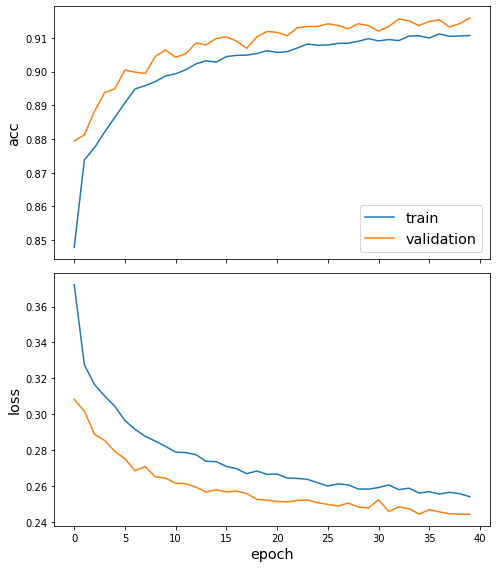

In [137]:
import stellargraph
stellargraph.utils.plot_history(history)

In [138]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

14310/14310 [==============================] - 640s 45ms/step - loss: 0.2377 - acc: 0.91881s - loss:

Train Set Metrics of the trained model:
	loss: 0.2480
	acc: 0.9163

Validation Set Metrics of the trained model:
	loss: 0.2441
	acc: 0.9161

Test Set Metrics of the trained model:
	loss: 0.2377
	acc: 0.9188


In [139]:
print("test_matrics: ", test_metrics)

test_matrics:  [0.23773537576198578, 0.9188393950462341]


In [140]:
y_true = test_flow.targets

In [141]:
y_true

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [142]:
y_pred = model.predict(test_flow, verbose=1)

14310/14310 [==============================] - 611s 43ms/step


In [143]:
y_pred = y_pred[:, 0]

In [144]:
y_pred

array([0.9131598 , 0.876073  , 0.7277244 , ..., 0.5599791 , 0.39938584,
       0.        ], dtype=float32)

In [145]:
data = []
for i in range(len(y_true)):
    data.append([y_true[i], y_pred[i]])

In [146]:
df = pd.DataFrame(data, columns=['y_true', 'y_pred'])

In [147]:
df.head()

y_true    y_pred
0       1  0.913160
1       1  0.876073
2       1  0.727724
3       1  0.864819
4       1  0.197107

In [148]:
df.to_csv("rawData.csv", index=False)

In [149]:
# AP
import numpy as np
from sklearn.metrics import average_precision_score

In [150]:
ap = average_precision_score(y_true, y_pred)

In [151]:
print("AP: ", ap)

AP:  0.9708196579448944


In [ ]:
# Save the model

In [152]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20, 82)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200, 82)]    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 20, 82)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 200, 82)]    0                                            
______________________________________________________________________________________________

In [153]:
model.save('keras/model.h5')

In [155]:
model.save('keras/saved/model')

2021-04-18 11:24:25,618 : WARNING : Found untraced functions such as leaky_re_lu_layer_call_and_return_conditional_losses, leaky_re_lu_layer_call_fn, leaky_re_lu_1_layer_call_and_return_conditional_losses, leaky_re_lu_1_layer_call_fn, leaky_re_lu_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.
2021-04-18 11:24:25,734 : WARNING : Found untraced functions such as leaky_re_lu_layer_call_and_return_conditional_losses, leaky_re_lu_layer_call_fn, leaky_re_lu_1_layer_call_and_return_conditional_losses, leaky_re_lu_1_layer_call_fn, leaky_re_lu_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: keras/saved/model\assets


2021-04-18 11:24:27,324 : INFO : Assets written to: keras/saved/model\assets


In [156]:
new_model = keras.models.load_model('keras/saved/model')

In [157]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20, 82)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200, 82)]    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 20, 82)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 200, 82)]    0                                            
______________________________________________________________________________________________

In [158]:
train_metrics = new_model.evaluate(train_flow)
val_metrics = new_model.evaluate(val_flow)
test_metrics = new_model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(new_model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(new_model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

14310/14310 [==============================] - 626s 44ms/step - loss: 0.2363 - acc: 0.91830s - loss: 0.2363 - acc: 

Train Set Metrics of the trained model:
	loss: 0.2473
	acc: 0.9160

Validation Set Metrics of the trained model:
	loss: 0.2449
	acc: 0.9159

Test Set Metrics of the trained model:
	loss: 0.2363
	acc: 0.9183


In [ ]:
# just check some stuff

In [159]:
print("YAYA")

YAYA


In [ ]:
# test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
# test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [175]:
edge_ids_test

array([[ 74321,  74323],
       [398623, 218812],
       [ 67020,  67018],
       ...,
       [103753, 320030],
       [397038,   4896],
       [109717, 161941]], dtype=int64)

In [163]:
edge_labels_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [164]:
check_label = []
check_label.append(0)
print(check_label)

[0]


In [235]:
check_label = np.array([1])

In [236]:
type(check_label)

numpy.ndarray

In [237]:
check_ids = np.array([[0, 2]])

In [244]:
check_ids

array([[0, 2]])

In [239]:
check_ids.shape

(1, 2)

In [240]:
print(sg.info())

StellarGraph: Undirected multigraph
 Nodes: 527402, Edges: 1430992

 Node types:
  default: [527402]
    Features: float32 vector, length 82
    Edge types: default-default->default

 Edge types:
    default-default->default: [1430992]
        Weights: all 1 (default)
        Features: none


In [241]:
check_gen = GraphSAGELinkGenerator(sg, batch_size, num_samples)
check_flow = check_gen.flow(check_ids, check_label)

In [243]:
train_metrics = model.evaluate(check_flow)

print("\nCheck Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 43ms/step - loss: 0.1361 - acc: 1.0000

Check Set Metrics of the trained model:
	loss: 0.1361
	acc: 1.0000


In [258]:
(60000 * 60000 / 2) - 120000

1799880000.0

In [259]:
yo = graph.run("""

MATCH((n:Author)<-[:AUTHOR]-(a:Article))
RETURN n.name as name,apoc.text.join(collect(a.fos),":") as fos,apoc.text.join(collect(a.title)," ") as title, n.org as org
ORDER BY n.name

""").to_data_frame()

In [263]:
yo['org'].drop_duplicates()

0         Department of Electrical, Electronic and Compu...
1         Department of Mathematics and Computing Scienc...
2                                                          
4         Advanced Design and Manufacturing Engineering ...
5           Univ. of the West of England (UWE), Bristol, UK
                                ...                        
527290    Department of Industrial Design, Eindhoven Tec...
527292    Professor, Faculty of Civil and Geodetic Engin...
527297    Lithuanian University of Health Sciences, Vyta...
527298    University of Economics, Czech Republic, email...
527307                                         九州大学情報基盤センター
Name: org, Length: 194344, dtype: object

In [267]:
yo['org'].value_counts()

                                                                                                                 116432
Carnegie Mellon University                                                                                          568
Association for Information Systems                                                                                 563
University of California                                                                                            429
Stanford University                                                                                                 397
                                                                                                                  ...  
CEA, DSV, I2BM, Gif-Sur-Yvette, France#TAB#                                                                           1
Knowledge Engineering and Machine Learning Group, Universitat Politècnica de Catalunya, Barcelona, Spain#TAB#         1
Inst. Auto. Cont. and Comp. Sys., Univer